# Colima Inversion Examples

In [1]:
%matplotlib inline
import sys
sys.path.append("..")

from project.inversion import *
import project.io_utils as io
import project.vis_utils as vis
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import beta, expon, truncnorm, norm, uniform
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
import copy
from matplotlib import cm
from tabulate import tabulate

pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

## Observation Data

Reading in Colima observation dataset and extracting grid

In [2]:
filename = "../data/colima/colima_real_data.csv"

raw_df, grid = io.import_colima(filename)

grid.to_csv("../data/colima/colima_grid.csv", sep=" ", header=False, index=False)

print(tabulate(raw_df.head(), headers="keys", tablefmt="fancy_grid"))

╒════╤══════════════╤═══════════╤════════════╤════════════╤═════════════╤═══════════╤═══════════╤═══════════╤═══════════╤══════════╤═════════╤═════════╤═════════╤═════════╤══════════╕
│    │ Sample no.   │   Easting │   Northing │   MassArea │   Thickness │   [-5,-4) │   [-4,-3) │   [-3,-2) │   [-2,-1) │   [-1,0) │   [0,1) │   [1,2) │   [2,3) │   [3,4) │   radius │
╞════╪══════════════╪═══════════╪════════════╪════════════╪═════════════╪═══════════╪═══════════╪═══════════╪═══════════╪══════════╪═════════╪═════════╪═════════╪═════════╪══════════╡
│ 16 │ VF0004a      │      1499 │       1506 │     625.8  │          60 │      19.2 │        31 │        18 │        11 │        6 │       2 │       1 │     0.6 │     0.9 │  2124.86 │
├────┼──────────────┼───────────┼────────────┼────────────┼─────────────┼───────────┼───────────┼───────────┼───────────┼──────────┼─────────┼─────────┼─────────┼─────────┼──────────┤
│ 18 │ VF0006a3     │      1957 │       1997 │     417.2  │          40 │       

## Pre Processing

Residual column is added for consistency later on. 

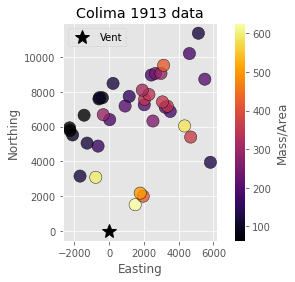

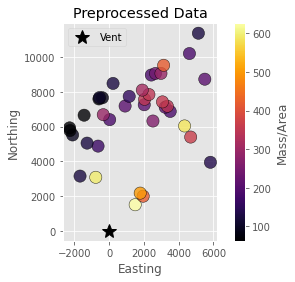

In [3]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

# obs_df = obs_df.drop([16, 18, 17, 37, 31])
#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

## Reading in Tephra2 datasets

To demonstrate consistency with Tephra2, this dataset must be generated by Tephra2 using the exact same parameters as is used in the forward modelling. 

In [4]:
t2_df, _, _, _ = io.read_tephra2("../data/colima/colima_tephra2_sim_data.txt")

t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values

display(t2_df.head())

Easting  Northing  Elevation  MassArea  [-5,-4)  [-4,-3)  [-3,-2)  \
16     1499      1506          0    732.73  23.1529  25.4668  22.2407   
18     1957      1997          0   691.154  21.3541  24.7682  22.4602   
17     1787      2173          0   709.841  21.2137    24.71  22.4801   
37     -770      3082          0   301.066  13.8022  19.2173  22.1297   
31    -1673      3152          0    149.68  9.51561  14.8613  20.3208   

    [-2,-1)  [-1,0)   [0,1)    [1,2)    [2,3)     [3,4)   radius  Residual  
16  15.7304 8.99492 3.44384 0.823464 0.136596 0.0103587 2,124.86   1.17087  
18  16.5434 9.82586 3.90198 0.968656 0.164832 0.0128943 2,796.04   1.65665  
17  16.6062 9.88889 3.93999 0.980849  0.16722  0.013114 2,813.41   1.41787  
37  20.4626 14.7247 7.12663  2.10569 0.398324 0.0329064 3,176.73   0.50641  
31  22.2637 18.4942 10.3172  3.45994 0.706562 0.0606982 3,568.48   1.19591

In [5]:
t2_const_df, _, _, _ = io.read_tephra2("../data/colima/colima_tephra2_const_wind_sim_data.txt")

t2_const_df["Residual"] = t2_const_df["MassArea"]/obs_df["MassArea"]

display(t2_const_df.head())

Easting  Northing  Elevation  MassArea  [-5,-4)  [-4,-3)  [-3,-2)  \
16     1499      1506       2500  1,394.46  17.2005  24.2121  24.7779   
18     1957      1997       2500  1,216.15   14.016  22.3619   24.864   
17     1787      2173       2500     1,251   13.877  22.2837  24.8861   
37     -770      3082       2500   359.399  14.8025  22.8299  24.5313   
31    -1673      3152       2500   134.301  15.3664  23.3283  24.4813   

    [-2,-1)  [-1,0)   [0,1)    [1,2)     [2,3)       [3,4)   radius  Residual  
16  18.9162 10.8457 3.58293 0.449327  0.015328 2.84769e-05 2,124.86   2.22828  
18  20.2838 12.7356 4.93885  0.76913 0.0307052 6.30498e-05 2,796.04   2.91503  
17  20.3522 12.8046 4.98427 0.780754 0.0313104 6.44789e-05 2,813.41    2.4988  
37  19.4545 12.2828 5.13528 0.922533 0.0410962 9.09858e-05 3,176.73   0.60453  
31  18.8191 11.7036 5.16746  1.07907  0.054478 0.000131905 3,568.48   1.07303

## Set up inversion configuration

- Read in Tephra2 config file
- Set global parameters
- Set other inversion parameters

### Internal consistency requirements

In order to demonstrate perfect internal consistency we need our forward model to invert perfectly, i.e. return the exact input parameters that simulated it. Such a perfect inversion requires that the release points in the column be in exactly the same place in the forward model as in the inversion. 

The forward model evenly spaces the release points between the vent height and the plume height, putting a point at each. In order to demonstrate internal consistency, those same points need to be used for inversion. To this end, a theoretical maximum column height and number of inversion column steps is calculated that places release points for inversion at those same points in the column that would be used in the forward model, while adding evenly spaced points above the actual plume height. 

If internal consistency is not required these values can be set for efficient inversion. 

In [6]:
config = io.read_tephra2_config("../data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
# COL STEPS need to be small enough so the 
# layer height can be kept for an inversion with a high H
config["COL_STEPS"] = 20
theoretical_max = 45000 #The H value will be as close as possible to this
layer_thickness = ((config["PLUME_HEIGHT"]-config["VENT_ELEVATION"])/config["COL_STEPS"])

inversion_steps = np.round((config["COL_STEPS"]*(theoretical_max - config["VENT_ELEVATION"]))/\
                  (config["PLUME_HEIGHT"]-config["VENT_ELEVATION"]))
closest_H = ((inversion_steps*(config["PLUME_HEIGHT"] - config["VENT_ELEVATION"]))/\
             config["COL_STEPS"]) + config["VENT_ELEVATION"]
print("This number needs to be low enough to invert efficiently:")
print(inversion_steps)
print("If not, decrease COL_STEPS or theoretical max")
print("Closest Possible Theoretical Max Column Height:")
print(closest_H)

config["INV_STEPS"] = int(inversion_steps)
config["THEO_MAX_COL"] = closest_H
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

# To ensure monotonicity:
# config["DIFFUSION_COEFFICIENT"] = 1.7*config["FALL_TIME_THRESHOLD"]

print("INPUT PARAMETERS:")
display(config)
display(globs)

This number needs to be low enough to invert efficiently:
40.0
If not, decrease COL_STEPS or theoretical max
Closest Possible Theoretical Max Column Height:
44915.0
INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'INV_STEPS': 40,
 'THEO_MAX_COL': 44915.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

## Phi class calculations

### Theoretical phi parameters

The function `get_phi_steps` generates phi classes using Tephra2 input variables in the exact same way as Tephra2. 

lower  upper interval  centroid  density  probability
0     -5     -4  [-5,-4)      -4.5    1,024    0.0683375
1     -4     -3  [-4,-3)      -3.5    1,024     0.109203
2     -3     -2  [-3,-2)      -2.5    1,024     0.146694
3     -2     -1  [-2,-1)      -1.5    1,024      0.16565
4     -1      0   [-1,0)      -0.5    1,024     0.157243
5      0      1    [0,1)       0.5  1,233.5     0.125474
6      1      2    [1,2)       1.5    1,443    0.0841661
7      2      3    [2,3)       2.5  1,652.5    0.0474595
8      3      4    [3,4)       3.5    1,862    0.0224962

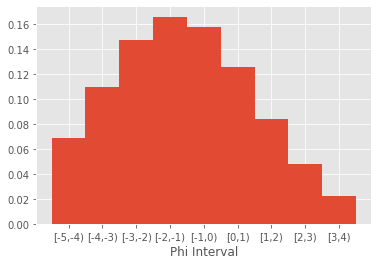

In [7]:
theo_phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(theo_phi_steps))



probs = [phi["probability"].copy() for phi in theo_phi_steps]
x = [phi["centroid"] for phi in theo_phi_steps]
labels = [phi["interval"] for phi in theo_phi_steps]
fig, ax = plt.subplots(facecolor='w', edgecolor='k')
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

### Naive TGSD calculation

The function `get_tgsd` calculates performs a naive calculation of the TGSD. 

It sums up the total mass in each phi class, and then normalises that to add up to 1. 

We often use this naive TGSD estimation as a prior. 

[0.05231643 0.16945065 0.20390996 0.20809308 0.19893822 0.12429353
 0.02893896 0.00704844 0.00701073]
[-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]


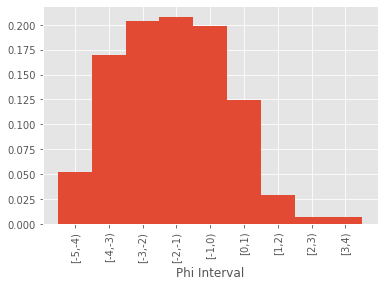

[{'lower': -5, 'upper': -4.0, 'interval': '[-5,-4)', 'centroid': -4.5, 'density': 1024.0, 'probability': 0.052316431318540024}, {'lower': -4.0, 'upper': -3.0, 'interval': '[-4,-3)', 'centroid': -3.5, 'density': 1024.0, 'probability': 0.1694506511837887}, {'lower': -3.0, 'upper': -2.0, 'interval': '[-3,-2)', 'centroid': -2.5, 'density': 1024.0, 'probability': 0.20390996005463202}, {'lower': -2.0, 'upper': -1.0, 'interval': '[-2,-1)', 'centroid': -1.5, 'density': 1024.0, 'probability': 0.2080930801364657}, {'lower': -1.0, 'upper': 0.0, 'interval': '[-1,0)', 'centroid': -0.5, 'density': 1024.0, 'probability': 0.19893821897376404}, {'lower': 0.0, 'upper': 1.0, 'interval': '[0,1)', 'centroid': 0.5, 'density': 1233.5, 'probability': 0.12429352702169855}, {'lower': 1.0, 'upper': 2.0, 'interval': '[1,2)', 'centroid': 1.5, 'density': 1443.0, 'probability': 0.028938961877603735}, {'lower': 2.0, 'upper': 3.0, 'interval': '[2,3)', 'centroid': 2.5, 'density': 1652.5, 'probability': 0.00704844304499

In [8]:
naive_tgsd = get_tgsd(obs_df, theo_phi_steps)
print(naive_tgsd)
print(x)
fig, ax = plt.subplots(facecolor='w', edgecolor='k')
ax.bar(x, naive_tgsd, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xlabel("Phi Interval")
plt.show()

naive_phi_steps = theo_phi_steps.copy()
for i, phi in enumerate(naive_phi_steps):
    phi["probability"] = naive_tgsd[i]
print(naive_phi_steps)

## Forward modelling

Our forward model is as close to Tephra2 as possible, except that it does not support separate wind levels. 

In [9]:
grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)

forward_df = gaussian_stack_forward(
    grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
    config["PLUME_HEIGHT"], 2500, naive_phi_steps, (config["ALPHA"], config["BETA"]), 
    config["ERUPTION_MASS"], 
    (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
    config["FALL_TIME_THRESHOLD"]
)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values
display(forward_df.head())
print("Wind parameters:")
print("u = %g, v = %g"%(u, v))

Northing  Easting  [-5,-4)  [-4,-3)  [-3,-2)  [-2,-1)  [-1,0)   [0,1)  \
0      1506     1499  10.2913  29.5685   27.288   18.924 10.9616 2.84099   
1      1997     1957   8.3142  27.1464  27.2807  20.2572 12.8676 3.91805   
2      2173     1787  8.22952  27.0446  27.2982  20.3207 12.9346 3.95335   
3      3082     -770   8.7488  27.7372  27.0418  19.5747 12.5223 4.11323   
4      3152    -1673   9.0285   28.313  27.0764  19.0615 12.0333 4.17711   

     [1,2)      [2,3)       [3,4)  MassArea   radius  Residual  
0 0.123803   0.001825 7.10812e-06  1,678.84 2,124.86   2.68271  
1 0.212099 0.00365928 1.57598e-05   1,462.8 2,796.04   3.50624  
2 0.215267 0.00373077 1.61147e-05  1,504.98 2,813.41   3.00611  
3 0.256923 0.00494637 2.29538e-05   428.027 3,176.73  0.719966  
4 0.303382  0.0066199 3.35645e-05   158.425 3,568.48   1.26578

Wind parameters:
u = 5.73576, v = 8.19152


## Visual Analysis

Here we use our plotting library to visualise the observation and synthetic datasets. 

/home/nice/repos/inversion_project/notebooks/../project/vis_utils.py:133: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  bg = ax.scatter(


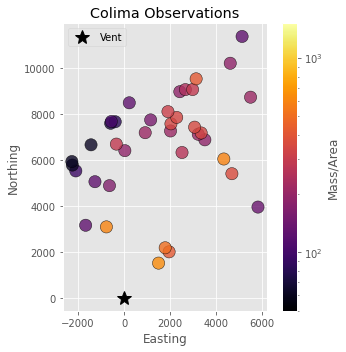

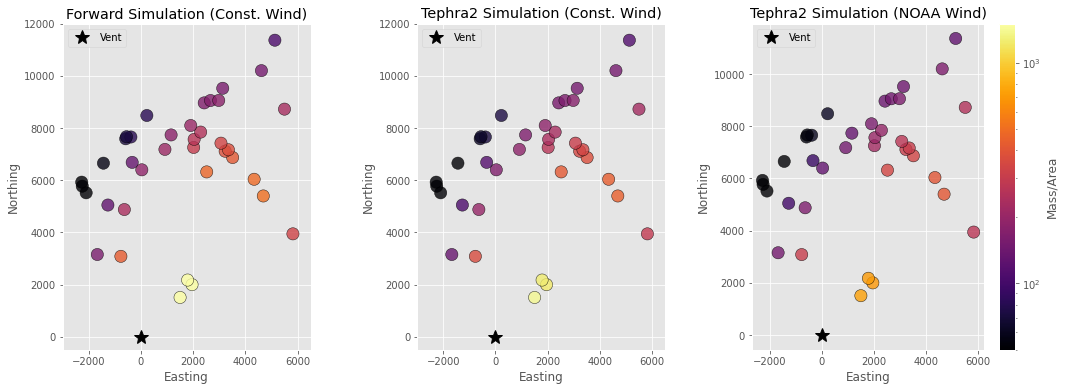

In [10]:

fig, ax = plt.subplots(1, 1, figsize=(5,5))

vis.plot_sample(obs_df, vent=(0,0), log=True, bounds=(50, 1500),
            title="Colima Observations", cbar_label="Mass/Area", ax = ax)
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 3, figsize=(
        18,6), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(forward_df, vent=(0,0), log=True, bounds=(50, 1500), show_cbar=False,
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(t2_const_df, vent=(0,0), log=True, bounds=(50, 1500), show_cbar=False,
            title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=True, bounds=(50, 1500),
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[2])
axs[0].set_xlim([-3000, 6500])
axs[0].set_ylim([-500, 12000])
axs[1].set_xlim([-3000, 6500])
axs[1].set_ylim([-500, 12000])
plt.show()




### Residual plots

These plots compare the synthetic datasets with the observation dataset in each case. 

The residual calculation is: `(synthetic/observation)*100`

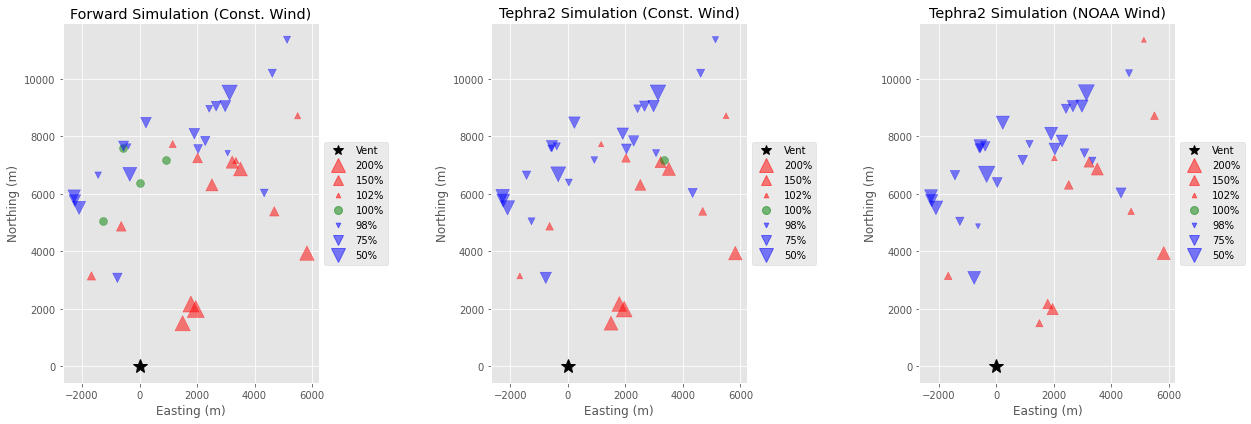

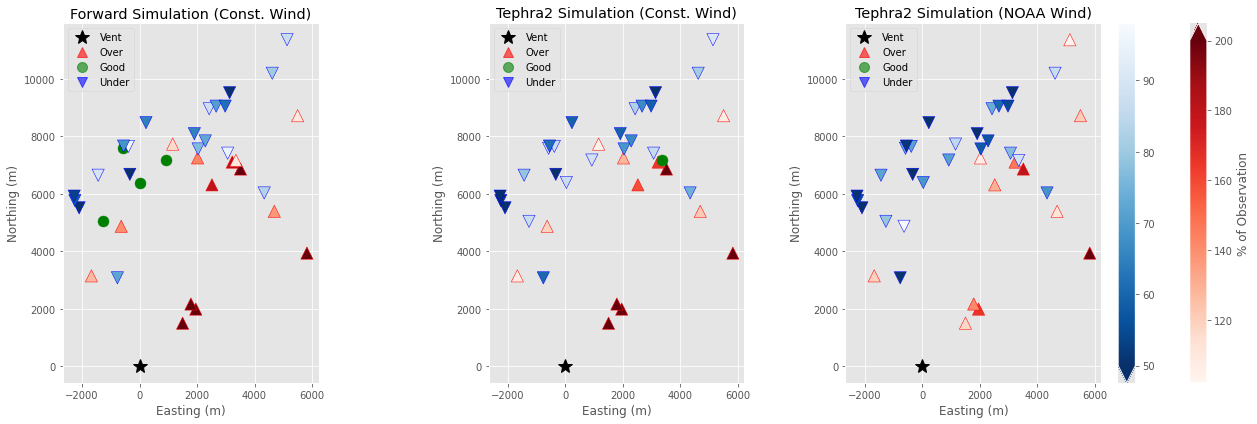

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(
        18,6), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_residuals(forward_df, vent=(0,0), values="Residual",
            title="Forward Simulation (Const. Wind)", 
            plot_type = "size", ax=axs[0])
vis.plot_residuals(t2_const_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
             plot_type = "size", ax=axs[1])
vis.plot_residuals(t2_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
             plot_type = "size", ax=axs[2])


plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(
        18,6), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_residuals(forward_df, vent=(0,0), values="Residual",
            title="Forward Simulation (Const. Wind)", 
            plot_type = "cmap", ax=axs[0], show_cbar = False)
vis.plot_residuals(t2_const_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
             plot_type = "cmap", ax=axs[1], show_cbar = False)
vis.plot_residuals(t2_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
             plot_type = "cmap", ax=axs[2], show_cbar = True)


# plt.tight_layout()
plt.show()

### Distance plots

These plots sort the points by their distance from the vent, giving a general sense of the decay curves in all directions from the vent. 

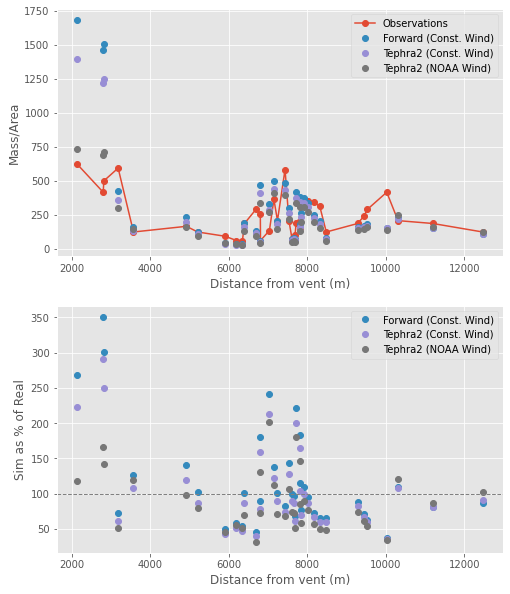

In [12]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward (Const. Wind)")
axs[0].plot(t2_const_df["radius"].values, t2_const_df["MassArea"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values*100, 'C1o', label="Forward (Const. Wind)")
axs[1].plot(t2_const_df["radius"].values, t2_const_df["Residual"].values*100, 'C2o', label="Tephra2 (Const. Wind)")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values*100, 'C3o', label="Tephra2 (NOAA Wind)")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

## Inversion Test

This inversion test uses exact priors so that no actual inversion needs to be done in the inversion of the forward model. With this biased inversion we can test internal consistency. The input parameters need to be recovered exactly for this test to pass. 

In this test, we will be able to compare some or all of the following datasets, the most important of which is the Forward model inversion using fixed priors. 

#### No inversion. 
A forward modeled dataset is added, and inversion is NOT performed on it. This gives us a baseline, and allows us to confirm the following:
    - The residual analysis plots are accurate. A dataset compared directly with itself should show zero residual. 

#### Forward model inversion using fixed priors. 
This inversion should not change the parameters, as they are already optimised. If this inversion changes the parameters then we don't have a stable model. 

#### Tephra2 inversion with constant wind. 
Since our assumption is that Tephra2 is functionally identical to our forward model in the case of a fixed wind profile, the results of this inversion should be identical to the Forward model inversion. If this is not the case, we no longer have consistency with the Tephra2 code, which is a problem. 

#### Observation dataset inversion. 
Since we are using a single inversion run with fixed priors here, we do not expect this inversion to be successful at all. It's still good to see what happens. 

========Forward Sim========


Height  Suspended Mass
0  4,130.75     4.35961e+09
1   5,176.5     4.27051e+09
2  6,222.25     4.16026e+09
3     7,268     4.03746e+09
4  8,313.75     3.90513e+09
5   9,359.5     3.76451e+09
6  10,405.2     3.61603e+09
7    11,451     3.45969e+09
8  12,496.8     3.29513e+09
9  13,542.5     3.12171e+09
10 14,588.2     2.93847e+09
11   15,634     2.74402e+09
12 16,679.8     2.53645e+09
13 17,725.5     2.31301e+09
14 18,771.2     2.06956e+09
15   19,817     1.79951e+09
16 20,862.8       1.491e+09
17 21,908.5     1.11793e+09
18 22,954.2               0
19   24,000               0
20 25,045.8               0
21 26,091.5               0
22 27,137.2               0
23   28,183               0
24 29,228.8               0
25 30,274.5               0
26 31,320.2               0
27   32,366               0
28 33,411.8               0
29 34,457.5               0
30 35,503.2               0
31   36,549               0
32 37,594.8               0
33 38,640.5               0
34 39,686.2               0
35   40,732               0
36 41,777.8               0
37 42,823.5               0
38 43,869.2               0
39   44,915               0

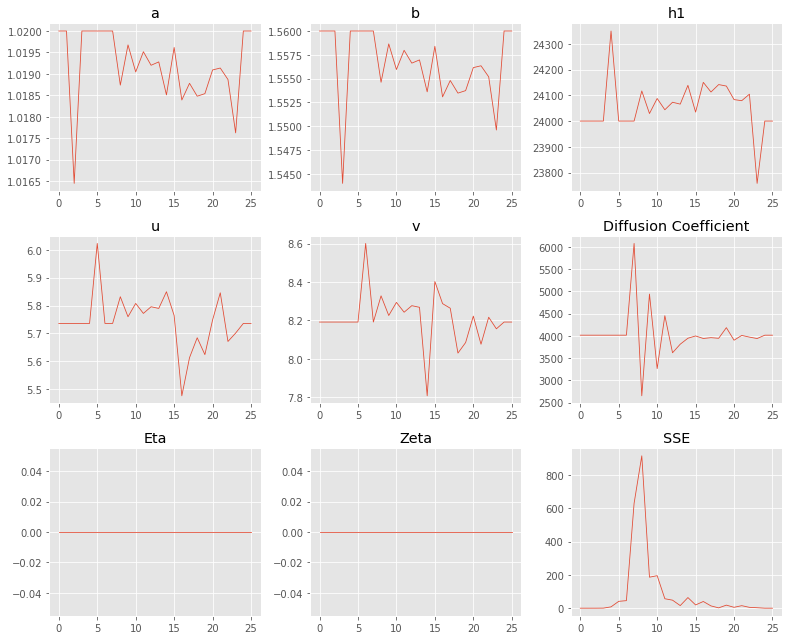

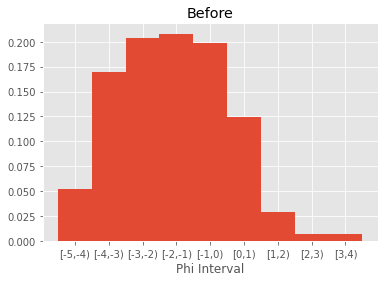

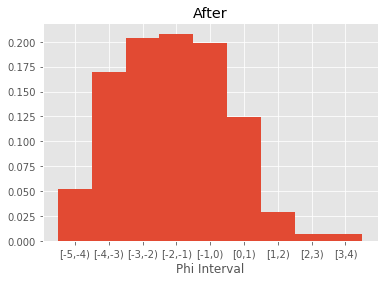

Forward Sim Run Time: 0.07644 minutes


========T2 Const. Wind========


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Height  Suspended Mass
0  4,130.75     4.17637e+09
1   5,176.5     4.05432e+09
2  6,222.25     3.92957e+09
3     7,268      3.8019e+09
4  8,313.75     3.67107e+09
5   9,359.5     3.53678e+09
6  10,405.2     3.39872e+09
7    11,451     3.25649e+09
8  12,496.8     3.10964e+09
9  13,542.5      2.9576e+09
10 14,588.2     2.79972e+09
11   15,634     2.63513e+09
12 16,679.8     2.46278e+09
13 17,725.5     2.28124e+09
14 18,771.2     2.08862e+09
15   19,817     1.88221e+09
16 20,862.8     1.65793e+09
17 21,908.5      1.4091e+09
18 22,954.2     1.12299e+09
19   24,000     7.67807e+08
20 25,045.8               0
21 26,091.5               0
22 27,137.2               0
23   28,183               0
24 29,228.8               0
25 30,274.5               0
26 31,320.2               0
27   32,366               0
28 33,411.8               0
29 34,457.5               0
30 35,503.2               0
31   36,549               0
32 37,594.8               0
33 38,640.5               0
34 39,686.2               0
35   40,732               0
36 41,777.8               0
37 42,823.5               0
38 43,869.2               0
39   44,915               0

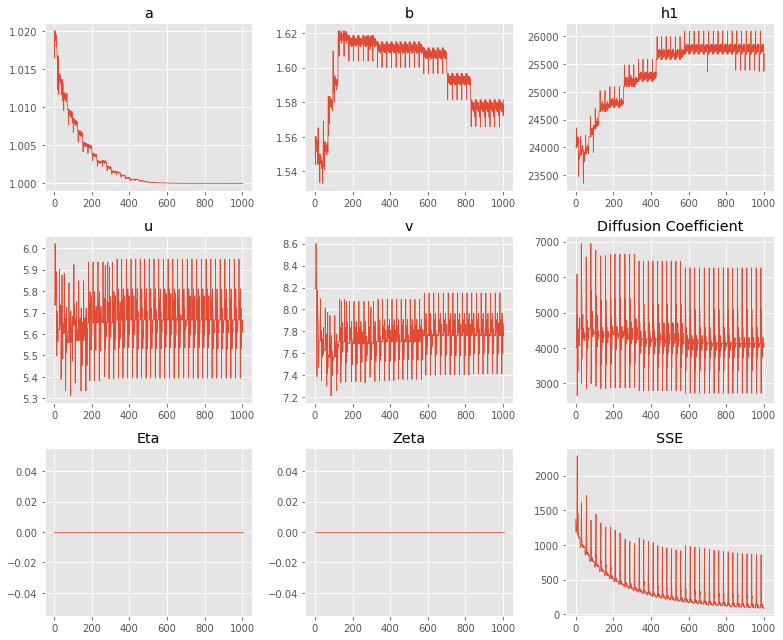

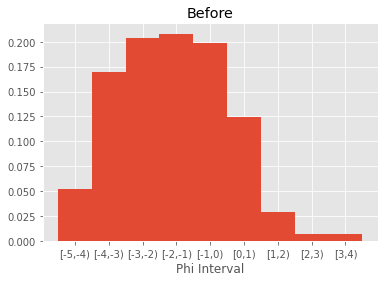

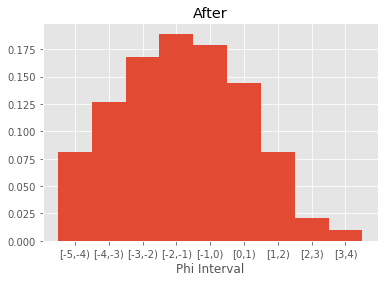

T2 Const. Wind Run Time: 2.28150 minutes


========T2 NOAA wind========


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Height  Suspended Mass
0  4,130.75     2.78362e+09
1   5,176.5     2.72409e+09
2  6,222.25     2.66389e+09
3     7,268     2.60306e+09
4  8,313.75     2.54158e+09
5   9,359.5     2.47944e+09
6  10,405.2      2.4166e+09
7    11,451     2.35304e+09
8  12,496.8     2.28872e+09
9  13,542.5     2.22361e+09
10 14,588.2     2.15766e+09
11   15,634     2.09083e+09
12 16,679.8     2.02306e+09
13 17,725.5     1.95429e+09
14 18,771.2     1.88446e+09
15   19,817     1.81349e+09
16 20,862.8     1.74131e+09
17 21,908.5      1.6678e+09
18 22,954.2     1.59287e+09
19   24,000     1.51639e+09
20 25,045.8     1.43821e+09
21 26,091.5     1.35815e+09
22 27,137.2       1.276e+09
23   28,183      1.1915e+09
24 29,228.8     1.10433e+09
25 30,274.5     1.01408e+09
26 31,320.2     9.20218e+08
27   32,366     8.22023e+08
28 33,411.8     7.18463e+08
29 34,457.5     6.07972e+08
30 35,503.2     4.87925e+08
31   36,549     3.53107e+08
32 37,594.8      1.8821e+08
33 38,640.5               0
34 39,686.2               0
35   40,732               0
36 41,777.8               0
37 42,823.5               0
38 43,869.2               0
39   44,915               0

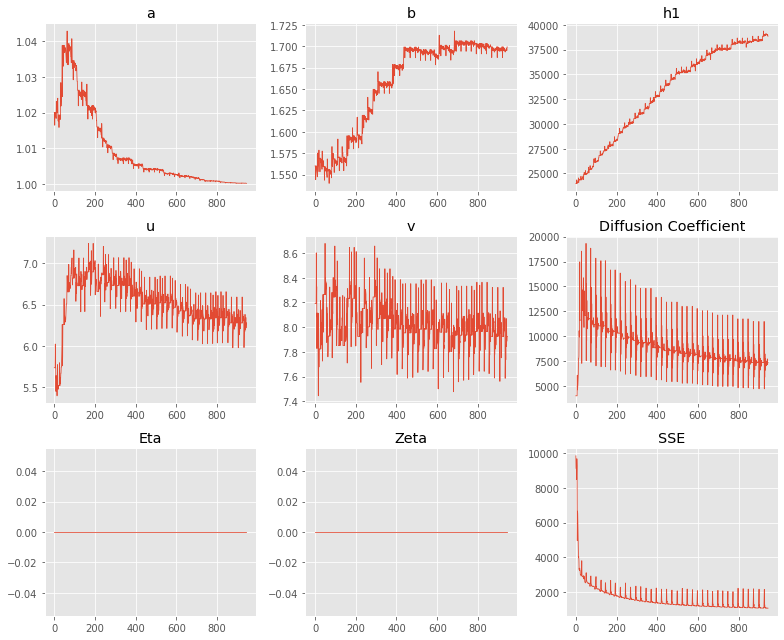

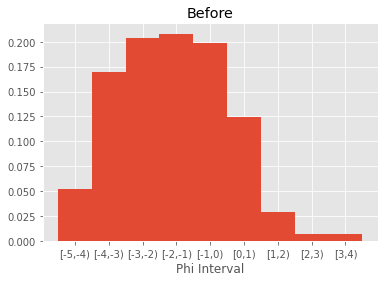

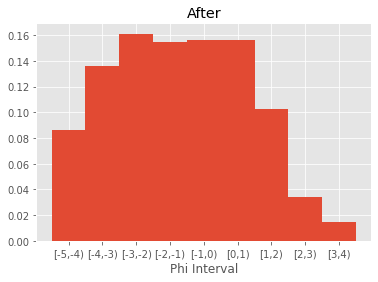

T2 NOAA wind Run Time: 2.15334 minutes


========Observation Data========


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Height  Suspended Mass
0  4,130.75     1.97312e+09
1   5,176.5     1.95936e+09
2  6,222.25     1.94523e+09
3     7,268     1.93075e+09
4  8,313.75     1.91589e+09
5   9,359.5     1.90064e+09
6  10,405.2     1.88497e+09
7    11,451     1.86887e+09
8  12,496.8     1.85231e+09
9  13,542.5     1.83524e+09
10 14,588.2     1.81765e+09
11   15,634     1.79949e+09
12 16,679.8     1.78071e+09
13 17,725.5     1.76127e+09
14 18,771.2     1.74111e+09
15   19,817     1.72016e+09
16 20,862.8     1.69836e+09
17 21,908.5     1.67561e+09
18 22,954.2     1.65182e+09
19   24,000     1.62687e+09
20 25,045.8     1.60061e+09
21 26,091.5     1.57289e+09
22 27,137.2     1.54349e+09
23   28,183     1.51216e+09
24 29,228.8     1.47859e+09
25 30,274.5     1.44235e+09
26 31,320.2     1.40291e+09
27   32,366     1.35953e+09
28 33,411.8     1.31114e+09
29 34,457.5     1.25618e+09
30 35,503.2     1.19211e+09
31   36,549      1.1144e+09
32 37,594.8      1.0135e+09
33 38,640.5      8.6071e+08
34 39,686.2               0
35   40,732               0
36 41,777.8               0
37 42,823.5               0
38 43,869.2               0
39   44,915               0

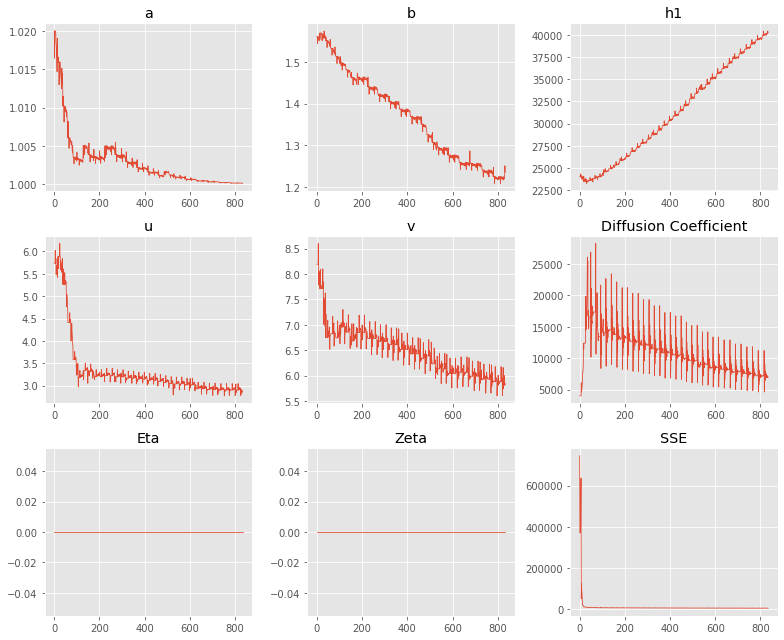

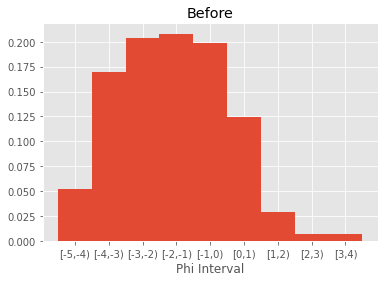

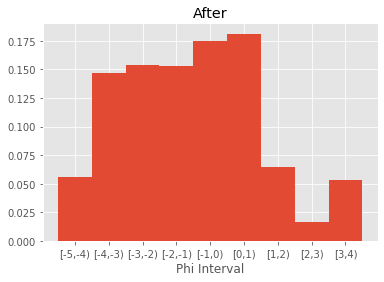

Observation Data Run Time: 1.89758 minutes


Total Run Time: 6.40889 minutes


In [18]:
prior_phi_steps = copy.deepcopy(naive_phi_steps)

z = np.linspace(config["VENT_ELEVATION"] + layer_thickness, config["THEO_MAX_COL"], 
                config["INV_STEPS"])
q_dist = beta(config["ALPHA"],config["BETA"])

q_mass = beta_plume(config["ALPHA"],config["BETA"],config["PLUME_HEIGHT"],
                    config["ERUPTION_MASS"],
                    z,
                    config["VENT_ELEVATION"], 
                    config["THEO_MAX_COL"])

priors_vals = {
    "a": config["ALPHA"],
    "b": config["BETA"],
    "h1": config["PLUME_HEIGHT"],
    "u": u,
    "v": v,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "eta": 0,
    "zeta": 0
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": True,
    "v": True,
    "D": True,
    "ftt": False,
    "eta": False,
    "zeta": False
}



t_tot = process_time()
single_run_time = 0
wind_angle = np.radians(55.5)

names = ["No Inversion", "Forward Sim", "T2 Const. Wind", "T2 NOAA wind", "Observation Data"]
data_sets = [forward_df, forward_df, t2_const_df, t2_df, obs_df]

inverted_masses_list = []
inverted_masses_list += [q_mass]
params_list = []
sim_params = priors_vals
params_list += [sim_params]
mass_list = []
tgsd_list = []
misfit_list = []
mass_list += [config["ERUPTION_MASS"]]
tgsd_list += [[phi["probability"].copy() for phi in prior_phi_steps]]
misfit_list += ["--"]

for name, df in zip(names[1:], data_sets[1:]):
    t = process_time()
    run_phis = copy.deepcopy(prior_phi_steps)
    print("========%s========"%name)
    out = gaussian_stack_inversion(
        df, len(df), config["INV_STEPS"], config["VENT_ELEVATION"], 
        config["THEO_MAX_COL"], 2500, run_phis, config["ERUPTION_MASS"],
        invert_params=invert_params, 
        priors=priors_vals,
        max_iter=40, tol=0.006, 
        adjust_TGSD=True, adjust_mass=False,
        adjustment_factor=None,
        column_cap=config["THEO_MAX_COL"],
        logging=None
    )
    inversion_table, params, misfit, status, param_trace, misfit_trace, tgsd_trace, mass_trace = out
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
    tgsd_list += [tgsd_trace[-1]]
    mass_list += [mass_trace[-1]]
    misfit_list += [misfit]
    display(inversion_table)
    param_trace = np.array(param_trace)
    fig, axs = plt.subplots(3,3, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(param_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(param_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(param_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")
    
    axs[3].plot(param_trace[:,3], linewidth=.8)
    axs[3].set_title("u")

    axs[4].plot(param_trace[:,4], linewidth=.8)
    axs[4].set_title("v")
    
    axs[5].plot(param_trace[:,5], linewidth=.8)
    axs[5].set_title("Diffusion Coefficient")
    
    axs[6].plot(param_trace[:,7], linewidth=.8)
    axs[6].set_title("Eta")
    
    axs[7].plot(param_trace[:,8], linewidth=.8)
    axs[7].set_title("Zeta")

    axs[8].plot(misfit_trace, linewidth=.8)
    axs[8].set_title("SSE")
    
#     print(sse_trace)

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
    fig, ax = plt.subplots(facecolor='w', edgecolor='k')
    ax.bar(x, tgsd_trace[0], width=1, align="center")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.xlabel("Phi Interval")
    plt.title("Before")
    plt.show()
    
    fig, ax = plt.subplots(facecolor='w', edgecolor='k')
    ax.bar(x, tgsd_trace[-1], width=1, align="center")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.xlabel("Phi Interval")
    plt.title("After")
    plt.show()
    
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(name, run_time/60))


total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

## TGSD Adjustment Results

If TGSD adjustment is toggled off in the tests above, this should show no change. Otherwise this will show the TGSD adjustment for each dataset. 

Forward Sim and No Inversion should have no TGSD adjustment, even when toggled on.

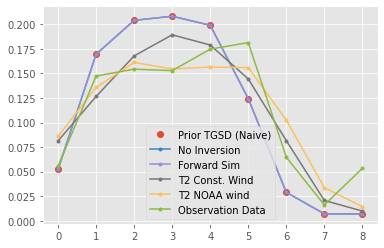

In [19]:
plt.figure()
plt.plot([phi["probability"] for phi in prior_phi_steps], "o", label="Prior TGSD (Naive)")
for i, name in enumerate(names):
    plt.plot(tgsd_list[i], ".-", label=name)
plt.legend()
plt.show()



## Inversion Results

Here we show the results of the parameter inversions. 

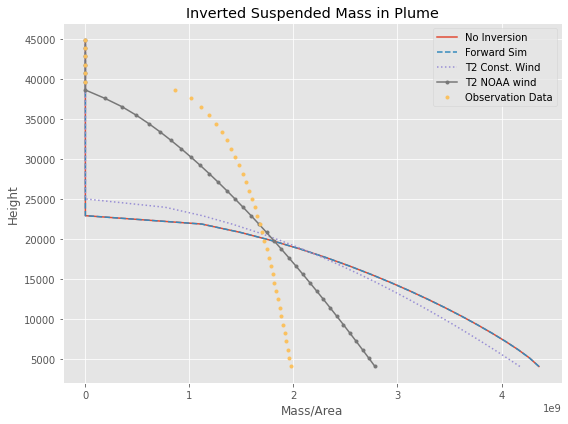

Dataset       a       b       h1       u       v        D   ftt  \
0      No Inversion    1.02    1.56   24,000 5.73576 8.19152    4,016 6,458   
1       Forward Sim    1.02    1.56   24,000 5.73576 8.19152    4,016 6,458   
2    T2 Const. Wind       1 1.58135 25,681.6  5.6655 7.76134    4,129 6,458   
3      T2 NOAA wind 1.00016 1.69905 38,862.3 6.27843  7.9259 7,355.65 6,458   
4  Observation Data 1.00011 1.23669 40,264.9 2.86768 5.83916 7,013.91 6,458   

   eta  zeta       M      Misfit  
0    0     0 5.5e+10          --  
1    0     0 5.5e+10 6.04925e-28  
2    0     0 5.5e+10      88.348  
3    0     0 5.5e+10    1,046.89  
4    0     0 5.5e+10    4,037.79

In [20]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

ltype = ["-", "--", ":", ".-", "."]

for name, mass, lt in zip(names, inverted_masses_list, ltype):
    ax1.plot(mass, 
         inversion_table["Height"], lt, label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")
ax1.set_title("Inverted Suspended Mass in Plume")
plt.tight_layout()
plt.show()
params_df = pd.DataFrame(params_list)
params_df["Dataset"] = names
params_df = params_df[["Dataset", "a", "b", "h1", "u", "v", "D", "ftt", "eta", "zeta"]]
params_df["M"] = mass_list
params_df["Misfit"] = misfit_list
display(params_df)

## Single Inversion Diagnostics

Here we can look at the diagnostics of a single inversion at a time, as opposed to a sampled prior inversion scheme as it would usually be applied. 



========No Inversion========
{'a': 1.02, 'b': 1.56, 'h1': 24000.0, 'u': 5.735764363510461, 'v': 8.191520442889917, 'D': 4016.0, 'ftt': 6458.0, 'eta': 0, 'zeta': 0} 55000000000.0


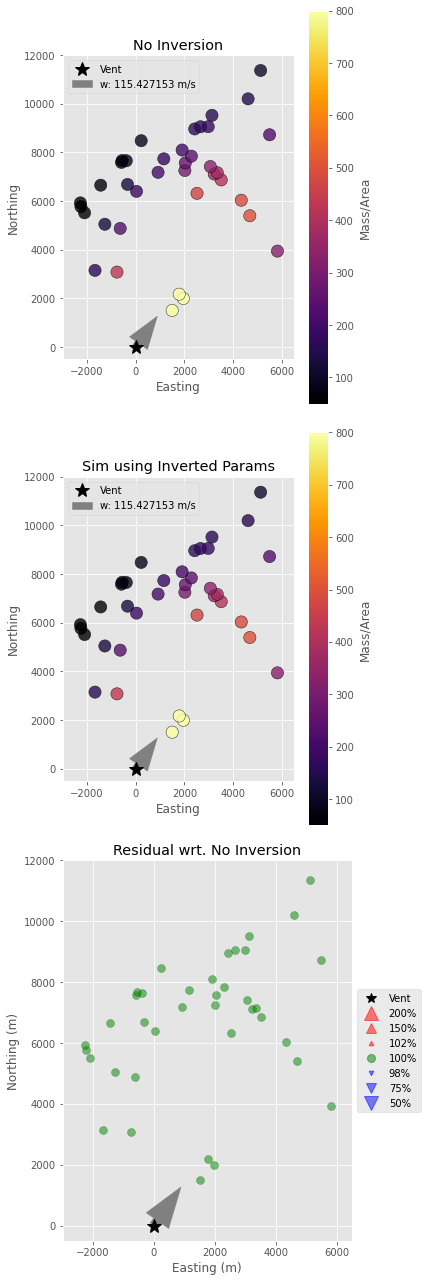

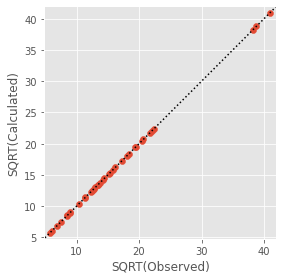

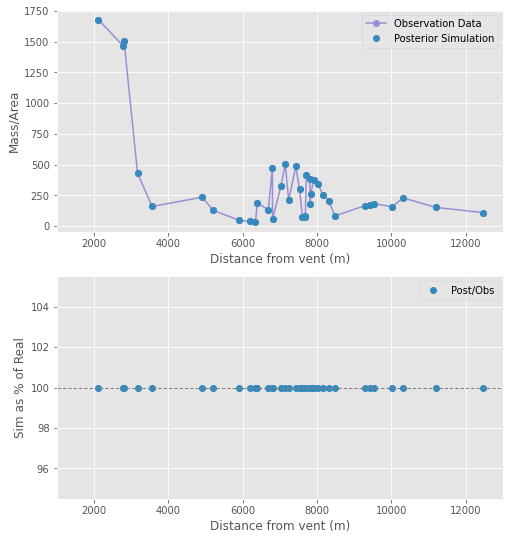

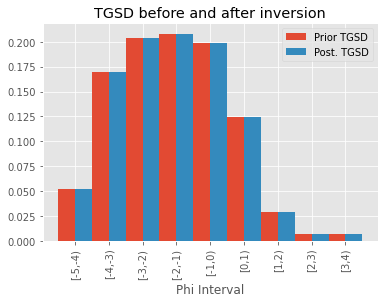

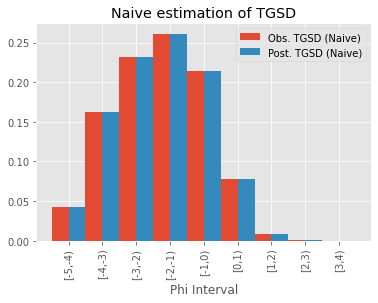

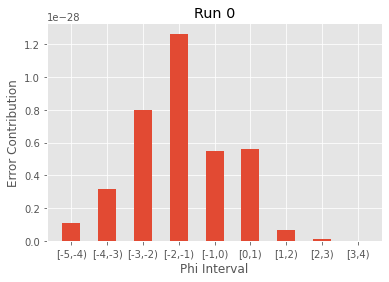

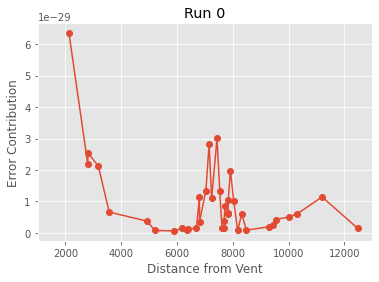

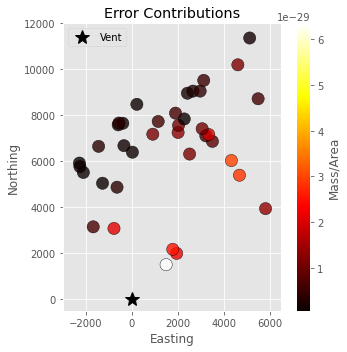

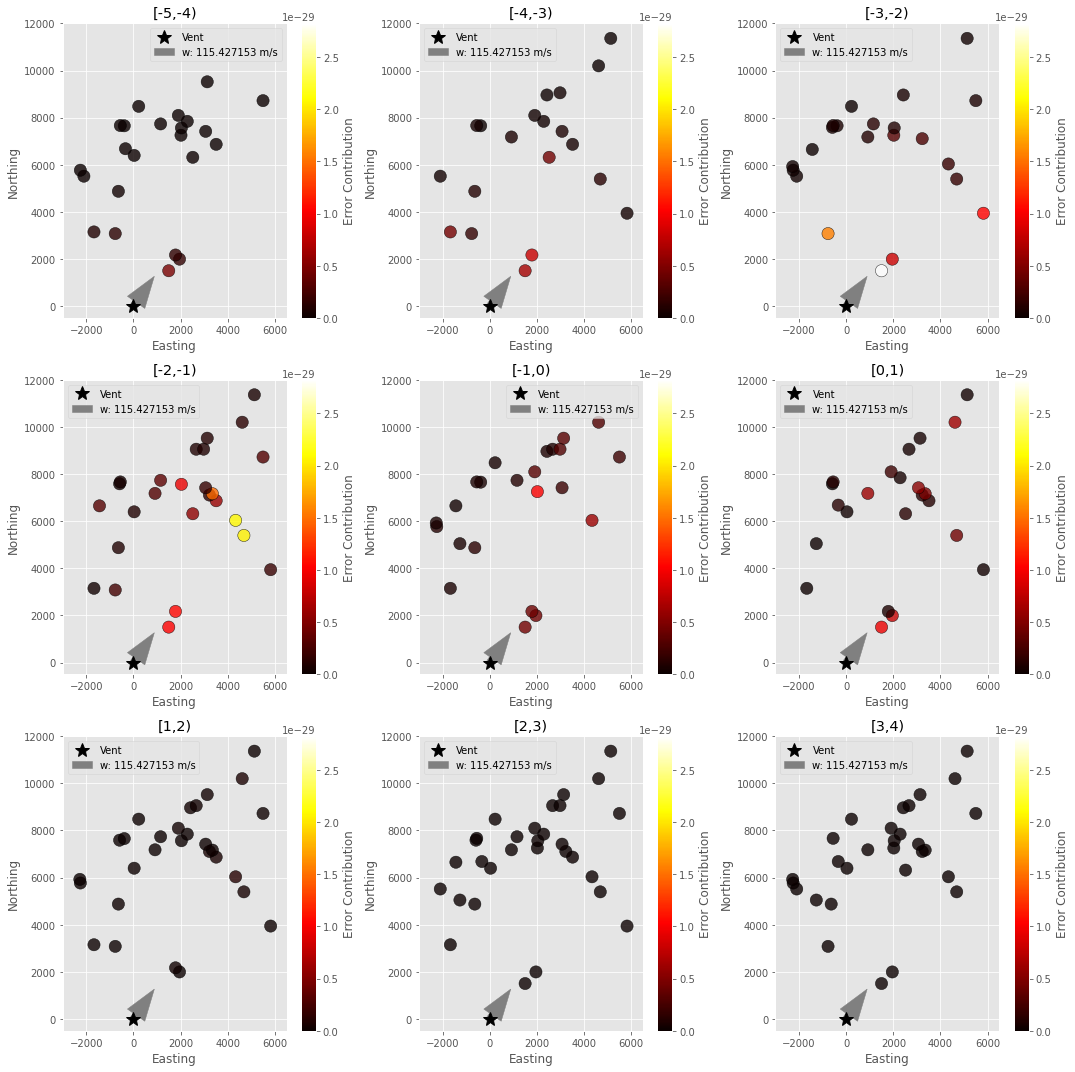

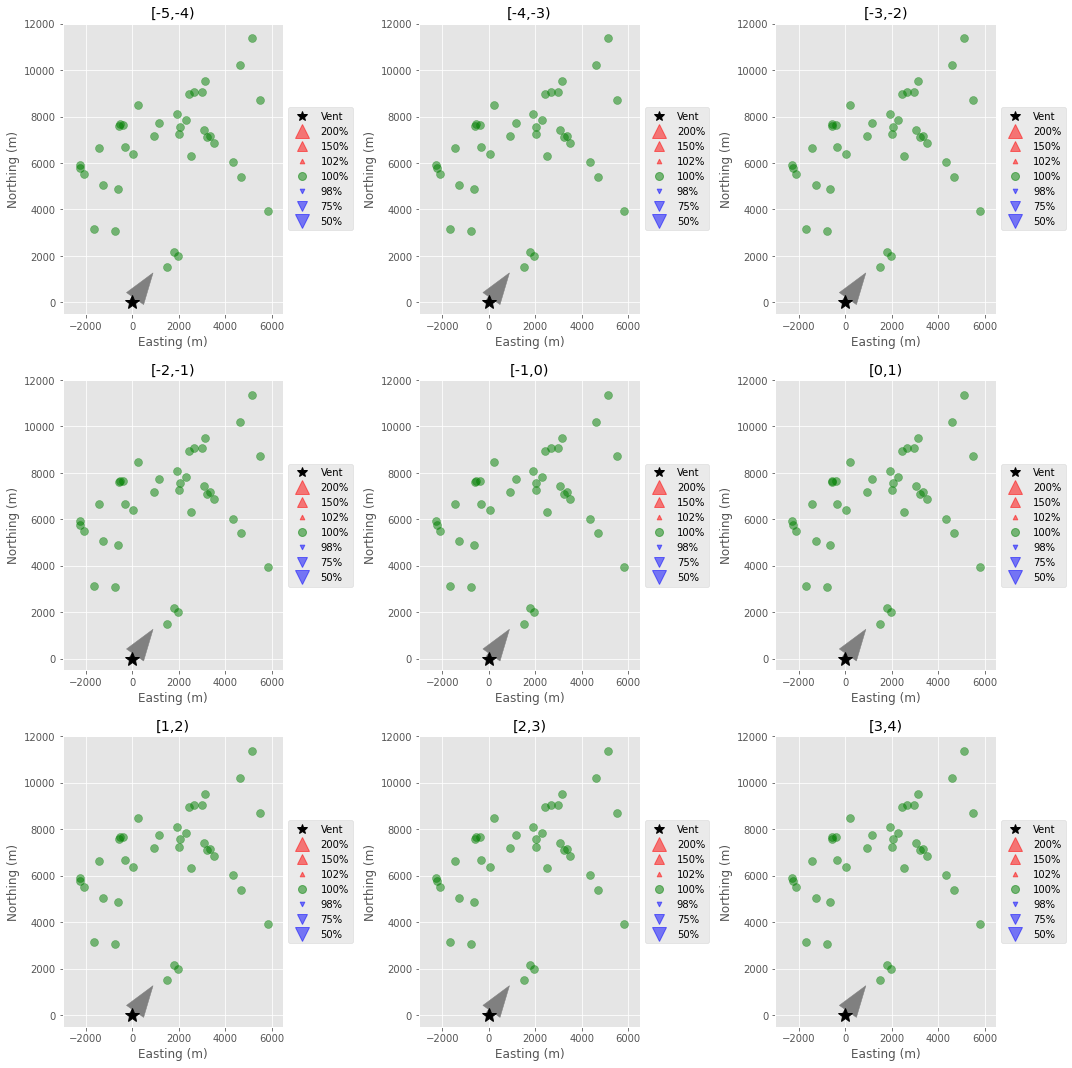

========Forward Sim========
{'a': 1.02, 'b': 1.56, 'h1': 24000.0, 'u': 5.735764363510461, 'v': 8.191520442889917, 'D': 4016.0, 'ftt': 6457.999999999996, 'eta': 0.0, 'zeta': 0.0} 55000000000.0


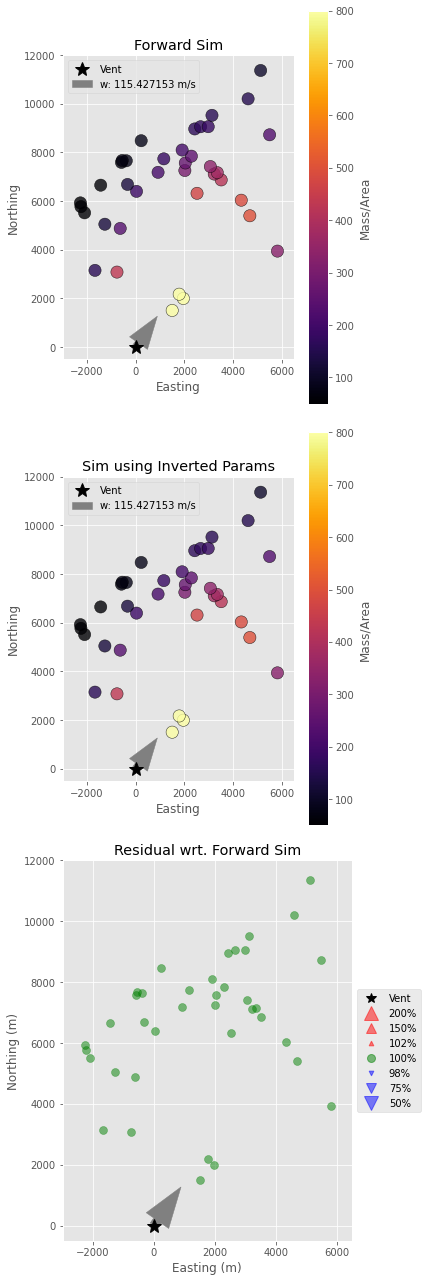

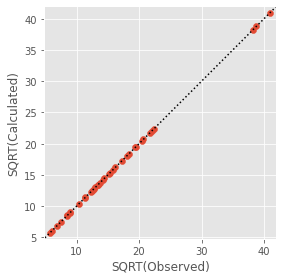

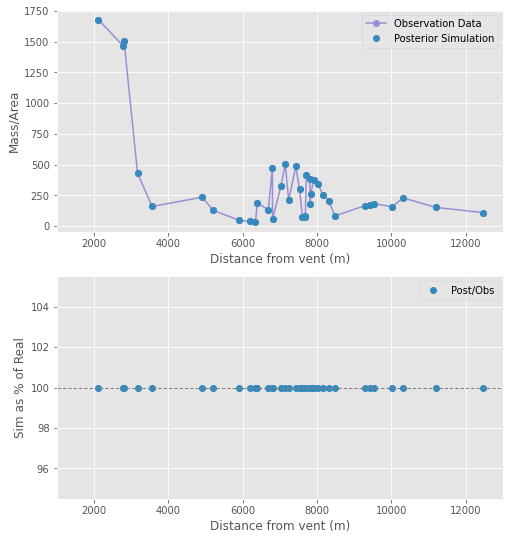

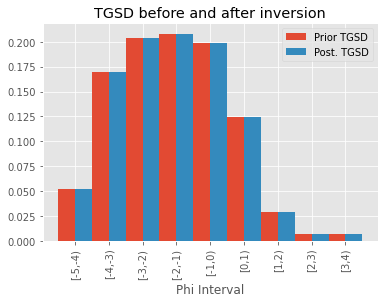

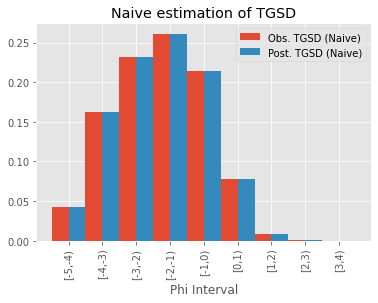

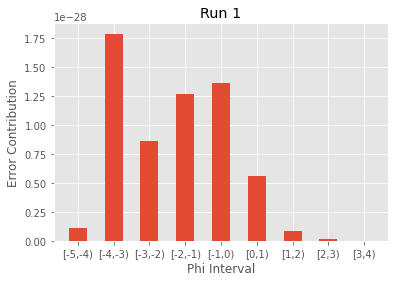

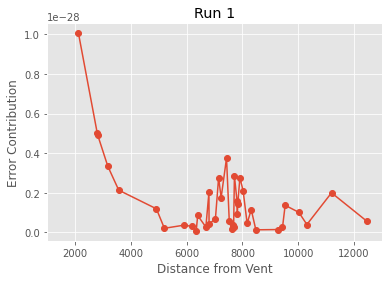

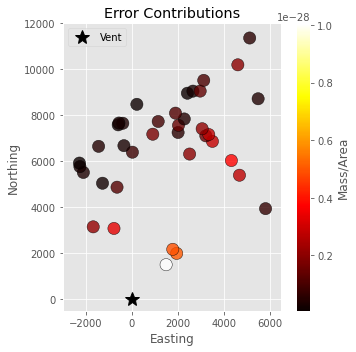

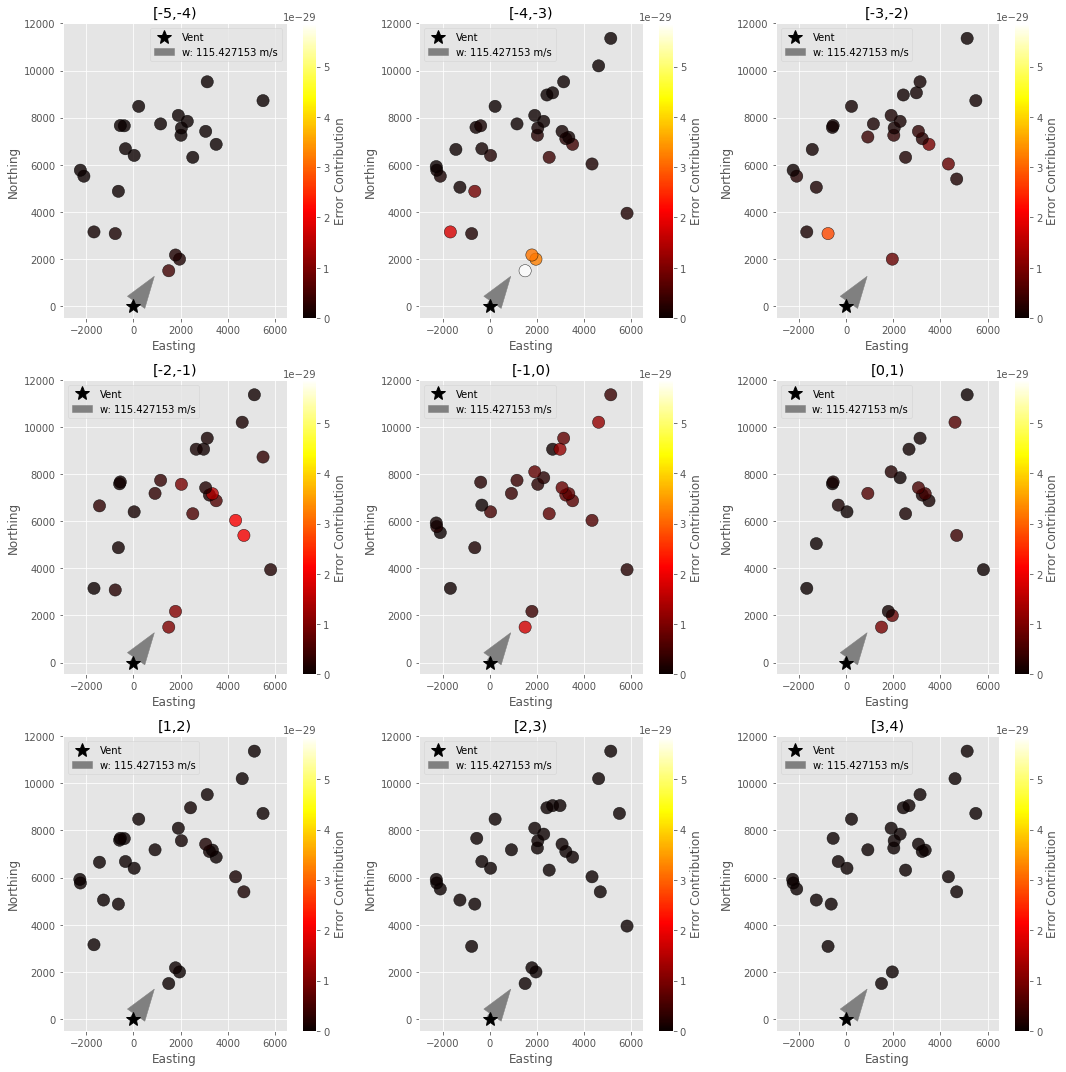

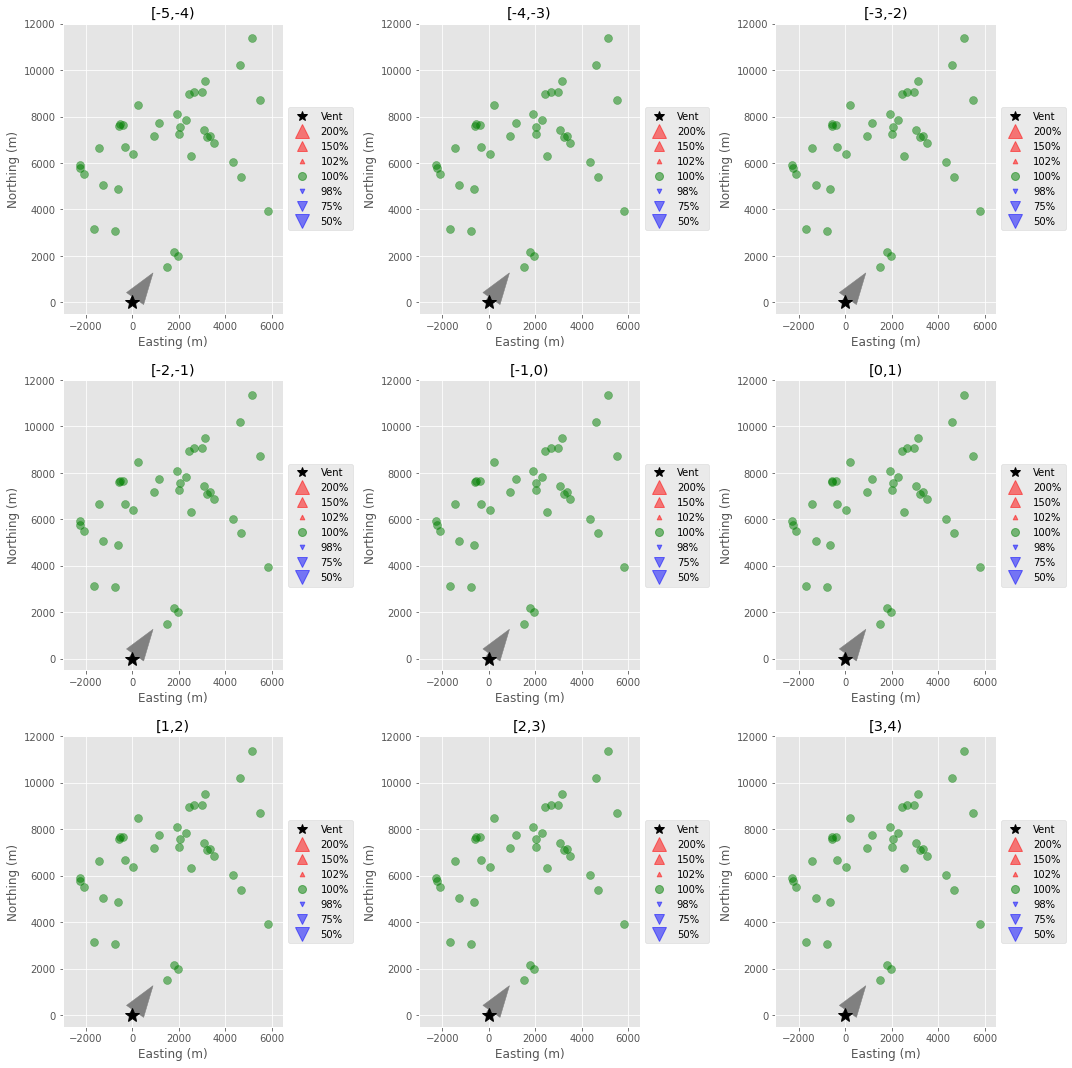

========T2 Const. Wind========
{'a': 1.0000000017903001, 'b': 1.5813534103813867, 'h1': 25681.595836594504, 'u': 5.665496381713227, 'v': 7.761343327799214, 'D': 4129.0013507853455, 'ftt': 6457.999999999996, 'eta': 0.0, 'zeta': 0.0} 55000000000.0


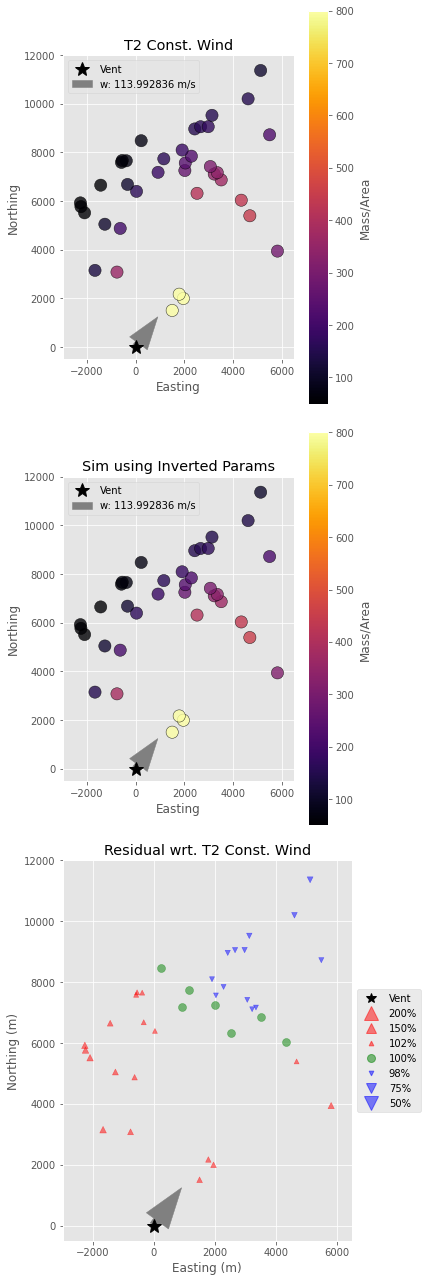

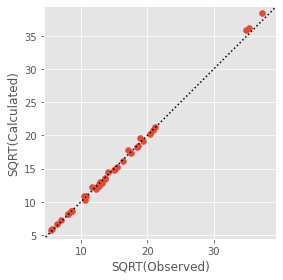

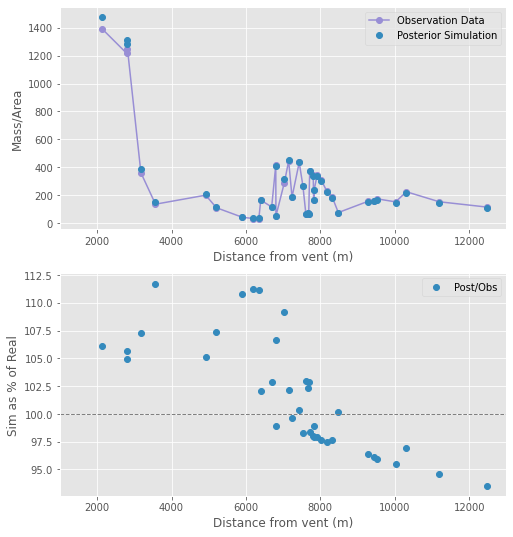

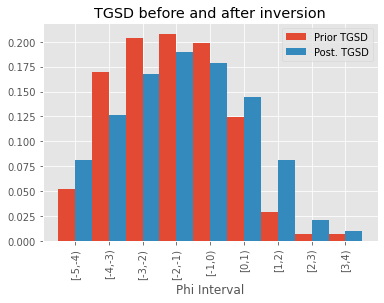

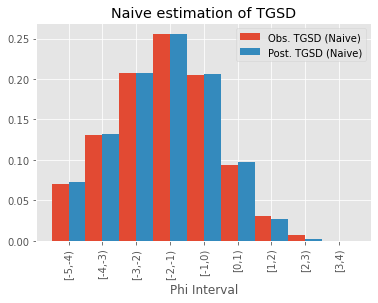

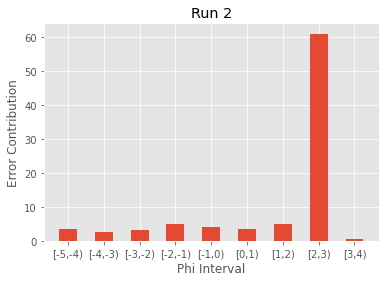

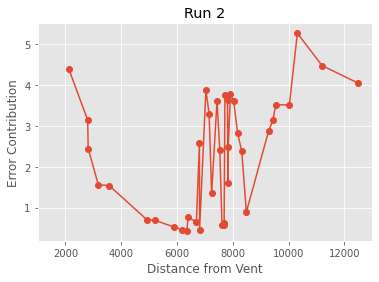

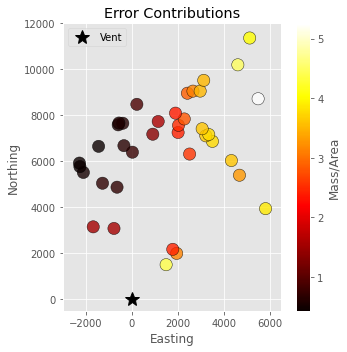

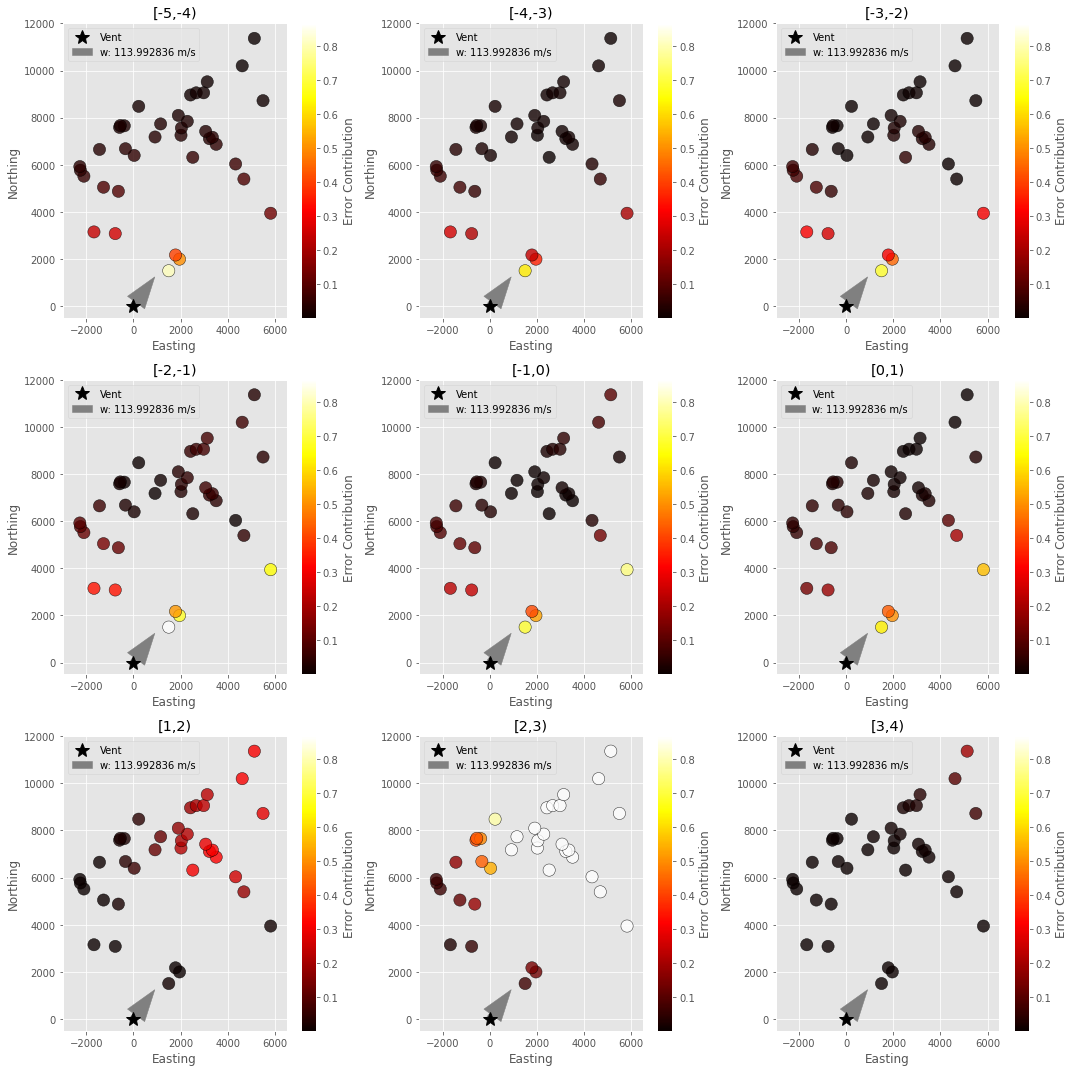

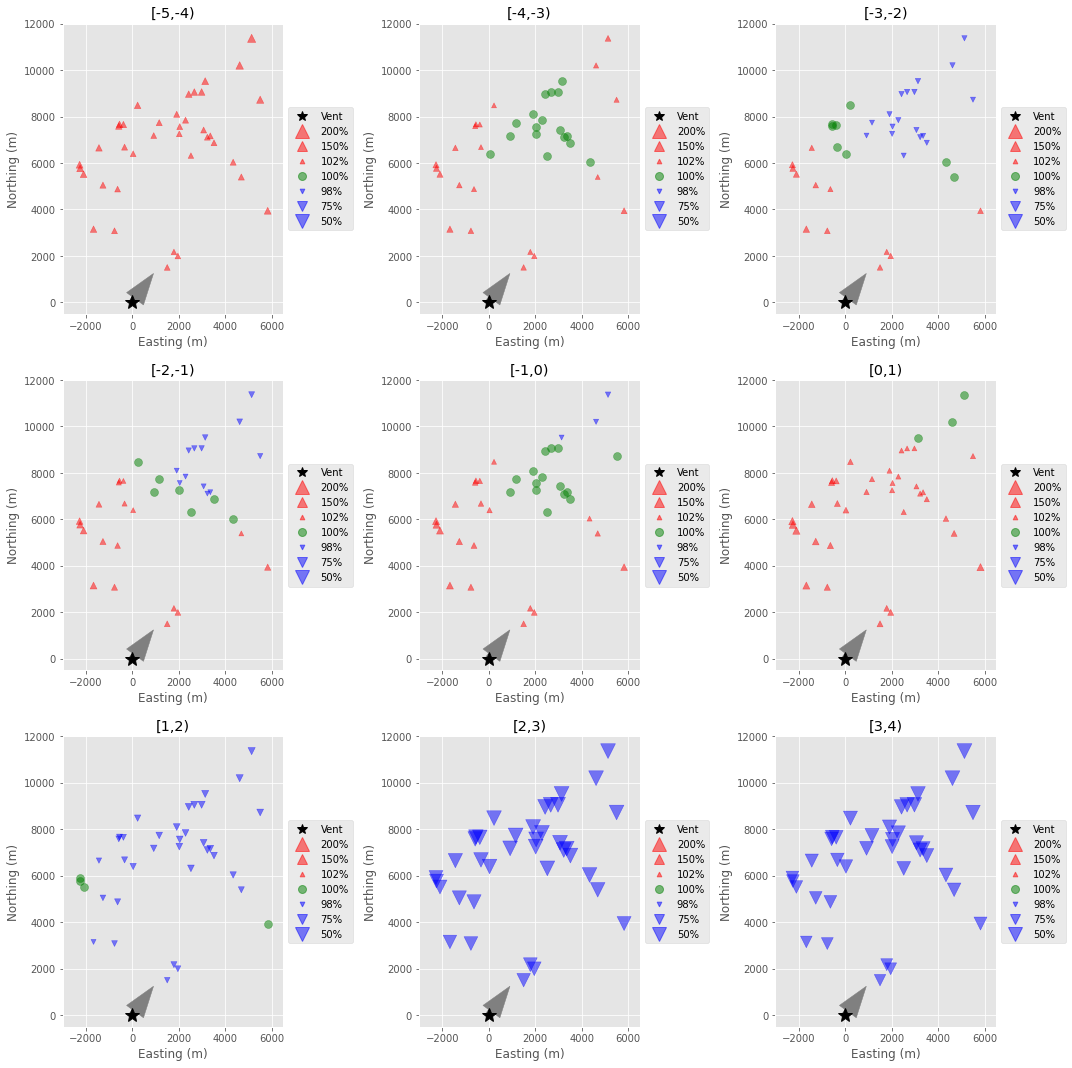

========T2 NOAA wind========
{'a': 1.000160119111683, 'b': 1.6990522659517449, 'h1': 38862.33974599371, 'u': 6.278425709883488, 'v': 7.925900777730534, 'D': 7355.648060536591, 'ftt': 6457.999999999996, 'eta': 0.0, 'zeta': 0.0} 55000000000.0


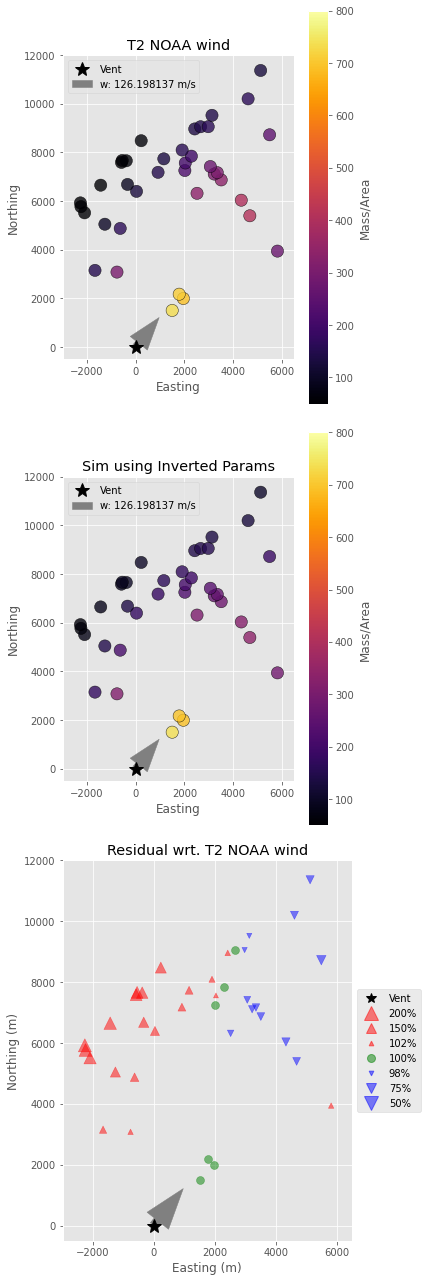

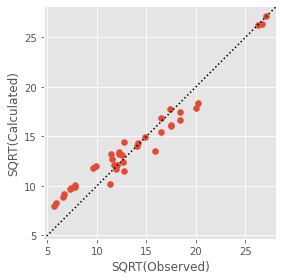

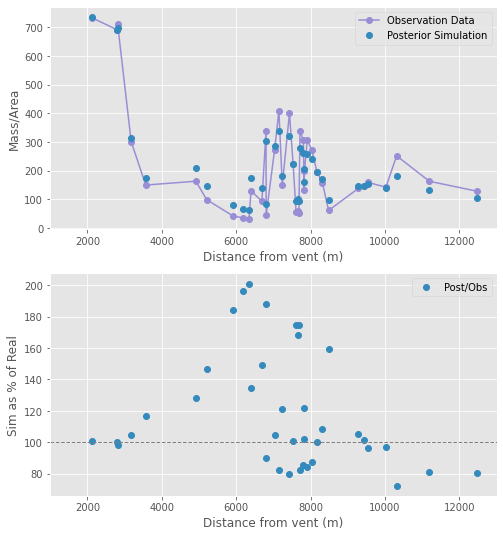

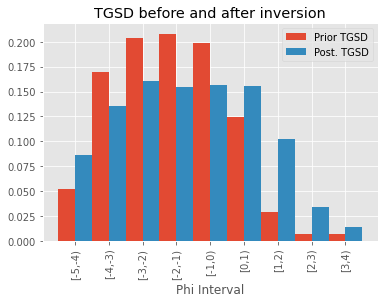

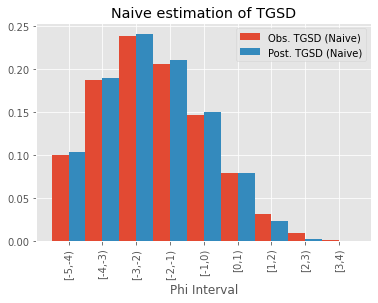

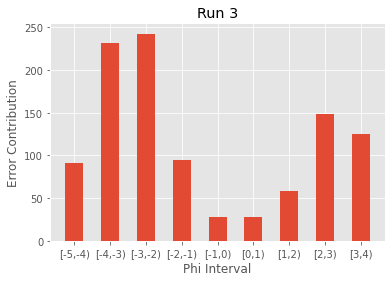

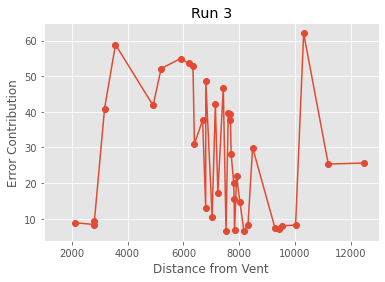

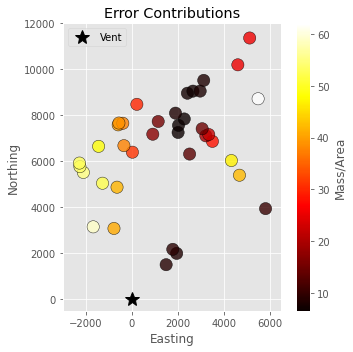

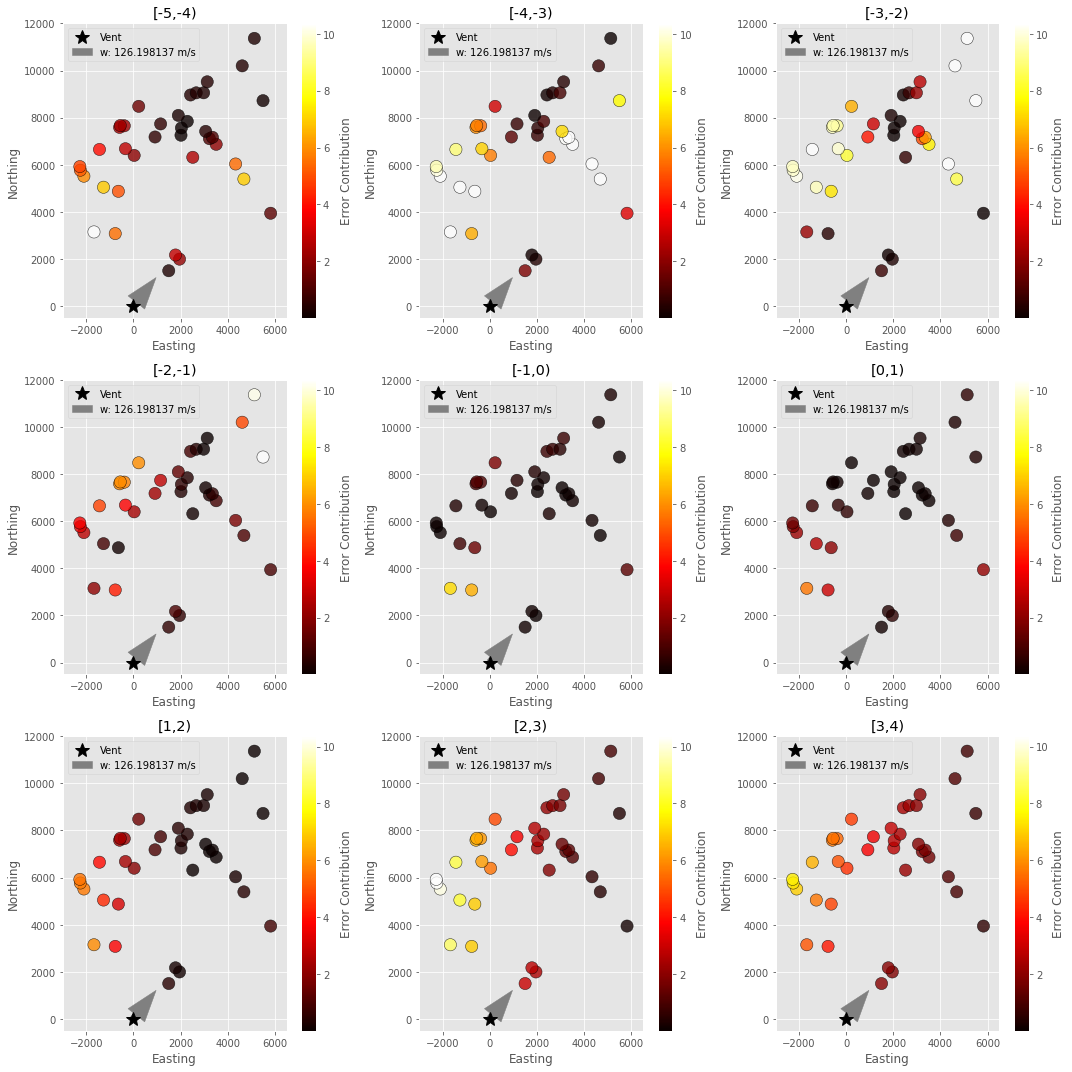

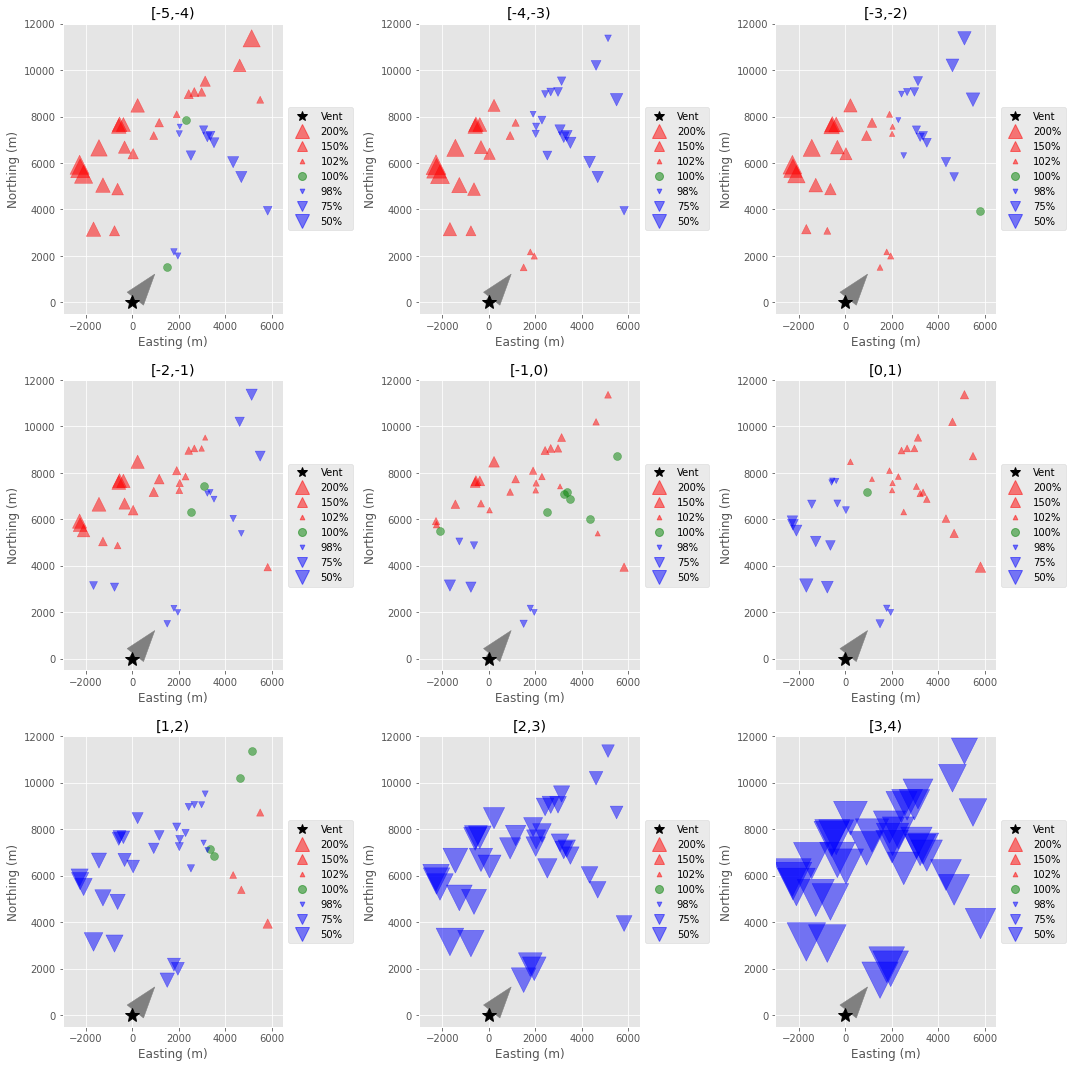

========Observation Data========
{'a': 1.0001080464299668, 'b': 1.236691308901935, 'h1': 40264.87184954602, 'u': 2.8676835440322437, 'v': 5.839160210446886, 'D': 7013.913578059632, 'ftt': 6457.999999999996, 'eta': 0.0, 'zeta': 0.0} 55000000000.0


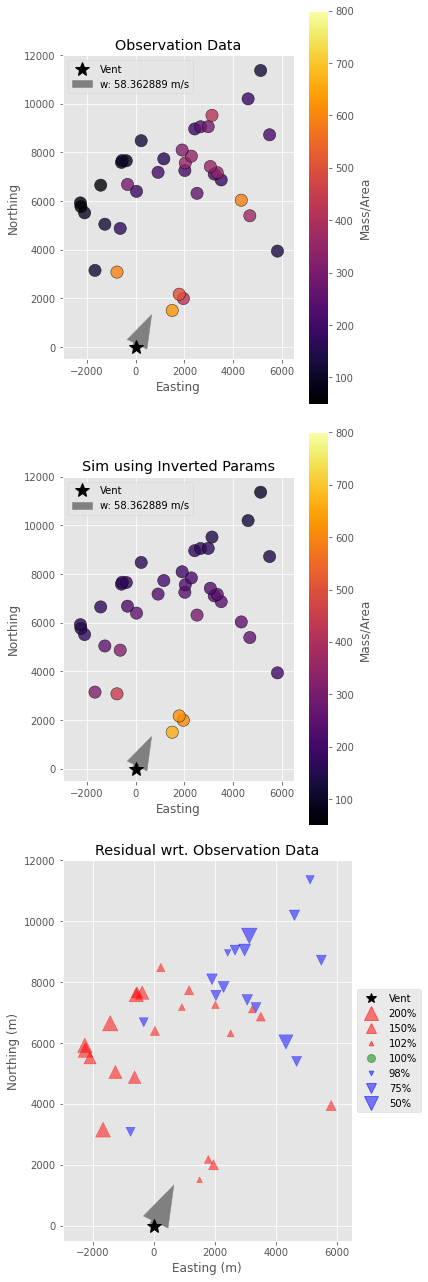

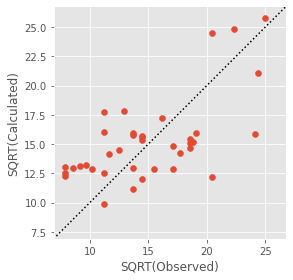

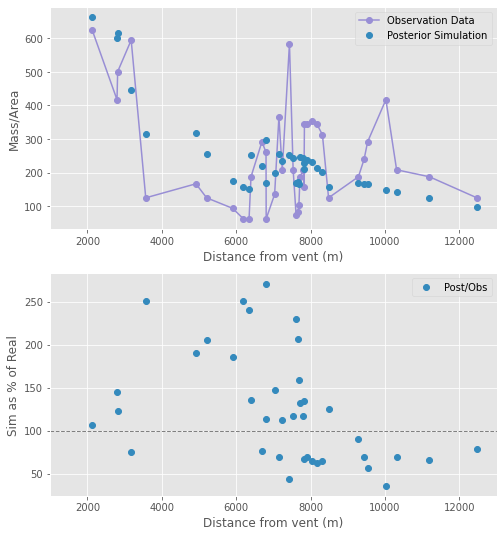

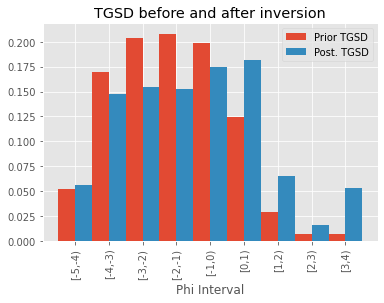

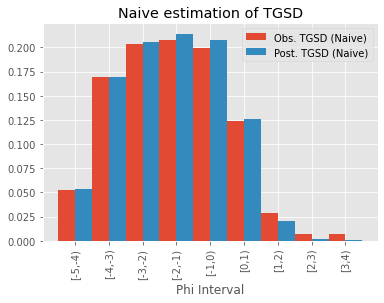

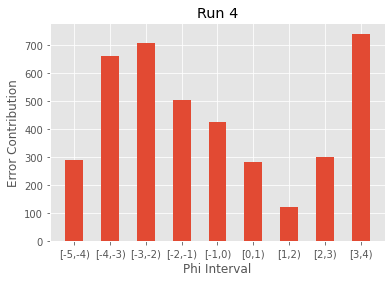

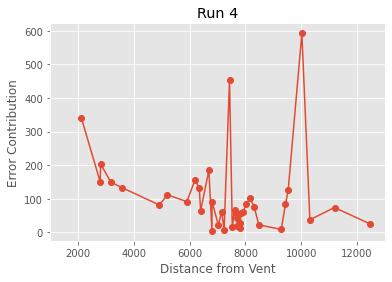

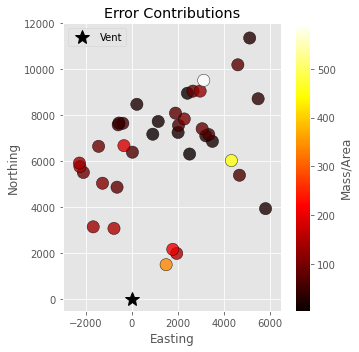

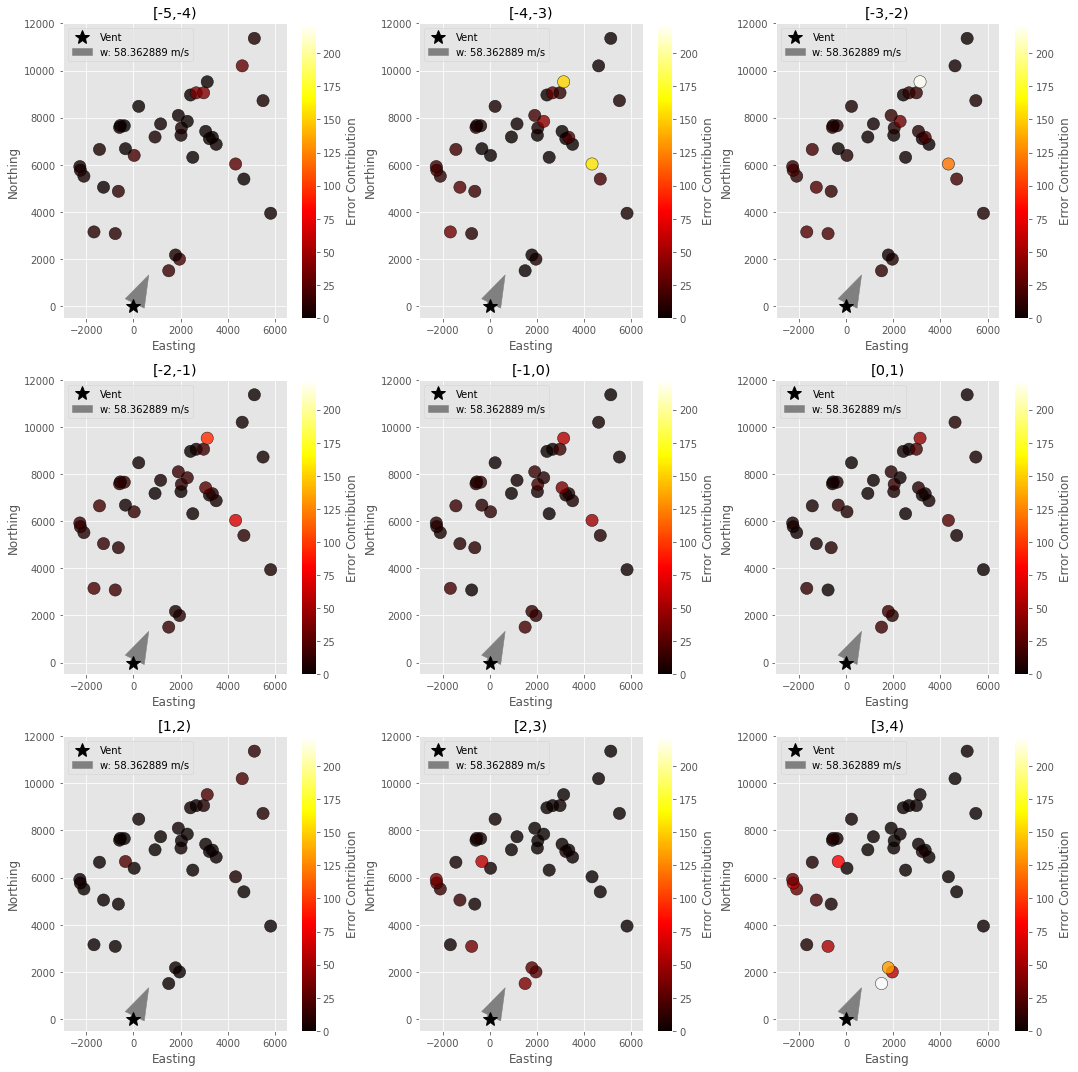

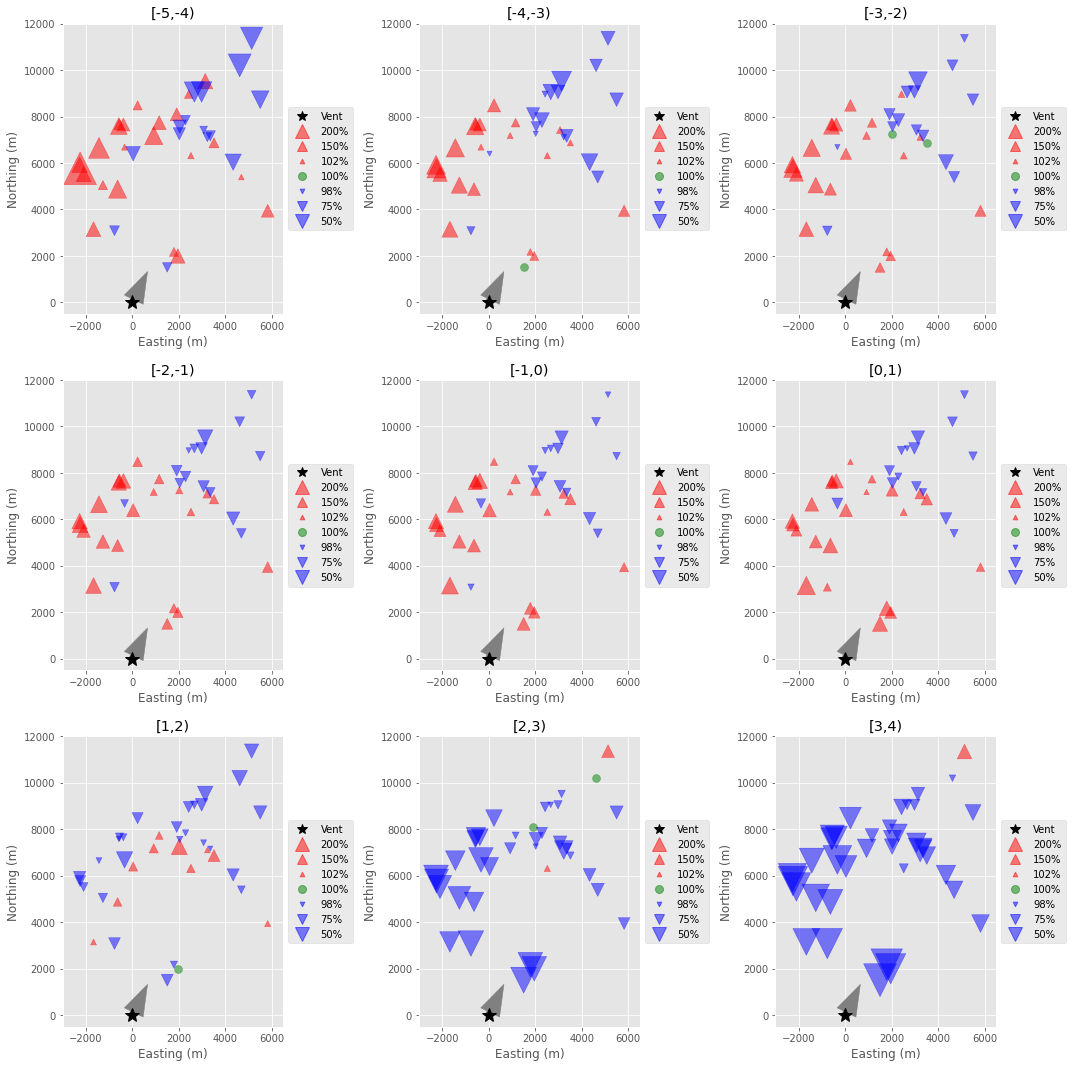

In [21]:
for i, name in enumerate(names):
    print("========%s========"%name)

    data = data_sets[i]
    
    print(params_list[i], mass_list[i])
    q_dist = beta(params["a"],params["b"])

    phi_new = copy.deepcopy(prior_phi_steps)
    for j, new_phi in enumerate(phi_new):
        new_phi["probability"] = tgsd_list[i][j]


    q_dist = beta(params["a"],params["b"])

    grid = data[["Easting", "Northing"]]


    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        params_list[i]["h1"], 2500, phi_new, (params_list[i]["a"],params_list[i]["b"]), 
        mass_list[i], 
        (params_list[i]["u"],params_list[i]["v"]), params_list[i]["D"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    if name == "No Inversion":
        data = post_df
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"].values/data["MassArea"].values


#     display(post_df)
    ####################### SPATIAL PLOTS
    fig, axs = plt.subplots(3,1, figsize=(
            6, 18), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    bounds=(50, 800)
    vis.plot_sample(data, vent=(0,0), log=False,bounds=bounds, 
                title=name, cbar_label="Mass/Area", ax=axs[0],
                   wind=(params_list[i]["u"]*20,params_list[i]["v"]*20))
    axs[0].set_xlim([-3000, 6500])
    axs[0].set_ylim([-500, 12000])
    vis.plot_sample(post_df, vent=(0,0), log=False, bounds=bounds,
                title="Sim using Inverted Params", cbar_label="Mass/Area", ax=axs[1],
                   wind=(params_list[i]["u"]*20,params_list[i]["v"]*20))
    axs[1].set_xlim([-3000, 6500])
    axs[1].set_ylim([-500, 12000])
    vis.plot_residuals(post_df, vent=(0,0), values="Residual", plot_type="size",
                title="Residual wrt. %s"%name, ax=axs[2],
                       wind=(params_list[i]["u"]*20,params_list[i]["v"]*20))
    axs[2].set_xlim([-3000, 6500])
    axs[2].set_ylim([-500, 12000])

    plt.tight_layout()
    plt.show()
    

    
    ################ EQUILINE PLOT
    
    min_mass = min((min(data["MassArea"].values), min(post_df["MassArea"].values)))
    max_mass = max((max(data["MassArea"].values), max(post_df["MassArea"].values)))

    fig, ax = plt.subplots(facecolor='w', edgecolor='k')
    ax.scatter(np.sqrt(data["MassArea"].values), np.sqrt(post_df["MassArea"].values))
    ax.plot([0,100],[0,100], "k:")
    ax.set_xlabel("SQRT(Observed)")
    ax.set_ylabel("SQRT(Calculated)")
    ax.set_aspect('equal', 'box')
    ax.set_xlim([np.sqrt(min_mass)-1, np.sqrt(max_mass)+1])
    ax.set_ylim([np.sqrt(min_mass)-1, np.sqrt(max_mass)+1])
    fig.tight_layout()
    plt.show()

    
    ################# DISTANCE PLOTS
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(data["radius"].values, data["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")
    axs[0].set_xlim(1000, 13000)

    axs[1].plot(post_df["radius"].values, post_df["Residual"].values*100, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")  
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    axs[1].set_xlim(1000, 13000)
    plt.show()
        


    ################# TGSD PLOTS

    old_tgsd = [phi["probability"].copy() for phi in prior_phi_steps]
    x = [phi["centroid"] for phi in prior_phi_steps]
    labels = [phi["interval"] for phi in prior_phi_steps]
    
    obs_tgsd = get_tgsd(data, prior_phi_steps)
    post_tgsd = get_tgsd(post_df, prior_phi_steps)
    
    
    
    fig, ax = plt.subplots(facecolor='w', edgecolor='k')
    ax.bar([xx-0.25 for xx in x], old_tgsd, width=0.5, align="center", label="Prior TGSD")
    ax.bar([xx+0.25 for xx in x], tgsd_list[i], width=0.5, align="center", label="Post. TGSD")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_xlabel("Phi Interval")
    plt.title("TGSD before and after inversion")
    plt.legend()
    
    plt.show()
    
    fig, ax = plt.subplots(facecolor='w', edgecolor='k')
    ax.bar([xx-0.25 for xx in x], obs_tgsd, width=0.5, align="center", label="Obs. TGSD (Naive)")
    ax.bar([xx+0.25 for xx in x], post_tgsd, width=0.5, align="center", label="Post. TGSD (Naive)")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_xlabel("Phi Interval")
    plt.title("Naive estimation of TGSD")
    plt.legend()
    
    plt.show()
    
    ################# ERROR CONTRIBUTION PLOTS
    
    new_steps = copy.deepcopy(prior_phi_steps)
    for j, phi in enumerate(new_steps):
        phi["probability"] = tgsd_list[i][j]

    misfit, contributions, setup = get_error_contributions(
        data, len(data), int(config["INV_STEPS"]), 
        config["VENT_ELEVATION"], config["THEO_MAX_COL"], 2500, new_steps, 
        params_list[i], mass_list[i], column_cap = config["THEO_MAX_COL"], debug=False)
    
    point_contributions = np.sum(contributions, 0)
    phi_contributions = np.sum(contributions, 1)
    
    #### Phi Error Contributions
    fig, ax = plt.subplots(facecolor='w', edgecolor='k')
    ax.bar(x, phi_contributions, width=0.5, align="center")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.xlabel("Phi Interval")
    plt.ylabel("Error Contribution")
    plt.title("Run %d"%i)
    plt.show()
    
    #### Distance Error Contributions
    fig, ax = plt.subplots(facecolor='w', edgecolor='k')
    ax.plot(data["radius"], point_contributions, "C0o-")
    plt.xlabel("Distance from Vent")
    plt.ylabel("Error Contribution")
    plt.title("Run %d"%i)
    ax.set_xlim(1000, 13000)
    plt.show()
    
    #### Spatial Error Contributions
    data["Contributions"] = point_contributions
    fig, ax = plt.subplots(1, 1, figsize=(5,5), facecolor='w', edgecolor='k')

    vis.plot_sample(data, vent=(0,0), log=False, values="Contributions",
                title="Error Contributions", cbar_label="Mass/Area", ax = ax, cmap="hot")
    ax.set_xlim([-3000, 6500])
    ax.set_ylim([-500, 12000])
    plt.tight_layout()
    plt.show()
#      bounds=(min(min(contributions)),max(max(contributions))),
    #### Phi and Spatial Error Contributions
    fig, axs = plt.subplots(3, 3, figsize=(15,15), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for j, phi_cont in enumerate(phi_contributions):
        data["Contributions"] = contributions[j]
#         display(data[["Contributions", "MassArea"]])
        vis.plot_sample(data, vent=(0,0), log=False, values="Contributions", 
                        bounds=(min(min(contributions)),max(max(contributions))),
                        title=phi_new[j]["interval"], cbar_label="Error Contribution", 
                        ax = axs[j], cmap="hot", 
                        wind=(params_list[i]["u"]*20,params_list[i]["v"]*20))
        axs[j].set_xlim([-3000, 6500])
        axs[j].set_ylim([-500, 12000])
    plt.tight_layout()
    plt.show()

    #################### PHI AND SPATIAL RESIDUALS
    fig, axs = plt.subplots(3, 3, figsize=(15,15), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for j, phi_step in enumerate(phi_new):
        post_df["mass_res"] = (post_df["MassArea"].values*(post_df[phi_step["interval"]].values/100))/\
                             (data["MassArea"].values*(data[phi_step["interval"]].values/100))
        vis.plot_residuals(post_df, vent=(0,0), values="mass_res", plot_type="size",
                        title=prior_phi_steps[j]["interval"],  
                        ax = axs[j]
                          , wind=(params_list[i]["u"]*20,params_list[i]["v"]*20))
        axs[j].set_xlim([-3000, 6500])
        axs[j].set_ylim([-500, 12000])
    plt.tight_layout()
    plt.show()

## Prior Distributions

Here we can define prior distributions to be used in the inversion. These will passed to the sampler using the `param_config` dict below.



In [22]:
def col_truncnorm(mean, top=config["THEO_MAX_COL"]):
    bottom = 5000
    std = (top - bottom)/4
    standard_a, standard_b = (bottom - mean) / std, (top - mean) / std
    return truncnorm.rvs(standard_a, standard_b, loc=mean, scale=std)

def lognorm(prior, bottom=0):
    std_norm = norm.rvs()
    std_lognorm = np.exp(std_norm)
    lognorm = bottom + (prior-bottom)*std_lognorm
    return lognorm

def normal(prior):
    std_norm = norm.rvs()
    normal = prior*std_norm
    return normal

def uninformed(bottom, top):
    unif = uniform.rvs(loc = bottom, scale = (top-bottom))
    return unif


## Parameter Configuration

Here configure the inversion parameters. 

- `"value"` is a list of distribution parameters used in the sample function. These will be splat into the sample function during sampling, so they need to be in the correct order. 
- `"invert"` is a boolean value indicating if the parameter should be inverted or not. If True, the parameter will be optimized during the downhill-simplex phase. Otherwise the parameter will be kept fixed.
- `"sample_function"` is the prior distribution to sample from during the initial sampling phase. These are chosen from the above list. 

value invert  \
a                       [1.01, 5]   True   
b                       [1.01, 5]   True   
h1                [5000, 44915.0]   True   
u                         [0, 10]   True   
v                         [0, 10]   True   
D     [3229.0, 9041.199999999999]   True   
ftt               [6458.0, 10000]  False   
eta                        [0, 0]  False   
zeta                       [0, 0]  False   

                              sample_function  
a     <function uninformed at 0x7f936d24b3a0>  
b     <function uninformed at 0x7f936d24b3a0>  
h1    <function uninformed at 0x7f936d24b3a0>  
u     <function uninformed at 0x7f936d24b3a0>  
v     <function uninformed at 0x7f936d24b3a0>  
D     <function uninformed at 0x7f936d24b3a0>  
ftt   <function uninformed at 0x7f936d24b3a0>  
eta   <function uninformed at 0x7f936d24b3a0>  
zeta  <function uninformed at 0x7f936d24b3a0>

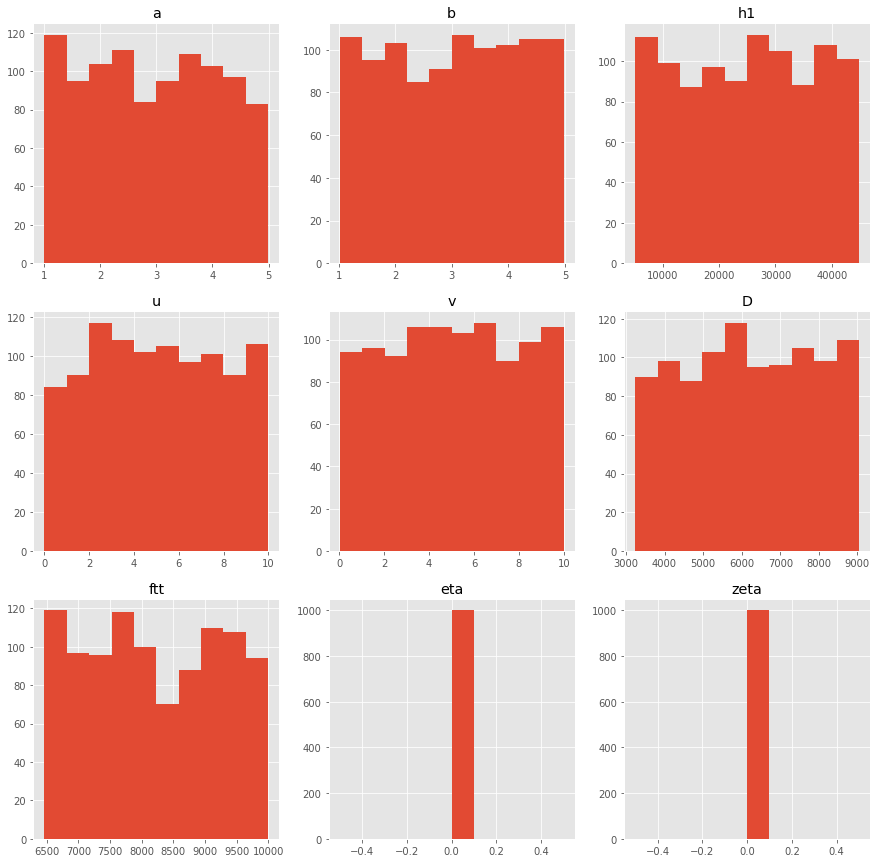

In [23]:
param_config = {
    "a": {
        "value":[1.01, 5],
        "invert":True,
        "sample_function": uninformed
    },
    "b": {
        "value":[1.01, 5],
        "invert":True,
        "sample_function": uninformed
    },
    "h1": {
        "value":[5000, config["THEO_MAX_COL"]],
        "invert":True,
        "sample_function": uninformed
    },
    "u": {
        "value":[0, 10],
        "invert":True,
        "sample_function": uninformed
    },
    "v": {
        "value":[0, 10],
        "invert":True,
        "sample_function": uninformed
    },
    "D": {
        "value":[0.5*config["FALL_TIME_THRESHOLD"], 1.4*config["FALL_TIME_THRESHOLD"]],
        "invert":True,
        "sample_function": uninformed
    },
    "ftt": {
        "value":[config["FALL_TIME_THRESHOLD"], 10000],
        "invert":False,
        "sample_function": uninformed
    },
    "eta": {
        "value":[0, 0],
        "invert":False,
        "sample_function": uninformed
    },
    "zeta": {
        "value":[0, 0],
        "invert":False,
        "sample_function": uninformed
    },
}



# I TESTED SOME FIXED PARAMETER RUNS HERE. 

# full_inversion_priors = {
#     "a": 1.00002,
#     "b": 1.13405,
#     "h1": 44908,
#     "u": 2.60482,
#     "v": 5.33615,
#     "D": 5999.9,
#     "ftt": 6458,
#     "eta": 2.34894,
#     "zeta": 0
# }

# phi_probs = [
#     0.058657896918929336,
#     0.15114329504320803,
#     0.15644352749157492,
#     0.15138125134809738,
#     0.17100876050061856,
#     0.1814490666782764,
#     0.06799943098150356,
#     0.01682410991463832,
#     0.045092661123153584
# ]
# param_config = {
#     "a": {
#         "value":[full_inversion_priors["a"], 5],
#         "invert":False,
#         "sample_function": uninformed
#     },
#     "b": {
#         "value":[full_inversion_priors["b"], 5],
#         "invert":False,
#         "sample_function": uninformed
#     },
#     "h1": {
#         "value":[full_inversion_priors["h1"], config["THEO_MAX_COL"]],
#         "invert":False,
#         "sample_function": uninformed
#     },
#     "u": {
#         "value":[full_inversion_priors["u"], 10],
#         "invert":False,
#         "sample_function": uninformed
#     },
#     "v": {
#         "value":[full_inversion_priors["v"], 10],
#         "invert":False,
#         "sample_function": uninformed
#     },
#     "D": {
#         "value":[full_inversion_priors["D"], 6000],
#         "invert":False,
#         "sample_function": uninformed
#     },
#     "ftt": {
#         "value":[config["FALL_TIME_THRESHOLD"], 10000],
#         "invert":False,
#         "sample_function": uninformed
#     },
#     "eta": {
#         "value":[0, 0],
#         "invert":False,
#         "sample_function": uninformed
#     },
#     "zeta": {
#         "value":[0, 0],
#         "invert":False,
#         "sample_function": uninformed
#     },
# }
param_config_df = pd.DataFrame(param_config)
display(param_config_df.T)

fig, axs = plt.subplots(3, 3, figsize=(15,15), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, (key, val) in enumerate(param_config.items()):
    x = [val["sample_function"](*val["value"]) for i in range(1000)]
    axs[i].hist(x)
    axs[i].set_title(key)
plt.show()



## Prior TGSD setup

Here we set up the prior TGSD. Normally we would use either a Naive estimation of the TGSD, or a uniform prior, as a starting point for the inversion. 

Here we can also drop any phi classes that we do not wish to include in the inversion.

In [24]:
data_set = obs_df


tgsd = get_tgsd(data_set, naive_phi_steps)
prior_phi_steps = copy.deepcopy(naive_phi_steps)
for i, phi in enumerate(prior_phi_steps):
#     phi["probability"] = 1/8
    phi["probability"] = tgsd[i]

# Drop two fines classes
del prior_phi_steps[-1]
del prior_phi_steps[-1]

display(prior_phi_steps)

[{'lower': -5,
  'upper': -4.0,
  'interval': '[-5,-4)',
  'centroid': -4.5,
  'density': 1024.0,
  'probability': 0.052316431318540024},
 {'lower': -4.0,
  'upper': -3.0,
  'interval': '[-4,-3)',
  'centroid': -3.5,
  'density': 1024.0,
  'probability': 0.1694506511837887},
 {'lower': -3.0,
  'upper': -2.0,
  'interval': '[-3,-2)',
  'centroid': -2.5,
  'density': 1024.0,
  'probability': 0.20390996005463202},
 {'lower': -2.0,
  'upper': -1.0,
  'interval': '[-2,-1)',
  'centroid': -1.5,
  'density': 1024.0,
  'probability': 0.2080930801364657},
 {'lower': -1.0,
  'upper': 0.0,
  'interval': '[-1,0)',
  'centroid': -0.5,
  'density': 1024.0,
  'probability': 0.19893821897376404},
 {'lower': 0.0,
  'upper': 1.0,
  'interval': '[0,1)',
  'centroid': 0.5,
  'density': 1233.5,
  'probability': 0.12429352702169855},
 {'lower': 1.0,
  'upper': 2.0,
  'interval': '[1,2)',
  'centroid': 1.5,
  'density': 1443.0,
  'probability': 0.028938961877603735}]

## Inversion

Here we run the full inversion scheme. This consists of running multiple repeated inversions that can be compared in detail using the diagnostics in the following cell.

See the documentation for the `gaussian_stack_multi_run` function for details on the input parameters. 

Run 0===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 24216.7,	 Post Misfit: 2188.39


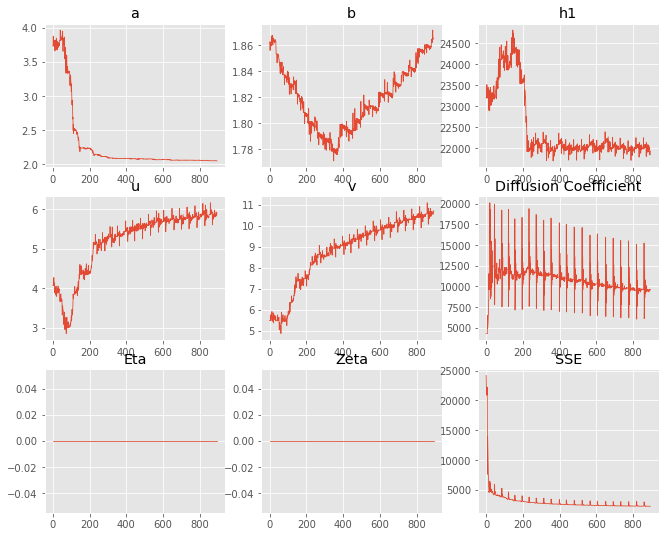

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     3.73102 │      2.05351 │
├──────┼─────────────┼──────────────┤
│ b    │     1.86215 │      1.86459 │
├──────┼─────────────┼──────────────┤
│ h1   │ 23190.1     │  21912.7     │
├──────┼─────────────┼──────────────┤
│ u    │     4.06746 │      5.87508 │
├──────┼─────────────┼──────────────┤
│ v    │     5.47907 │     10.6535  │
├──────┼─────────────┼──────────────┤
│ D    │  4280.65    │   9569.85    │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 1 Time: 1.511 minutes


Estimated remaining run time: 13.603 minutes


Run 1===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 23427.5,	 Post Misfit: 2419.03


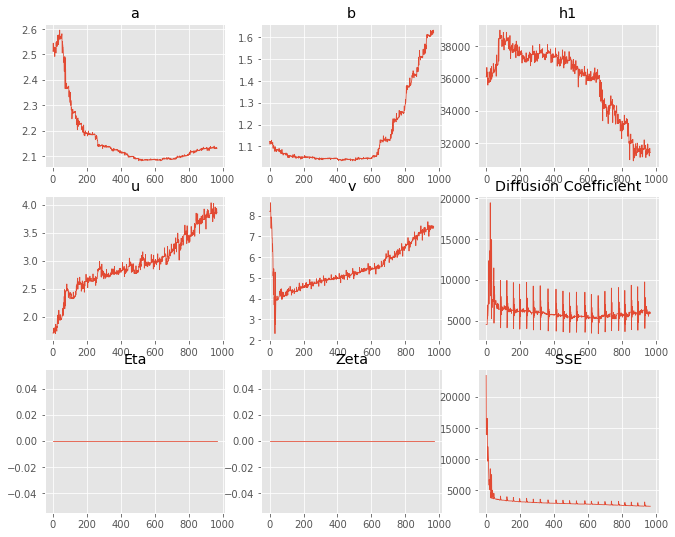

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     2.51232 │      2.13117 │
├──────┼─────────────┼──────────────┤
│ b    │     1.12186 │      1.62297 │
├──────┼─────────────┼──────────────┤
│ h1   │ 36099.6     │  31406.5     │
├──────┼─────────────┼──────────────┤
│ u    │     1.71223 │      3.85392 │
├──────┼─────────────┼──────────────┤
│ v    │     8.21358 │      7.46017 │
├──────┼─────────────┼──────────────┤
│ D    │  4546.45    │   5982.22    │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 2 Time: 1.665 minutes


Estimated remaining run time: 18.001 minutes


Run 2===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 7766.75,	 Post Misfit: 1760.19


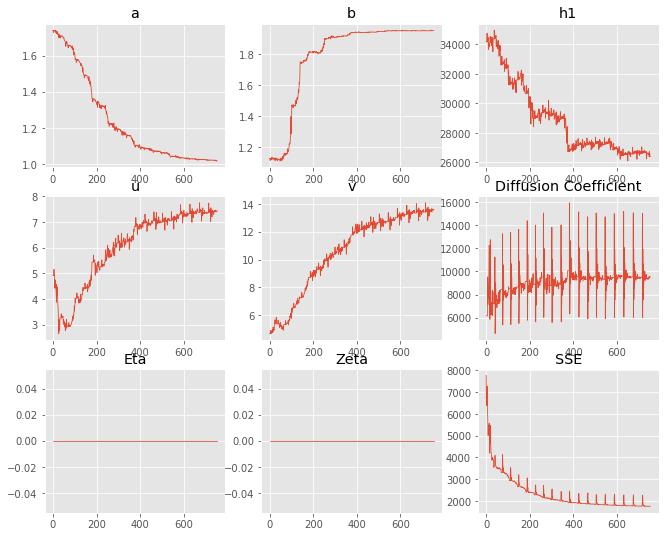

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     1.7387  │      1.01818 │
├──────┼─────────────┼──────────────┤
│ b    │     1.12845 │      1.95147 │
├──────┼─────────────┼──────────────┤
│ h1   │ 34175.3     │  26392.5     │
├──────┼─────────────┼──────────────┤
│ u    │     4.91473 │      7.43565 │
├──────┼─────────────┼──────────────┤
│ v    │     4.66557 │     13.6145  │
├──────┼─────────────┼──────────────┤
│ D    │  6160.34    │   9561.67    │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 3 Time: 1.293 minutes


Estimated remaining run time: 17.877 minutes


Run 3===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 59441.2,	 Post Misfit: 2367.95


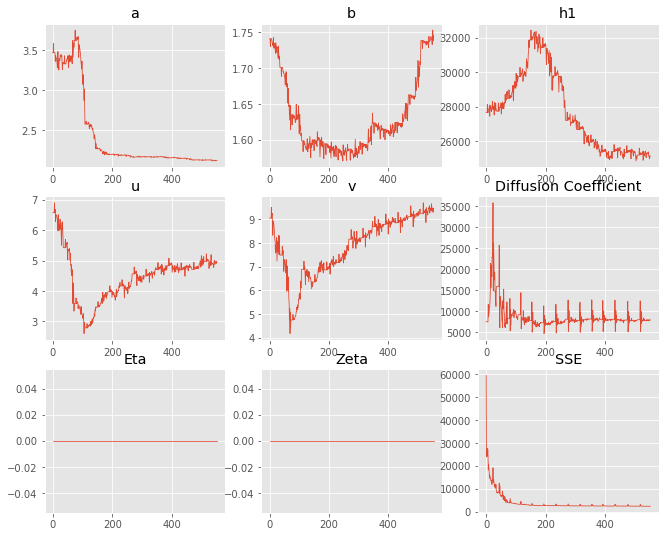

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     3.46652 │      2.12186 │
├──────┼─────────────┼──────────────┤
│ b    │     1.74125 │      1.74614 │
├──────┼─────────────┼──────────────┤
│ h1   │ 27659.5     │  25100.6     │
├──────┼─────────────┼──────────────┤
│ u    │     6.57455 │      4.95512 │
├──────┼─────────────┼──────────────┤
│ v    │     9.05806 │      9.46412 │
├──────┼─────────────┼──────────────┤
│ D    │  7433.92    │   7879.9     │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 4 Time: 0.944 minutes


Estimated remaining run time: 16.239 minutes


Run 4===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 8024.66,	 Post Misfit: 1759.88


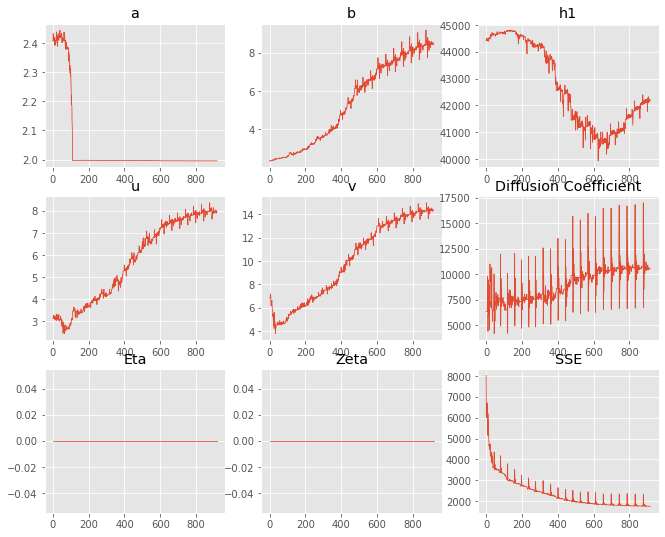

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     2.40749 │      1.99551 │
├──────┼─────────────┼──────────────┤
│ b    │     2.35785 │      8.49172 │
├──────┼─────────────┼──────────────┤
│ h1   │ 44409.2     │  42155       │
├──────┼─────────────┼──────────────┤
│ u    │     3.12706 │      7.97244 │
├──────┼─────────────┼──────────────┤
│ v    │     6.84013 │     14.3629  │
├──────┼─────────────┼──────────────┤
│ D    │  6322.75    │  10569.4     │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 5 Time: 1.610 minutes


Estimated remaining run time: 16.388 minutes


Run 5===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 86756.9,	 Post Misfit: 1746.89


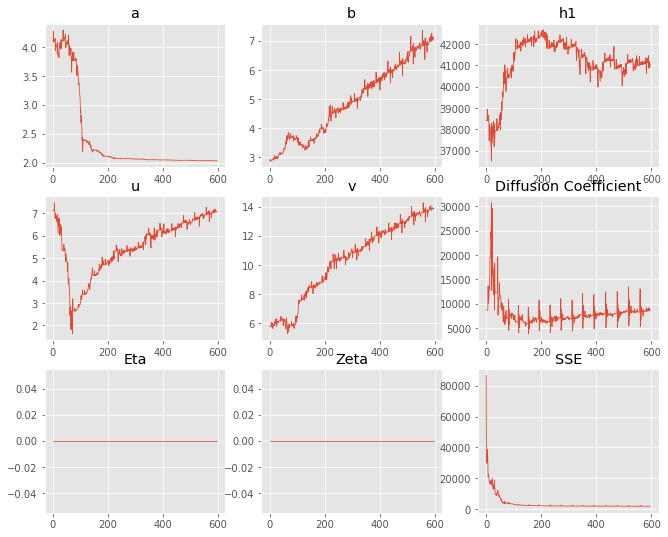

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     4.08997 │      2.03147 │
├──────┼─────────────┼──────────────┤
│ b    │     2.87867 │      7.07812 │
├──────┼─────────────┼──────────────┤
│ h1   │ 38415.4     │  41033.2     │
├──────┼─────────────┼──────────────┤
│ u    │     7.1124  │      7.07398 │
├──────┼─────────────┼──────────────┤
│ v    │     5.76555 │     13.8695  │
├──────┼─────────────┼──────────────┤
│ D    │  8692.74    │   8629.75    │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 6 Time: 1.069 minutes


Estimated remaining run time: 15.029 minutes


Run 6===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 8200.89,	 Post Misfit: 1768.76


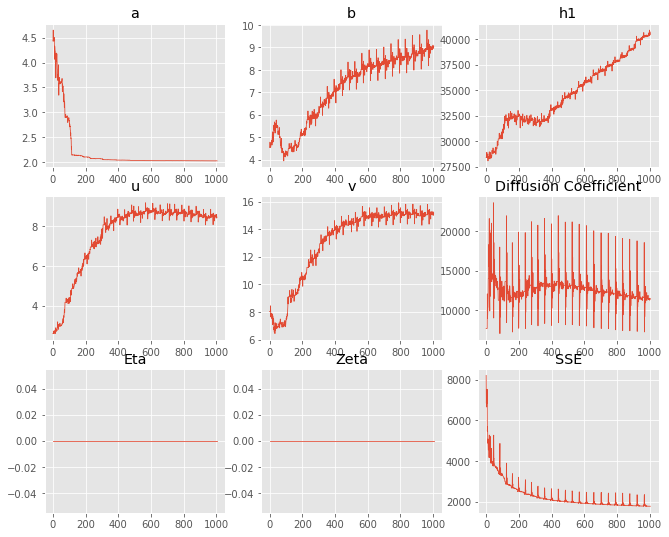

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     4.4342  │      2.02278 │
├──────┼─────────────┼──────────────┤
│ b    │     4.54965 │      9.02554 │
├──────┼─────────────┼──────────────┤
│ h1   │ 28403.3     │  40681.9     │
├──────┼─────────────┼──────────────┤
│ u    │     2.59441 │      8.46197 │
├──────┼─────────────┼──────────────┤
│ v    │     8.0474  │     15.1659  │
├──────┼─────────────┼──────────────┤
│ D    │  7724.22    │  11424.3     │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 7 Time: 1.765 minutes


Estimated remaining run time: 14.787 minutes


Run 7===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 22684.6,	 Post Misfit: 1756.57


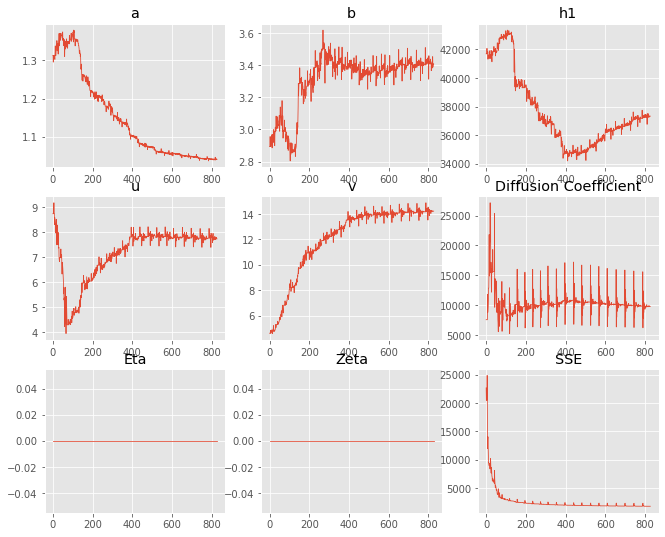

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     1.31346 │      1.04019 │
├──────┼─────────────┼──────────────┤
│ b    │     2.89467 │      3.4079  │
├──────┼─────────────┼──────────────┤
│ h1   │ 41696       │  37334.2     │
├──────┼─────────────┼──────────────┤
│ u    │     8.7273  │      7.72164 │
├──────┼─────────────┼──────────────┤
│ v    │     4.61852 │     14.2204  │
├──────┼─────────────┼──────────────┤
│ D    │  7567.96    │   9793.79    │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 8 Time: 1.462 minutes


Estimated remaining run time: 13.835 minutes


Run 8===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 7119.99,	 Post Misfit: 1733.51


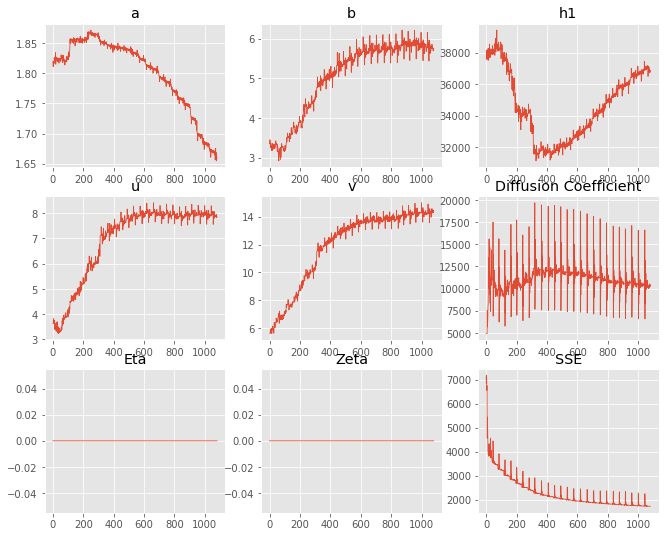

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     1.8191  │      1.66009 │
├──────┼─────────────┼──────────────┤
│ b    │     3.34998 │      5.72362 │
├──────┼─────────────┼──────────────┤
│ h1   │ 37593.5     │  36818.5     │
├──────┼─────────────┼──────────────┤
│ u    │     3.64058 │      7.88023 │
├──────┼─────────────┼──────────────┤
│ v    │     5.63599 │     14.4119  │
├──────┼─────────────┼──────────────┤
│ D    │  4922.87    │  10386.9     │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 9 Time: 1.923 minutes


Estimated remaining run time: 13.243 minutes


Run 9===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 6463.06,	 Post Misfit: 1723.9


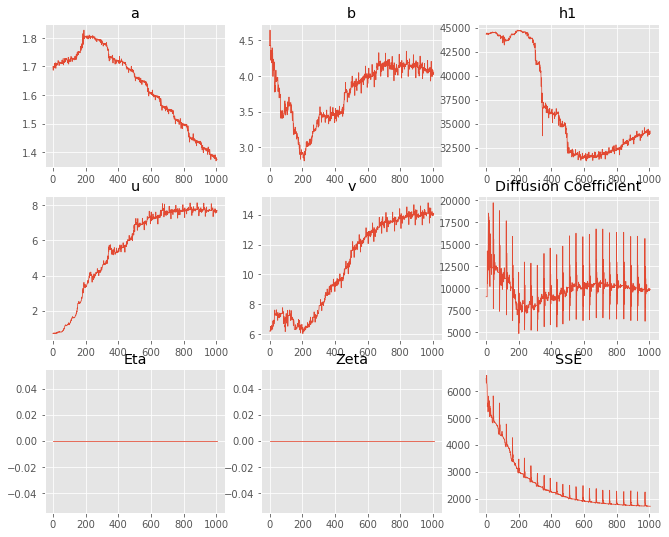

╒══════╤══════════════╤══════════════╕
│      │       Priors │   Posteriors │
╞══════╪══════════════╪══════════════╡
│ a    │     1.69923  │      1.37478 │
├──────┼──────────────┼──────────────┤
│ b    │     4.42563  │      4.04283 │
├──────┼──────────────┼──────────────┤
│ h1   │ 44322.4      │  33999.3     │
├──────┼──────────────┼──────────────┤
│ u    │     0.702716 │      7.70264 │
├──────┼──────────────┼──────────────┤
│ v    │     6.20372  │     14.0958  │
├──────┼──────────────┼──────────────┤
│ D    │  9015.36     │   9867.21    │
├──────┼──────────────┼──────────────┤
│ ftt  │  6458        │   6458       │
├──────┼──────────────┼──────────────┤
│ eta  │     0        │      0       │
├──────┼──────────────┼──────────────┤
│ zeta │     0        │      0       │
╘══════╧══════════════╧══════════════╛
Run 10 Time: 1.700 minutes


Estimated remaining run time: 12.226 minutes


Run 10===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 15042.6,	 Post Misfit: 1790.49


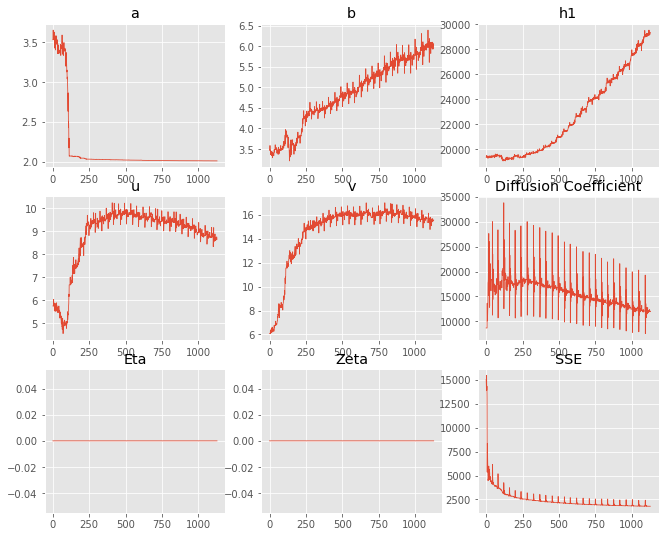

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     3.53277 │      2.00945 │
├──────┼─────────────┼──────────────┤
│ b    │     3.46994 │      6.05521 │
├──────┼─────────────┼──────────────┤
│ h1   │ 19371.6     │  29322.3     │
├──────┼─────────────┼──────────────┤
│ u    │     5.73908 │      8.6458  │
├──────┼─────────────┼──────────────┤
│ v    │     6.07226 │     15.5733  │
├──────┼─────────────┼──────────────┤
│ D    │  8665.37    │  12025.8     │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 11 Time: 1.890 minutes


Estimated remaining run time: 11.222 minutes


Run 11===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 8317.4,	 Post Misfit: 1792.18


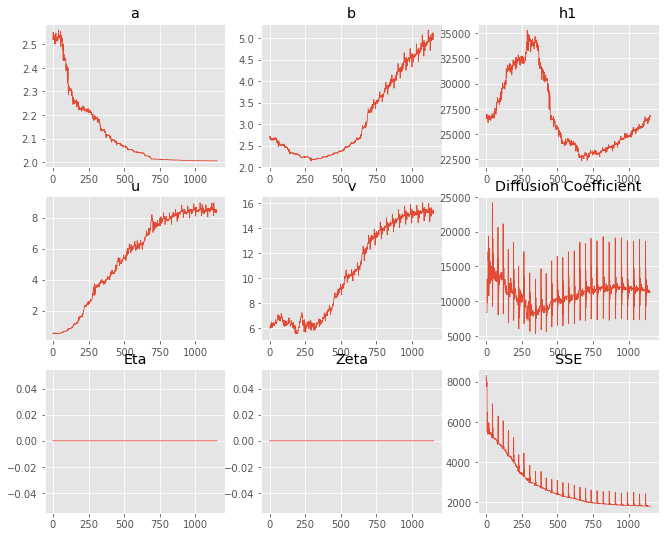

╒══════╤══════════════╤══════════════╕
│      │       Priors │   Posteriors │
╞══════╪══════════════╪══════════════╡
│ a    │     2.52015  │      2.00586 │
├──────┼──────────────┼──────────────┤
│ b    │     2.67607  │      5.0634  │
├──────┼──────────────┼──────────────┤
│ h1   │ 26552.8      │  26738.3     │
├──────┼──────────────┼──────────────┤
│ u    │     0.527768 │      8.43811 │
├──────┼──────────────┼──────────────┤
│ v    │     6.03127  │     15.2377  │
├──────┼──────────────┼──────────────┤
│ D    │  8405.6      │  11331.3     │
├──────┼──────────────┼──────────────┤
│ ftt  │  6458        │   6458       │
├──────┼──────────────┼──────────────┤
│ eta  │     0        │      0       │
├──────┼──────────────┼──────────────┤
│ zeta │     0        │      0       │
╘══════╧══════════════╧══════════════╛
Run 12 Time: 1.933 minutes


Estimated remaining run time: 10.105 minutes


Run 12===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 12647.7,	 Post Misfit: 1765.32


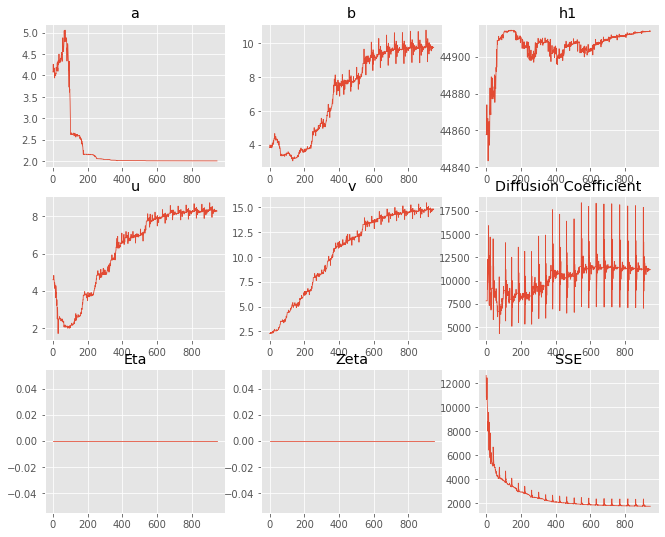

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     4.08319 │      2.00801 │
├──────┼─────────────┼──────────────┤
│ b    │     3.83159 │      9.76761 │
├──────┼─────────────┼──────────────┤
│ h1   │ 44857.6     │  44913.9     │
├──────┼─────────────┼──────────────┤
│ u    │     4.59375 │      8.2787  │
├──────┼─────────────┼──────────────┤
│ v    │     2.26873 │     14.8164  │
├──────┼─────────────┼──────────────┤
│ D    │  7824.95    │  11168.7     │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 13 Time: 1.596 minutes


Estimated remaining run time: 8.727 minutes


Run 13===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 11488.2,	 Post Misfit: 1771.79


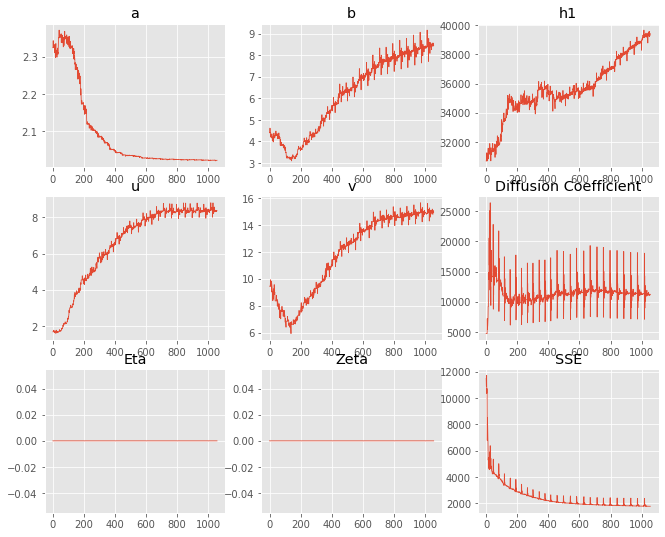

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     2.32469 │      2.02198 │
├──────┼─────────────┼──────────────┤
│ b    │     4.40348 │      8.45719 │
├──────┼─────────────┼──────────────┤
│ h1   │ 30696.1     │  39416       │
├──────┼─────────────┼──────────────┤
│ u    │     1.67754 │      8.36759 │
├──────┼─────────────┼──────────────┤
│ v    │     9.45223 │     14.9521  │
├──────┼─────────────┼──────────────┤
│ D    │  4721.32    │  11222.6     │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 14 Time: 1.774 minutes


Estimated remaining run time: 7.379 minutes


Run 14===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 12715.6,	 Post Misfit: 2165.65


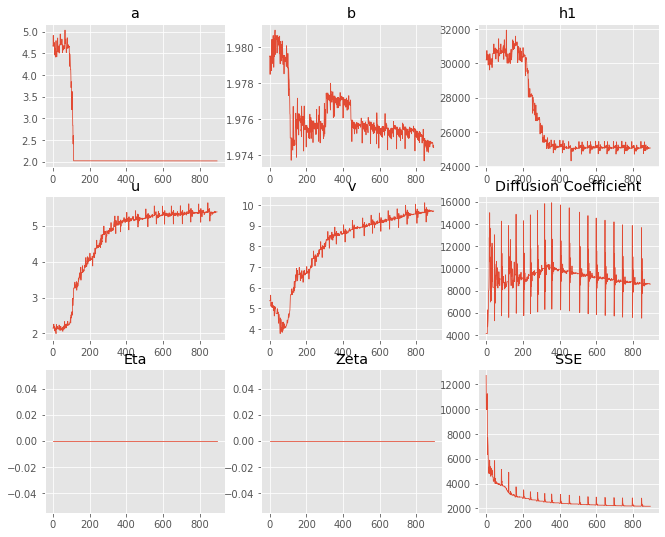

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     4.6679  │      2.01449 │
├──────┼─────────────┼──────────────┤
│ b    │     1.97949 │      1.97443 │
├──────┼─────────────┼──────────────┤
│ h1   │ 30209.2     │  25062.4     │
├──────┼─────────────┼──────────────┤
│ u    │     2.15149 │      5.38677 │
├──────┼─────────────┼──────────────┤
│ v    │     5.36875 │      9.71503 │
├──────┼─────────────┼──────────────┤
│ D    │  4130.51    │   8585.95    │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 15 Time: 1.506 minutes


Estimated remaining run time: 5.911 minutes


Run 15===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 13726.1,	 Post Misfit: 2139.07


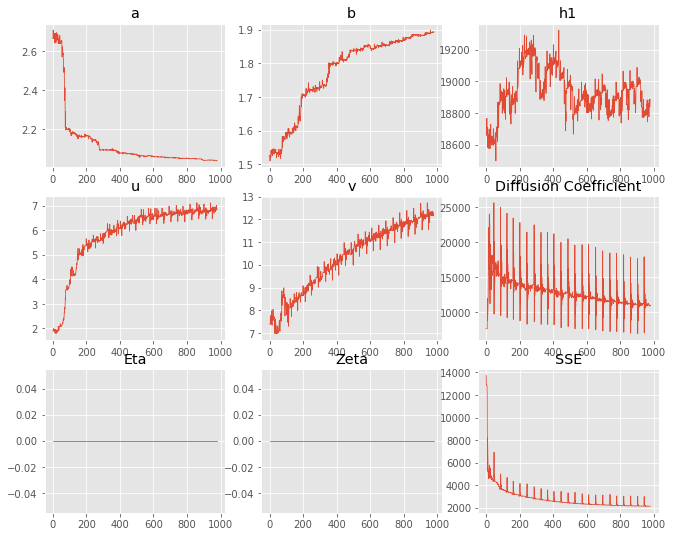

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     2.66502 │      2.03911 │
├──────┼─────────────┼──────────────┤
│ b    │     1.5265  │      1.89352 │
├──────┼─────────────┼──────────────┤
│ h1   │ 18660.3     │  18885.3     │
├──────┼─────────────┼──────────────┤
│ u    │     1.89993 │      6.86408 │
├──────┼─────────────┼──────────────┤
│ v    │     7.38912 │     12.1631  │
├──────┼─────────────┼──────────────┤
│ D    │  7657.04    │  10980.1     │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 16 Time: 1.638 minutes


Estimated remaining run time: 4.461 minutes


Run 16===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 13946.4,	 Post Misfit: 1757.83


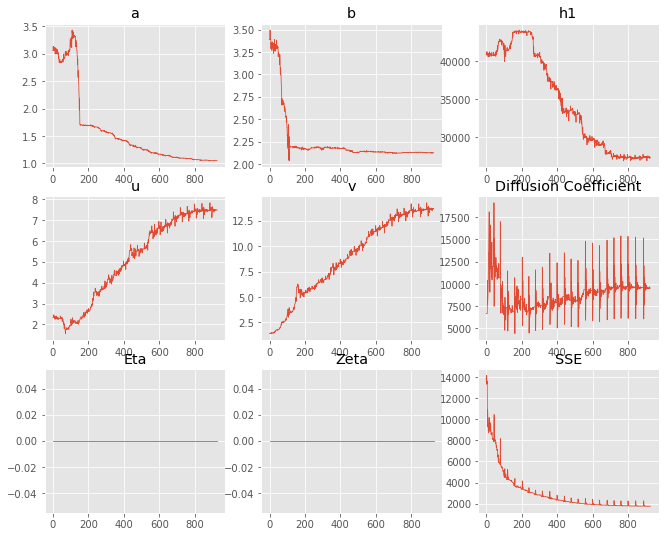

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     3.06205 │      1.04856 │
├──────┼─────────────┼──────────────┤
│ b    │     3.38844 │      2.12672 │
├──────┼─────────────┼──────────────┤
│ h1   │ 40831.2     │  27352.7     │
├──────┼─────────────┼──────────────┤
│ u    │     2.34693 │      7.47928 │
├──────┼─────────────┼──────────────┤
│ v    │     1.39927 │     13.6985  │
├──────┼─────────────┼──────────────┤
│ D    │  6681.11    │   9541.08    │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 17 Time: 1.555 minutes


Estimated remaining run time: 2.982 minutes


Run 17===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 10627.7,	 Post Misfit: 1775.55


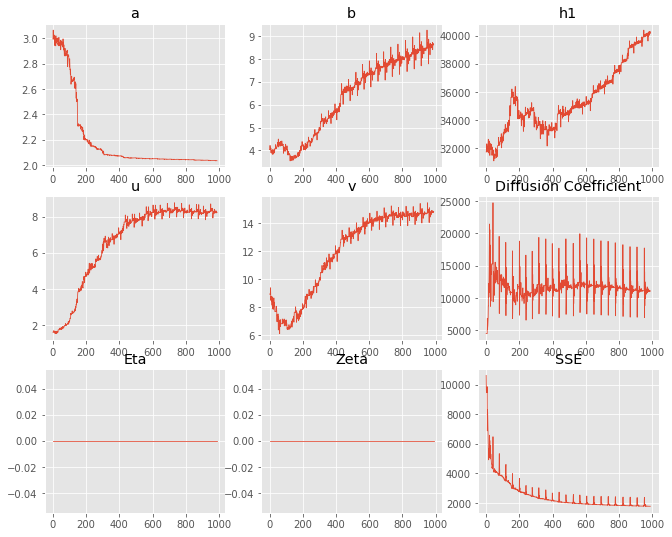

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     2.99473 │      2.03306 │
├──────┼─────────────┼──────────────┤
│ b    │     4.04186 │      8.63664 │
├──────┼─────────────┼──────────────┤
│ h1   │ 31751.3     │  40160.3     │
├──────┼─────────────┼──────────────┤
│ u    │     1.61779 │      8.23156 │
├──────┼─────────────┼──────────────┤
│ v    │     8.93185 │     14.8072  │
├──────┼─────────────┼──────────────┤
│ D    │  4520.78    │  11131.3     │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 18 Time: 1.655 minutes


Estimated remaining run time: 1.499 minutes


Run 18===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 10307.4,	 Post Misfit: 1766.79


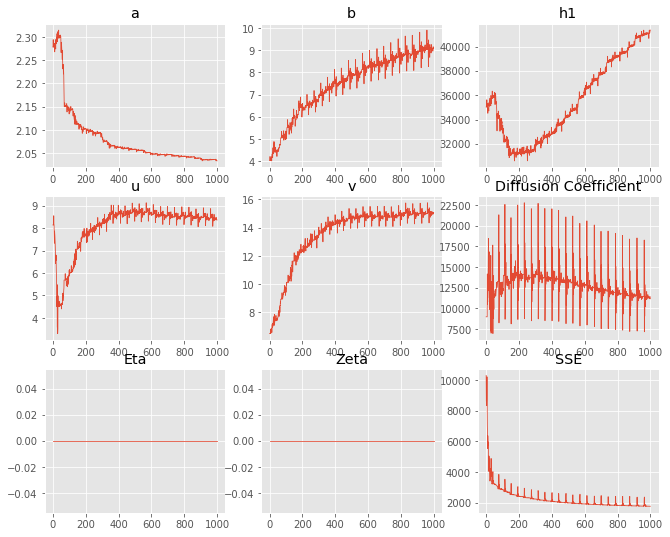

╒══════╤═════════════╤══════════════╕
│      │      Priors │   Posteriors │
╞══════╪═════════════╪══════════════╡
│ a    │     2.27857 │      2.03334 │
├──────┼─────────────┼──────────────┤
│ b    │     4.04318 │      9.08814 │
├──────┼─────────────┼──────────────┤
│ h1   │ 35030       │  41349.9     │
├──────┼─────────────┼──────────────┤
│ u    │     8.14135 │      8.36106 │
├──────┼─────────────┼──────────────┤
│ v    │     6.50775 │     15.0567  │
├──────┼─────────────┼──────────────┤
│ D    │  8981.44    │  11165.6     │
├──────┼─────────────┼──────────────┤
│ ftt  │  6458       │   6458       │
├──────┼─────────────┼──────────────┤
│ eta  │     0       │      0       │
├──────┼─────────────┼──────────────┤
│ zeta │     0       │      0       │
╘══════╧═════════════╧══════════════╛
Run 19 Time: 1.686 minutes


Estimated remaining run time: 0.000 minutes


Run 19===========================================================================


/home/nice/repos/inversion_project/notebooks/../project/inversion.py:860: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


Prior Misfit: 6387.07,	 Post Misfit: 1818.72


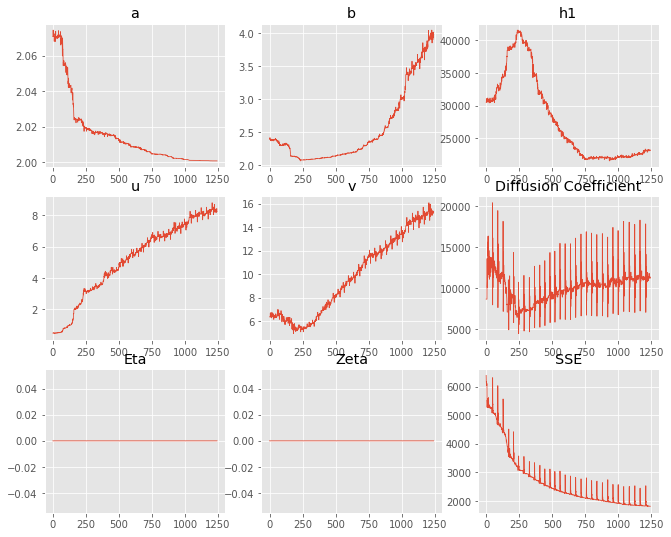

╒══════╤══════════════╤══════════════╕
│      │       Priors │   Posteriors │
╞══════╪══════════════╪══════════════╡
│ a    │     2.07089  │      2.00056 │
├──────┼──────────────┼──────────────┤
│ b    │     2.39142  │      3.98201 │
├──────┼──────────────┼──────────────┤
│ h1   │ 30533.6      │  23202.4     │
├──────┼──────────────┼──────────────┤
│ u    │     0.496281 │      8.23617 │
├──────┼──────────────┼──────────────┤
│ v    │     6.36757  │     15.2876  │
├──────┼──────────────┼──────────────┤
│ D    │  8643.94     │  11262.3     │
├──────┼──────────────┼──────────────┤
│ ftt  │  6458        │   6458       │
├──────┼──────────────┼──────────────┤
│ eta  │     0        │      0       │
├──────┼──────────────┼──────────────┤
│ zeta │     0        │      0       │
╘══════╧══════════════╧══════════════╛
Run 20 Time: 2.111 minutes


Estimated remaining run time: -1.537 minutes


Total Run Time: 32.28713 minutes


In [25]:
# Goodness of fit measure. 
gof="chi-sqr"

#Number of complete iterations.
iterations = 20

out = gaussian_stack_multi_run(
    data_set, 
    len(data_set), 
    int(config["INV_STEPS"]), 
    config["VENT_ELEVATION"], 
    config["THEO_MAX_COL"], 
    2500, 
    prior_phi_steps, 
    config["ERUPTION_MASS"], 
    param_config, 
    runs=iterations, 
    column_cap = config["THEO_MAX_COL"], 
    pre_samples=5,
    sol_iter=20, 
    max_iter=40, 
    tol=0.006, 
    adjust_TGSD=True, 
    adjust_mass=False, 
    gof=gof,
    adjustment_factor=None,
    logging=None
)
inverted_masses_list, misfit_list, params_list, priors_list, heights, tgsd_list, mass_list = out

## Inversion Diagnostics

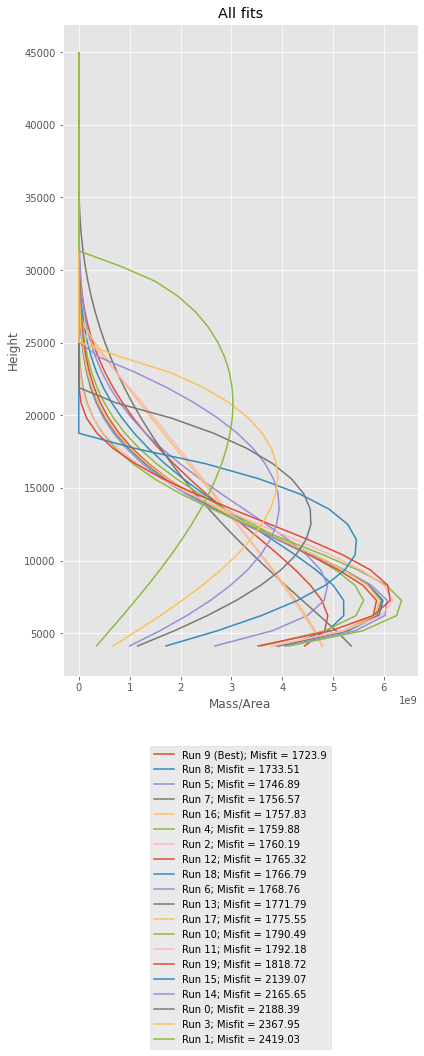

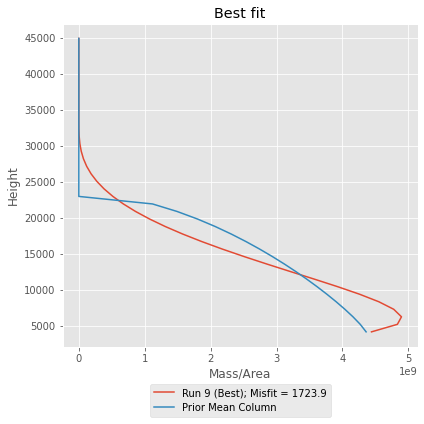

a       b       h1       u       v        D   ftt  eta  zeta       M  \
9  1.37478 4.04283 33,999.3 7.70264 14.0958 9,867.21 6,458    0     0 5.5e+10   
8  1.66009 5.72362 36,818.5 7.88023 14.4119 10,386.9 6,458    0     0 5.5e+10   
5  2.03147 7.07812 41,033.2 7.07398 13.8695 8,629.75 6,458    0     0 5.5e+10   
7  1.04019  3.4079 37,334.2 7.72164 14.2204 9,793.79 6,458    0     0 5.5e+10   
16 1.04856 2.12672 27,352.7 7.47928 13.6985 9,541.08 6,458    0     0 5.5e+10   
4  1.99551 8.49172   42,155 7.97244 14.3629 10,569.4 6,458    0     0 5.5e+10   
2  1.01818 1.95147 26,392.5 7.43565 13.6145 9,561.67 6,458    0     0 5.5e+10   
12 2.00801 9.76761 44,913.9  8.2787 14.8164 11,168.7 6,458    0     0 5.5e+10   
18 2.03334 9.08814 41,349.9 8.36106 15.0567 11,165.6 6,458    0     0 5.5e+10   
6  2.02278 9.02554 40,681.9 8.46197 15.1659 11,424.3 6,458    0     0 5.5e+10   
13 2.02198 8.45719   39,416 8.36759 14.9521 11,222.6 6,458    0     0 5.5e+10   
17 2.03306 8.63664 40,160.3 8.23156 14.8072 11,131.3 6,458    0     0 5.5e+10   
10 2.00945 6.05521 29,322.3  8.6458 15.5733 12,025.8 6,458    0     0 5.5e+10   
11 2.00586  5.0634 26,738.3 8.43811 15.2377 11,331.3 6,458    0     0 5.5e+10   
19 2.00056 3.98201 23,202.4 8.23617 15.2876 11,262.3 6,458    0     0 5.5e+10   
15 2.03911 1.89352 18,885.3 6.86408 12.1631 10,980.1 6,458    0     0 5.5e+10   
14 2.01449 1.97443 25,062.4 5.38677 9.71503 8,585.95 6,458    0     0 5.5e+10   
0  2.05351 1.86459 21,912.7 5.87508 10.6535 9,569.85 6,458    0     0 5.5e+10   
3  2.12186 1.74614 25,100.6 4.95512 9.46412  7,879.9 6,458    0     0 5.5e+10   
1  2.13117 1.62297 31,406.5 3.85392 7.46017 5,982.22 6,458    0     0 5.5e+10   

     Misfit  
9   1,723.9  
8  1,733.51  
5  1,746.89  
7  1,756.57  
16 1,757.83  
4  1,759.88  
2  1,760.19  
12 1,765.32  
18 1,766.79  
6  1,768.76  
13 1,771.79  
17 1,775.55  
10 1,790.49  
11 1,792.18  
19 1,818.72  
15 2,139.07  
14 2,165.65  
0  2,188.39  
3  2,367.95  
1  2,419.03

a       b       h1       u       v        D   ftt  eta  zeta
0    1.02    1.56   24,000 5.73576 8.19152    4,016 6,458    0     0
1 1.66009 5.72362 36,818.5 7.88023 14.4119 10,386.9 6,458    0     0

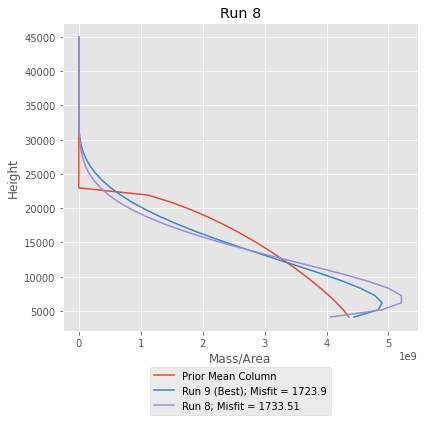

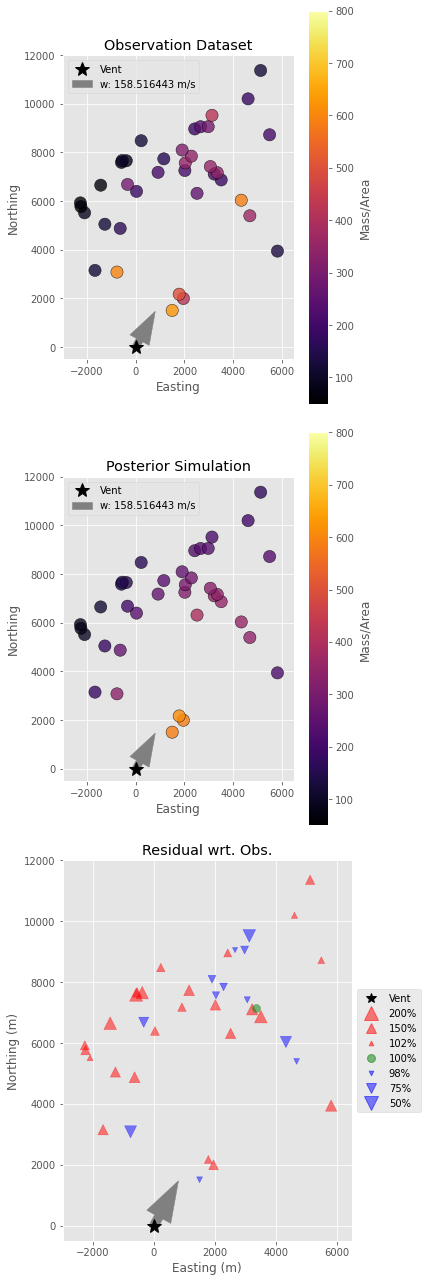

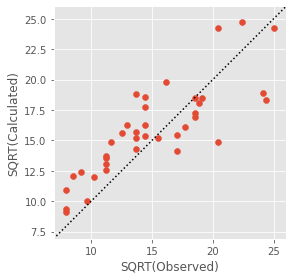

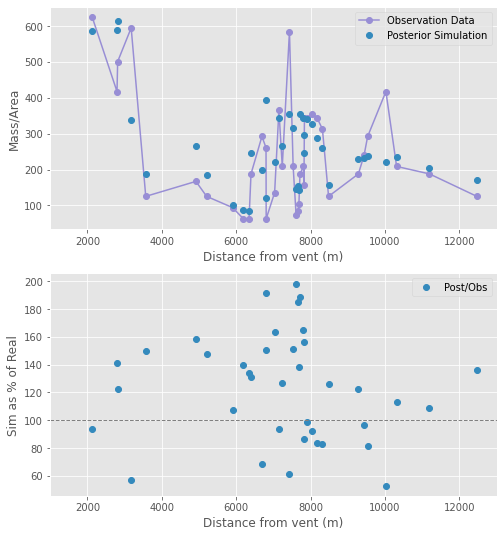

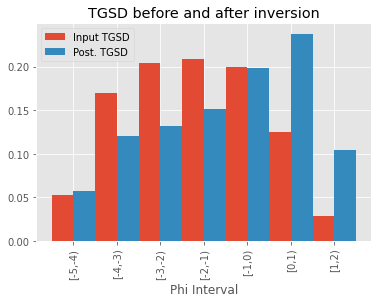

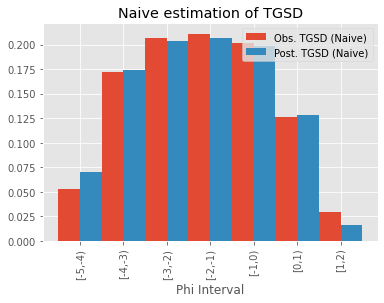

Full misfit 1733.5102137414272
Point Contributions [ 33.16076926  84.84075245  55.31113688 210.39699682  36.3994698
  45.87465153  34.65932647   9.45898758  29.25668415  25.17588015
  38.79816457  82.96304072  44.11024885  39.69788269  34.91903495
  10.00868875  18.65336839 148.43908623  40.30199328  44.0139532
  38.90111677  17.42038182  78.10535124  58.56051254  31.95880071
  13.35593289   3.45927506  31.44333867  21.74470765  22.16268672
  19.37927286  17.35028061  20.0546027   26.87222853 205.69621858
   8.24214388  26.55870158  25.8045442 ]
Phi Contributions [237.3326794  329.83191696 354.90981504 282.1671899  237.76412706
 146.44217974 145.06230563]
Sum of Point Conts: 1733.5102137414276
Sum of Phi Conts: 1733.5102137414272


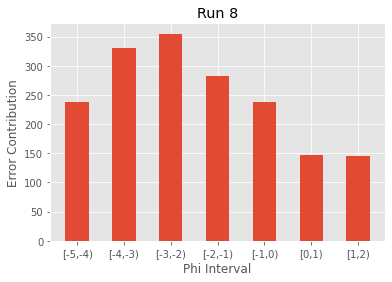

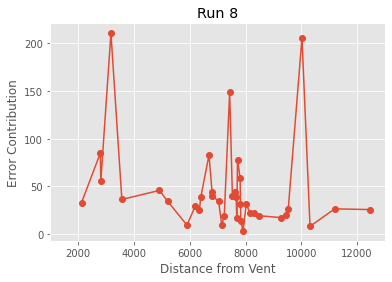

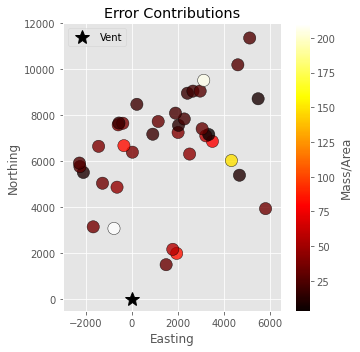

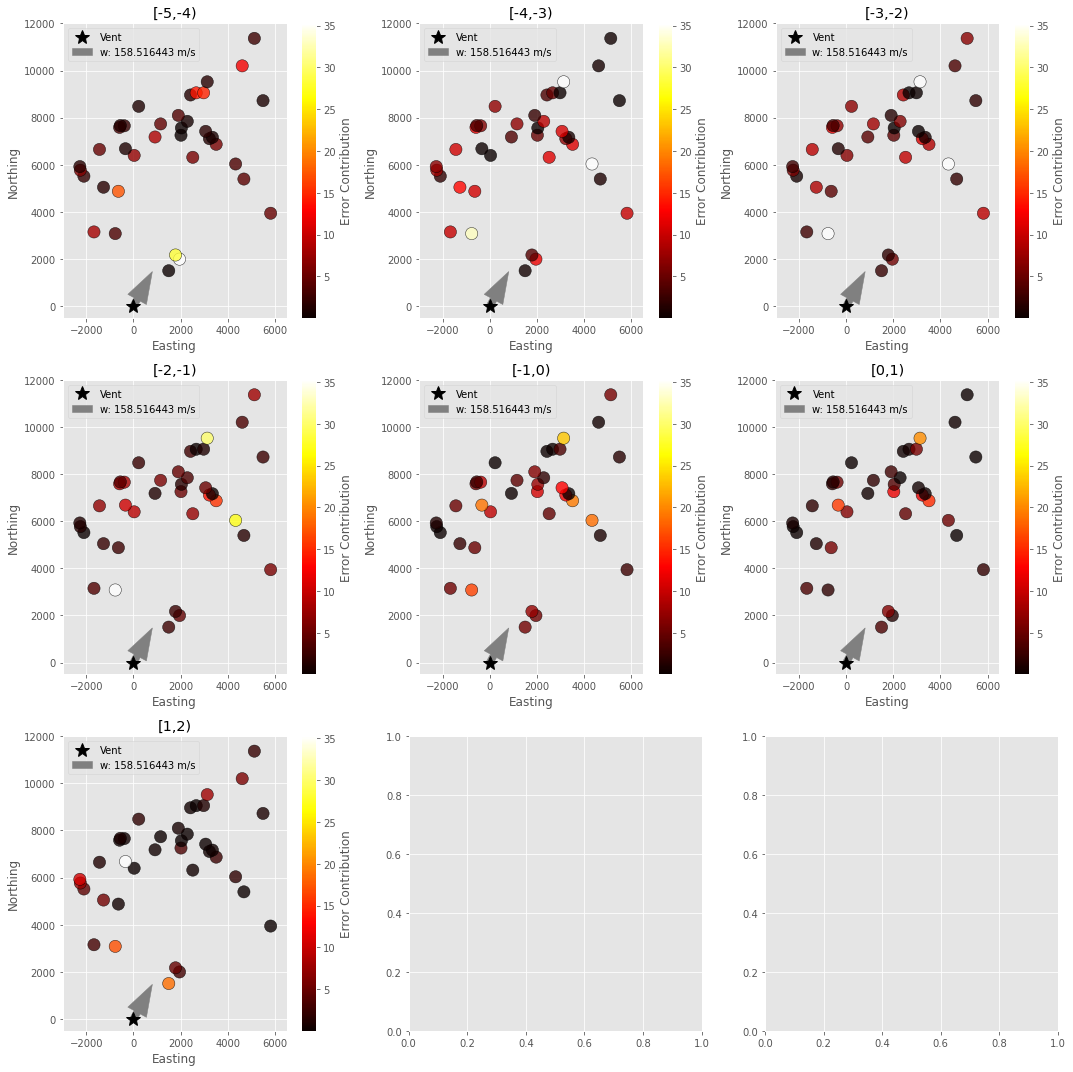

/home/nice/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/nice/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


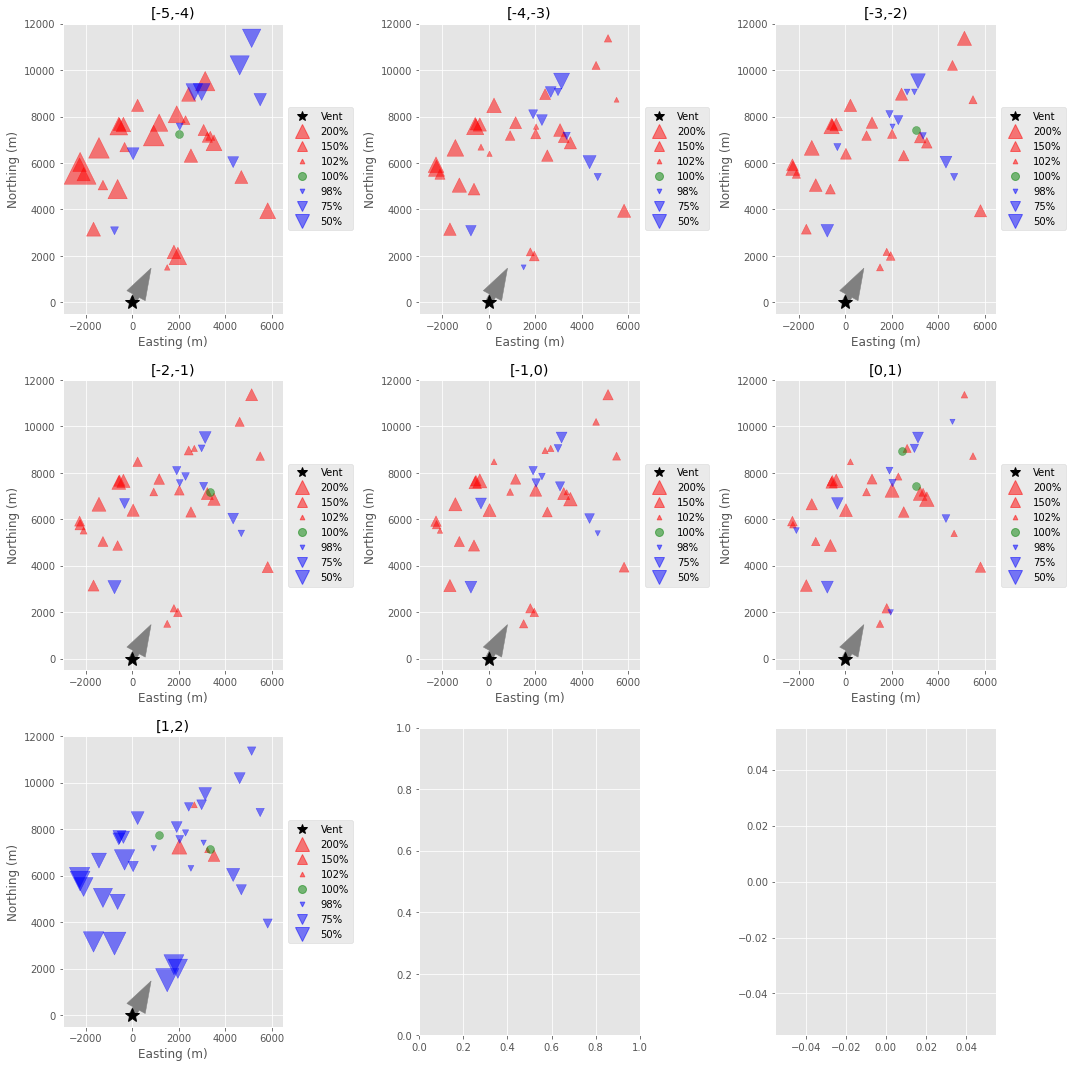

a       b       h1       u       v        D   ftt  eta  zeta
0    1.02    1.56   24,000 5.73576 8.19152    4,016 6,458    0     0
1 2.03147 7.07812 41,033.2 7.07398 13.8695 8,629.75 6,458    0     0

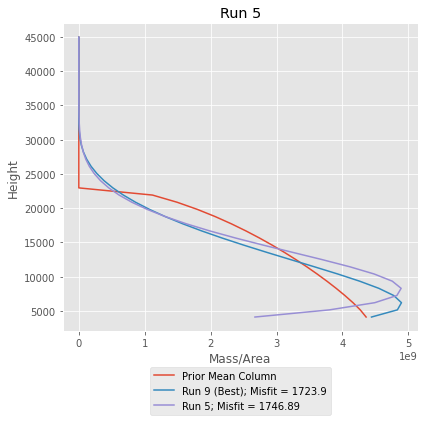

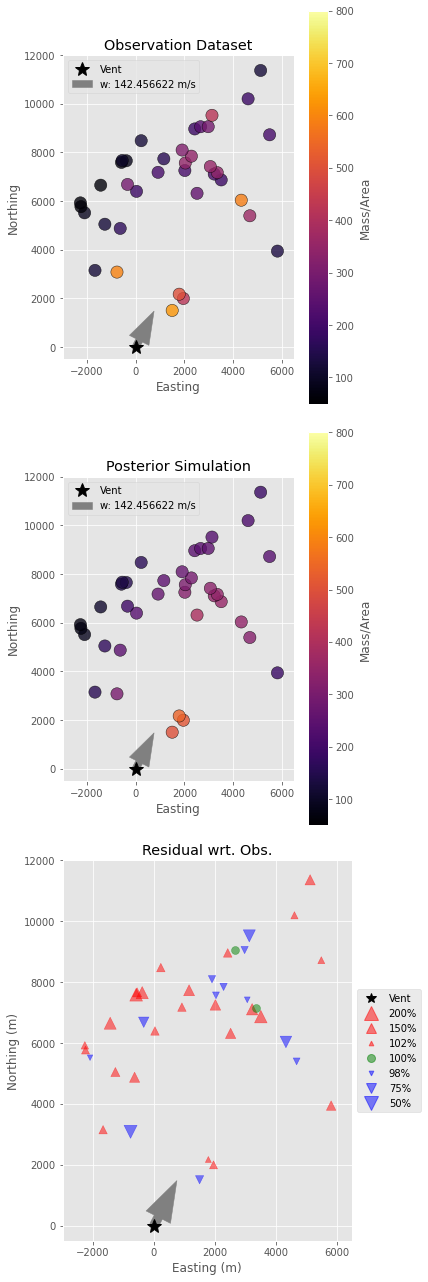

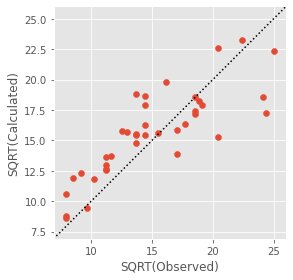

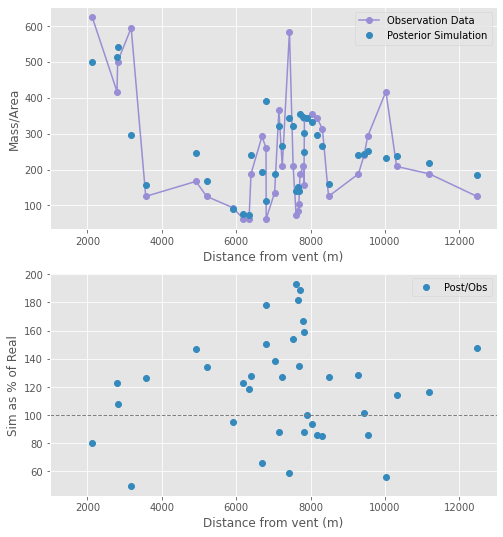

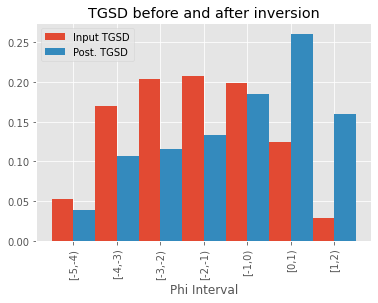

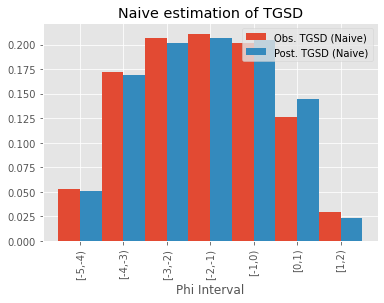

Full misfit 1746.88629022019
Point Contributions [ 38.08244836  38.00709392  20.0110029  325.31852587  17.09432765
  31.65546832  24.35265252   6.49675701  21.54738731  17.13250089
  48.66297212  77.31902488  41.40889051  31.68102821  15.81958767
  13.61423591  16.77646659 180.74719988  46.53502654  39.50080152
  35.01669391  13.83969112  76.99896077  60.58653909  32.2811316
  13.55405103   4.62903292  27.72252852  21.49609709  15.89589737
  16.44386237  16.56764302  43.931524    39.7953378  193.4540058
  11.41753278  39.22598314  32.26637932]
Phi Contributions [257.87743927 343.26245289 371.50379908 301.83257642 227.99447117
 134.97812466 109.43742673]
Sum of Point Conts: 1746.8862902201902
Sum of Phi Conts: 1746.8862902201906


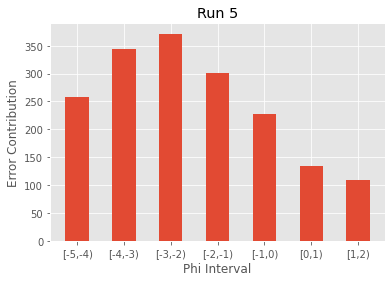

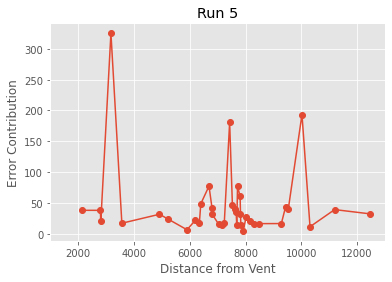

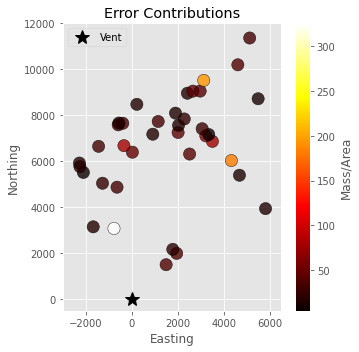

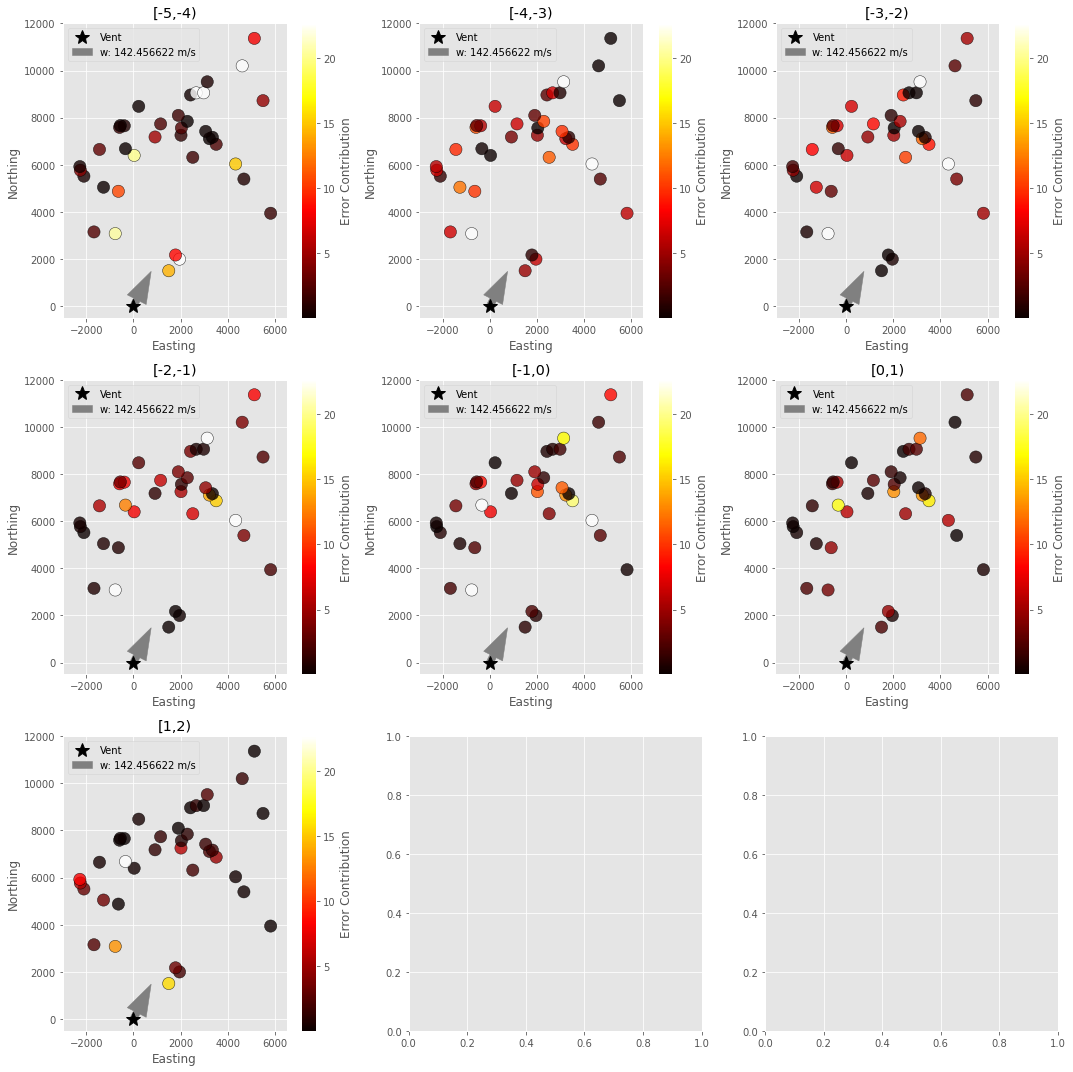

/home/nice/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/nice/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


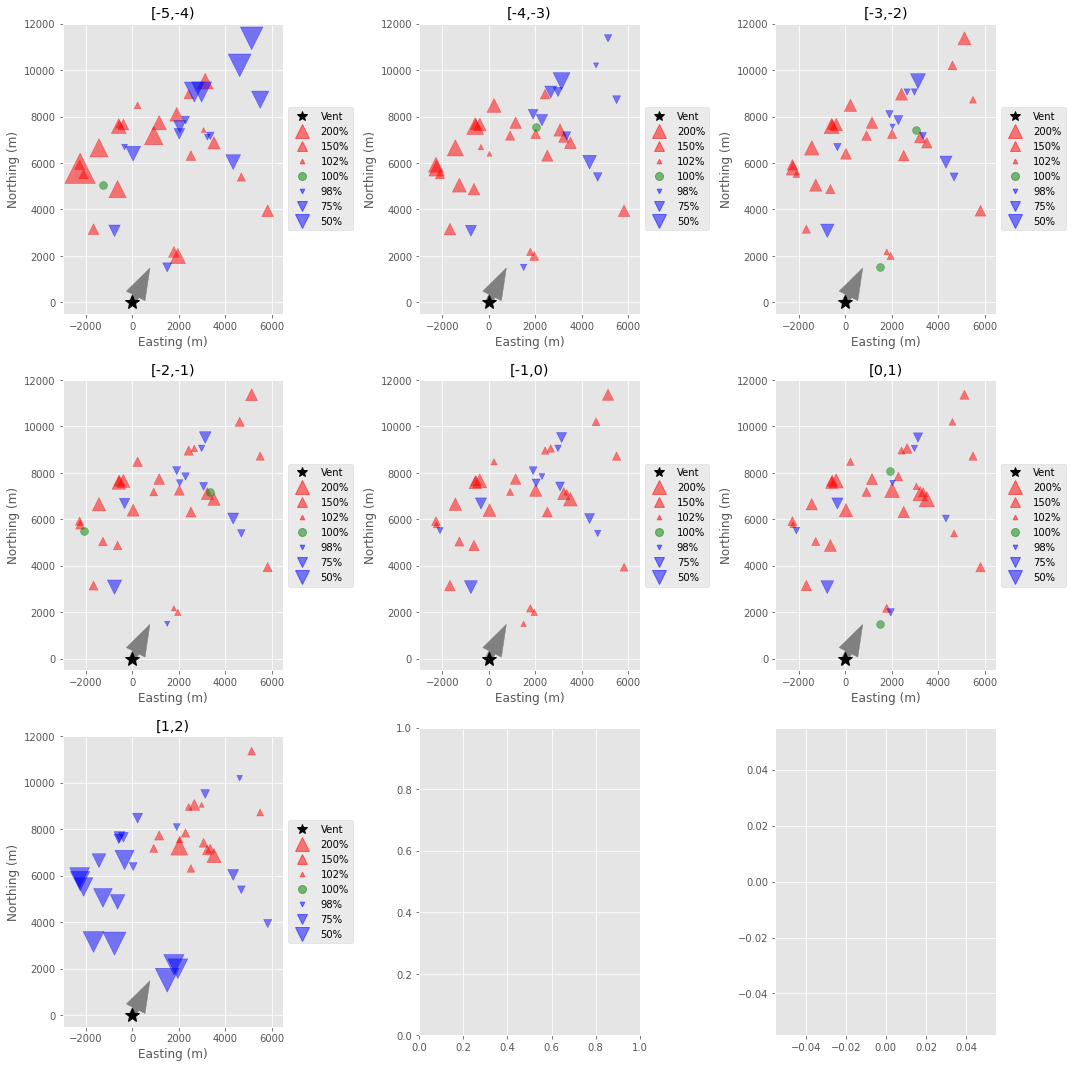

a      b       h1       u       v        D   ftt  eta  zeta
0    1.02   1.56   24,000 5.73576 8.19152    4,016 6,458    0     0
1 1.04019 3.4079 37,334.2 7.72164 14.2204 9,793.79 6,458    0     0

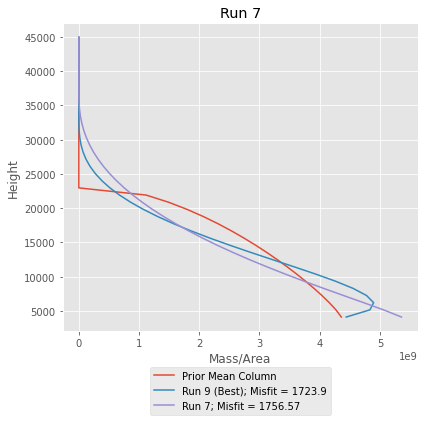

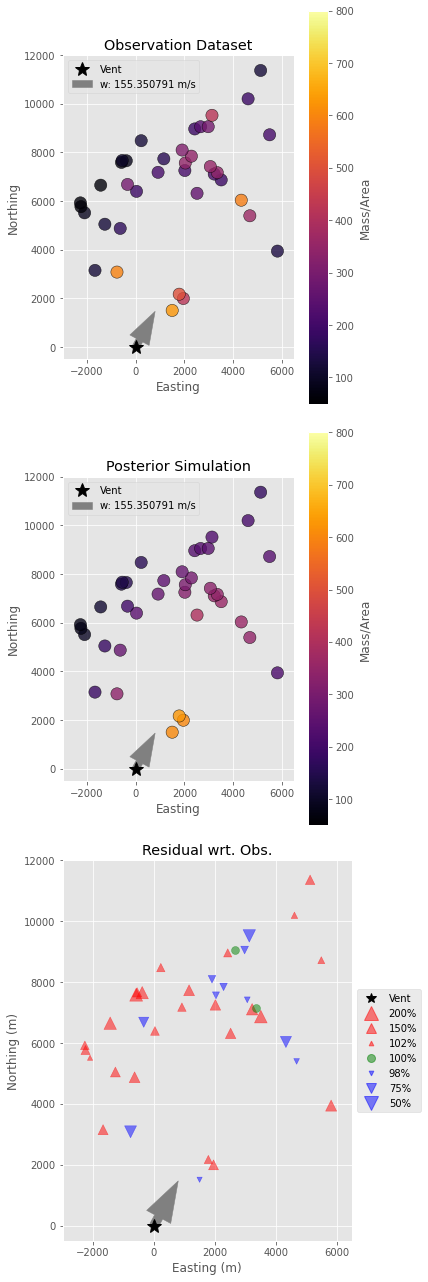

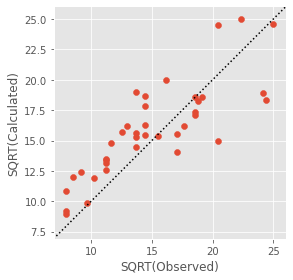

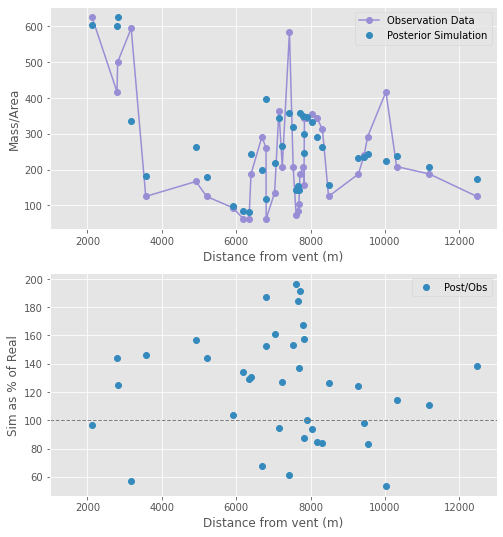

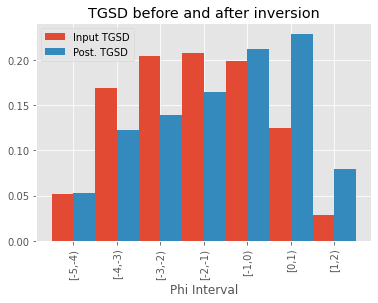

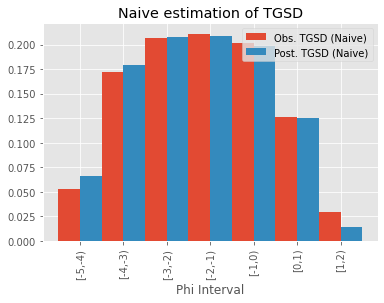

Full misfit 1756.5652354328163
Point Contributions [ 63.59025741 100.93191569  74.38059241 178.47182766  37.52614653
  45.37620969  32.26637341   8.08663209  27.04205277  23.82531914
  40.3418627   82.48796853  45.18022027  37.11433264  31.85505154
  11.78255564  18.4997671  149.24246456  41.09918545  42.28843929
  37.28445584  16.38984748  79.48420702  59.51455182  32.06589256
  14.61667771   3.85827938  36.34217358  20.62235519  24.30983229
  21.11562983  21.83337899  11.09524531  25.91067814 188.91631531
  10.01796028  29.60071896  32.19786122]
Phi Contributions [203.31675203 312.69257856 346.62546837 287.92827608 272.89838267
 176.72397455 156.37980317]
Sum of Point Conts: 1756.5652354328165
Sum of Phi Conts: 1756.5652354328165


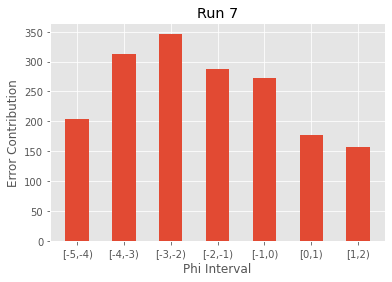

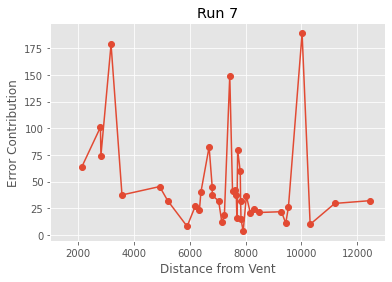

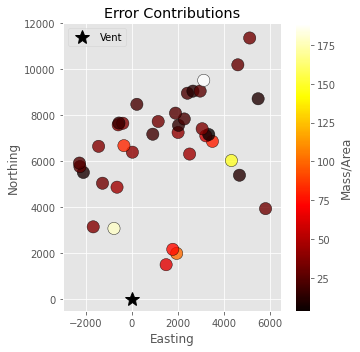

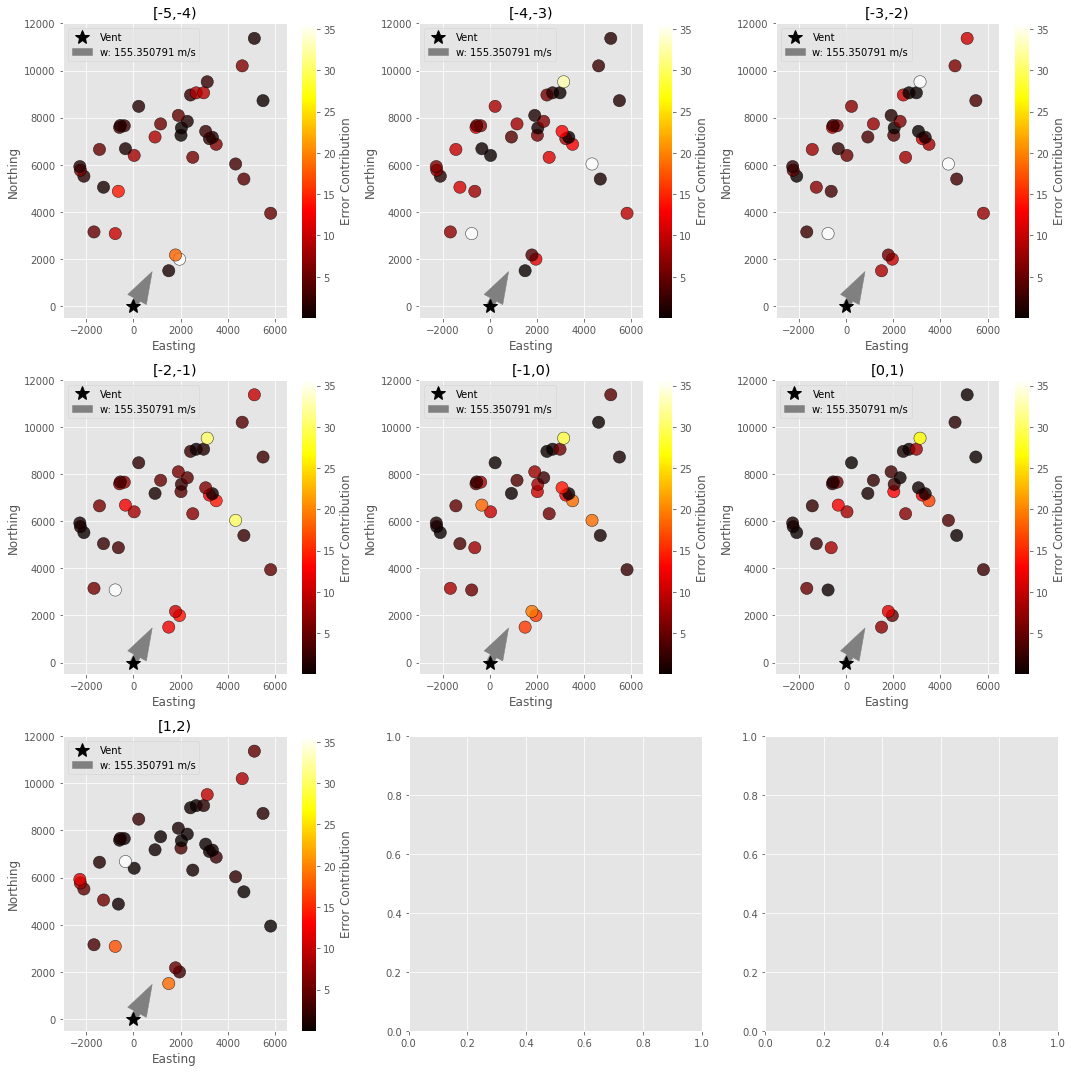

/home/nice/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/nice/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


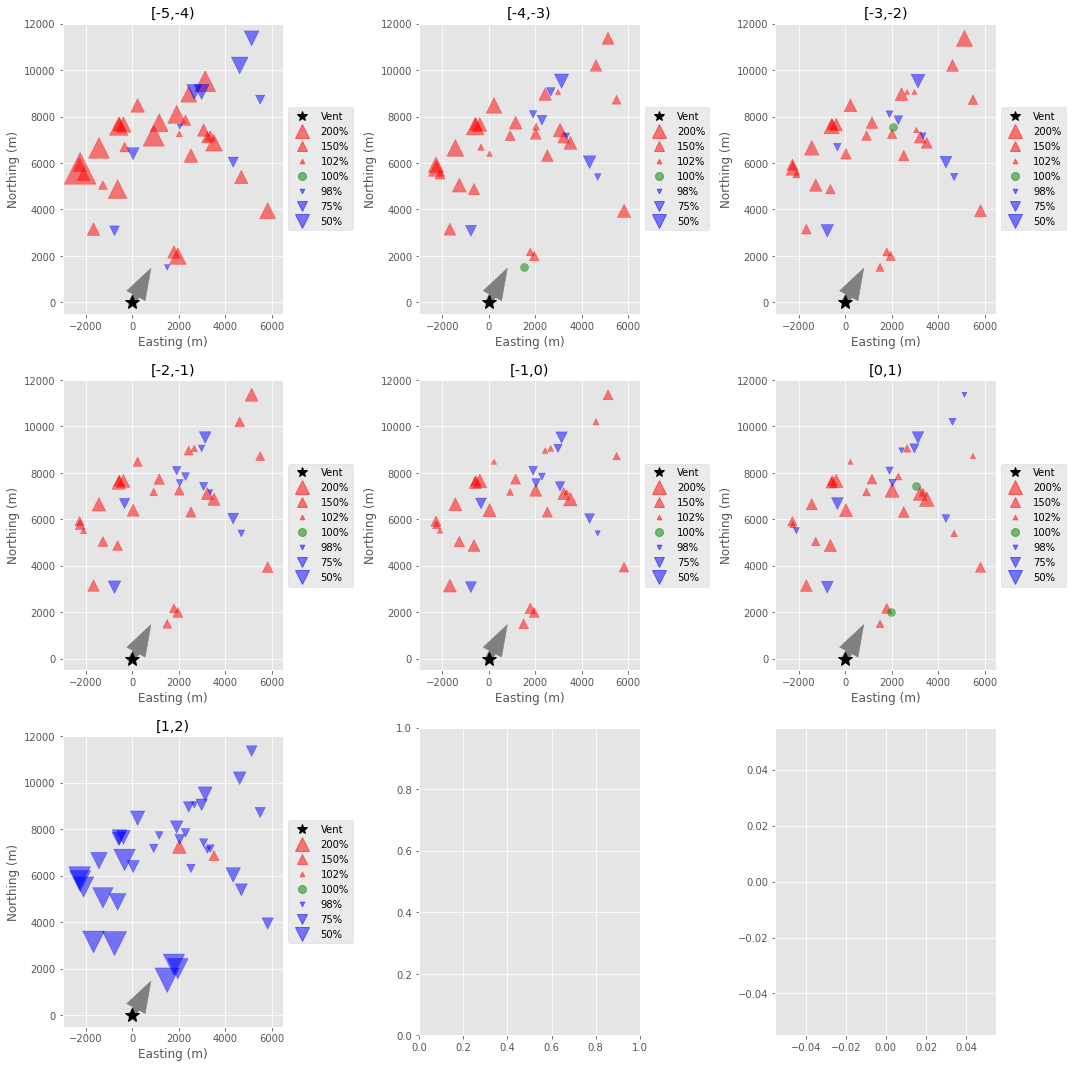

In [28]:

if gof=="RMSE":
    denom = max(data_set["MassArea"]) - min(data_set["MassArea"])
    misfit_list = [mf/denom for mf in misfit_list]

best = np.argsort(misfit_list)

q_mass = beta_plume(config["ALPHA"],config["BETA"],config["PLUME_HEIGHT"],
                    config["ERUPTION_MASS"],
                    heights,
                    config["VENT_ELEVATION"], 
                    config["THEO_MAX_COL"])


fig, ax1 = plt.subplots(1,1, figsize=(6, 15), facecolor='w', edgecolor='k')

ax1.plot(inverted_masses_list[best[0]],
             heights, 
             '-', label="Run %d (Best); Misfit = %g"%(best[0], misfit_list[best[0]]))




for i in best[1:]:
    label = "Run %d; Misfit = %g"%(i, misfit_list[i])
    ax1.plot(inverted_masses_list[i],
             heights, 
             '-', label=label)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax1.set_title("All fits")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")
plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots(1,1, figsize=(6, 6), facecolor='w', edgecolor='k')
ax1.plot(inverted_masses_list[best[0]],
             heights, 
             '-', label="Run %d (Best); Misfit = %g"%(best[0], misfit_list[best[0]]))
ax1.plot(q_mass, heights, label="Prior Mean Column")
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax1.set_title("Best fit")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")
plt.tight_layout()
plt.show()

params_df = pd.DataFrame(params_list)
params_df["M"] = mass_list
params_df["Misfit"] = misfit_list
params_df = params_df.sort_values("Misfit")
params_df = params_df[["a", "b", "h1", "u", "v", "D", "ftt", "eta", "zeta", "M", "Misfit"]]
display(params_df)

priors_vals = {
    "a": config["ALPHA"],
    "b": config["BETA"],
    "h1": config["PLUME_HEIGHT"],
    "u": u,
    "v": v,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "eta": 0,
    "zeta": 0
}

for i in best[1:4]:
    data = data_set.copy()
    
    data = data[data["MassArea"]>0]
    display(pd.DataFrame([priors_vals, params_list[i]]))
    
    fig, ax1 = plt.subplots(1,1, figsize=(6, 6), facecolor='w', edgecolor='k')
    ax1.plot(q_mass, heights, label="Prior Mean Column")
    ax1.plot(inverted_masses_list[best[0]],
             heights, 
             '-', label="Run %d (Best); Misfit = %g"%(best[0], misfit_list[best[0]]))
    label = "Run %d; Misfit = %g"%(i, misfit_list[i])
    ax1.plot(inverted_masses_list[i],
             heights, 
             '-', label=label)
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
    ax1.set_title("Run %d"%i)
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")
    plt.tight_layout()
    plt.show()
    
    phi_new = copy.deepcopy(prior_phi_steps)
    for j, phi in enumerate(phi_new):
        phi["probability"] = tgsd_list[i][j]
    
    q_dist = beta(params_list[i]["a"],params_list[i]["b"])
    
    grid = data[["Easting", "Northing"]]
    
    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        params_list[i]["h1"], 2500, phi_new, (params_list[i]["a"],params_list[i]["b"]), 
        mass_list[i], 
        (params_list[i]["u"],params_list[i]["v"]), params_list[i]["D"], config["EDDY_CONST"],
        params_list[i]["ftt"]
    )

    
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"].values/data["MassArea"].values
    
    ##################SPATIAL PLOTS
    
    fig, axs = plt.subplots(3,1, figsize=(
            6, 18), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    bounds=(50, 800)
    vis.plot_sample(data, vent=(0,0), log=False,bounds=bounds, 
                title="Observation Dataset", cbar_label="Mass/Area", ax=axs[0],
                   wind=(params_list[i]["u"]*20,params_list[i]["v"]*20))
    axs[0].set_xlim([-3000, 6500])
    axs[0].set_ylim([-500, 12000])
    vis.plot_sample(post_df, vent=(0,0), log=False, bounds=bounds,
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1],
                   wind=(params_list[i]["u"]*20,params_list[i]["v"]*20))
    axs[1].set_xlim([-3000, 6500])
    axs[1].set_ylim([-500, 12000])
    vis.plot_residuals(post_df, vent=(0,0), values="Residual", plot_type="size",
                title="Residual wrt. Obs.", ax=axs[2],
                       wind=(params_list[i]["u"]*20,params_list[i]["v"]*20))
    axs[2].set_xlim([-3000, 6500])
    axs[2].set_ylim([-500, 12000])

    plt.tight_layout()
    plt.show()
    
    
    ####################EQUILINE PLOT
    
    min_mass = min((min(data["MassArea"].values), min(post_df["MassArea"].values)))
    max_mass = max((max(data["MassArea"].values), max(post_df["MassArea"].values)))

    fig, ax = plt.subplots(facecolor='w', edgecolor='k')
    ax.scatter(np.sqrt(data["MassArea"].values), np.sqrt(post_df["MassArea"].values))
    ax.plot([0,100],[0,100], "k:")
    ax.set_xlabel("SQRT(Observed)")
    ax.set_ylabel("SQRT(Calculated)")
    ax.set_aspect('equal', 'box')
    ax.set_xlim([np.sqrt(min_mass)-1, np.sqrt(max_mass)+1])
    ax.set_ylim([np.sqrt(min_mass)-1, np.sqrt(max_mass)+1])
    fig.tight_layout()
    plt.show()
    
    ################# DISTANCE PLOTS
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(data["radius"].values, data["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")
    axs[0].set_xlim(1000, 13000)

    axs[1].plot(post_df["radius"].values, post_df["Residual"].values*100, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")  
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    axs[1].set_xlim(1000, 13000)
    plt.show()
    
    
    ################# TGSD PLOTS
    
    old_tgsd = [phi["probability"] for phi in prior_phi_steps]
    x = [phi["centroid"] for phi in phi_new]
    labels = [phi["interval"] for phi in phi_new]
    
    obs_tgsd = get_tgsd(data, phi_new)
    post_tgsd = get_tgsd(post_df, phi_new)
    
    
    
    fig, ax = plt.subplots(facecolor='w', edgecolor='k')
    ax.bar([xx-0.25 for xx in x], old_tgsd, width=0.5, align="center", label="Input TGSD")
    ax.bar([xx+0.25 for xx in x], tgsd_list[i], width=0.5, align="center", label="Post. TGSD")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_xlabel("Phi Interval")
    plt.title("TGSD before and after inversion")
    plt.legend()
    
    plt.show()
    
    fig, ax = plt.subplots(facecolor='w', edgecolor='k')
    ax.bar([xx-0.25 for xx in x], obs_tgsd, width=0.5, align="center", label="Obs. TGSD (Naive)")
    ax.bar([xx+0.25 for xx in x], post_tgsd, width=0.5, align="center", label="Post. TGSD (Naive)")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_xlabel("Phi Interval")
    plt.title("Naive estimation of TGSD")
    plt.legend()
    
    plt.show()
    
    ################# ERROR CONTRIBUTION PLOTS
    
    new_steps = copy.deepcopy(prior_phi_steps)
    for j, phi in enumerate(new_steps):
        phi["probability"] = tgsd_list[i][j]

    misfit, contributions, setup = get_error_contributions(
        data, len(data), int(config["INV_STEPS"]), 
        config["VENT_ELEVATION"], config["THEO_MAX_COL"], 2500, new_steps, 
        params_list[i], mass_list[i], column_cap = config["THEO_MAX_COL"], gof=gof)
    
    point_contributions = np.sum(contributions, 0)
    phi_contributions = np.sum(contributions, 1)
    
    print("Full misfit", misfit)

    print("Point Contributions", point_contributions)
    print("Phi Contributions", phi_contributions)

    print("Sum of Point Conts:", sum(point_contributions))
    print("Sum of Phi Conts:", sum(phi_contributions))
    
    #### Phi Error Contributions
    fig, ax = plt.subplots(facecolor='w', edgecolor='k')
    ax.bar(x, phi_contributions, width=0.5, align="center")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.xlabel("Phi Interval")
    plt.ylabel("Error Contribution")
    plt.title("Run %d"%i)
    plt.show()
    
    #### Distance Error Contributions
    fig, ax = plt.subplots(facecolor='w', edgecolor='k')
    ax.plot(data["radius"], point_contributions, "C0o-")
    plt.xlabel("Distance from Vent")
    plt.ylabel("Error Contribution")
    plt.title("Run %d"%i)
    ax.set_xlim(1000, 13000)
    plt.show()
    
    #### Spatial Error Contributions
    data["Contributions"] = point_contributions
    fig, ax = plt.subplots(1, 1, figsize=(5,5), facecolor='w', edgecolor='k')

    vis.plot_sample(data, vent=(0,0), log=False, values="Contributions",
                title="Error Contributions", cbar_label="Mass/Area", ax = ax, cmap="hot")
    ax.set_xlim([-3000, 6500])
    ax.set_ylim([-500, 12000])
    plt.tight_layout()
    plt.show()
#      bounds=(min(min(contributions)),max(max(contributions))),
    #### Phi and Spatial Error Contributions
    fig, axs = plt.subplots(3, 3, figsize=(15,15), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for j, phi_cont in enumerate(phi_contributions):
        data["Contributions"] = contributions[j]
#         display(data[["Contributions", "MassArea"]])
        vis.plot_sample(data, vent=(0,0), log=False, values="Contributions", 
                        bounds=(min(min(contributions)),max(max(contributions))),
                        title=phi_new[j]["interval"], cbar_label="Error Contribution", 
                        ax = axs[j], cmap="hot", 
                        wind=(params_list[i]["u"]*20,params_list[i]["v"]*20))
        axs[j].set_xlim([-3000, 6500])
        axs[j].set_ylim([-500, 12000])
    plt.tight_layout()
    plt.show()

    #################### PHI AND SPATIAL RESIDUALS
    fig, axs = plt.subplots(3, 3, figsize=(15,15), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for j, phi_step in enumerate(phi_new):
        post_df["mass_res"] = (post_df["MassArea"].values*(post_df[phi_step["interval"]].values/100))/\
                             (data["MassArea"].values*(data[phi_step["interval"]].values/100))
        
        disp_df = post_df[["Northing", "Easting", "MassArea", phi_step["interval"], "mass_res"]]
        disp_df["Obs. MassArea"] = data["MassArea"].values
        disp_df[("Obs. " + phi_step["interval"])] = data[phi_step["interval"]].values
        disp_df.rename(columns = {'MassArea':'Post. MassArea', 
                                  phi_step["interval"]:("Post. " + phi_step["interval"]),
                                 "mass_res":"Residual"},
                       inplace = True)
        vis.plot_residuals(post_df, vent=(0,0), values="mass_res", plot_type="size",
                        title=prior_phi_steps[j]["interval"],  
                        ax = axs[j]
                          , wind=(params_list[i]["u"]*20,params_list[i]["v"]*20))
        axs[j].set_xlim([-3000, 6500])
        axs[j].set_ylim([-500, 12000])
    plt.tight_layout()
    plt.show()
    
